## Setup and Data Loading

In [1]:
import json
import pandas as pd
import os
from collections import Counter
from google.colab import drive
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from scipy.stats import gaussian_kde ,pearsonr , ttest_ind
import nltk
import re
from nltk.tokenize import word_tokenize
import nltk
from nltk.corpus import stopwords
from sentence_transformers import SentenceTransformer
from sklearn.metrics.pairwise import cosine_similarity
from pprint import pprint


In [2]:
nltk.download('punkt_tab')

[nltk_data] Downloading package punkt_tab to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt_tab.zip.


True

In [5]:
data_path = '/content/datasetLLMProject/'

with open(f'{data_path}train.json', 'r') as f:
    train_data = json.load(f)

with open(f'{data_path}dev.json', 'r') as f:
    dev_data = json.load(f)

all_data = {}
for story_id, content in train_data.items():
    all_data[f"train_{story_id}"] = content

for story_id, content in dev_data.items():
    all_data[f"dev_{story_id}"] = content

In [7]:
print(f"Total stories in all_data: {len(all_data)}")
if all_data:

    stories_list = []
    for story_id, content in all_data.items():
        story_content = content.copy()
        story_content['story_id'] = story_id
        stories_list.append(story_content)

    all_data_df = pd.DataFrame(stories_list)

    print("\nFirst 5 rows of the combined dataset DataFrame:")
    print(all_data_df.head())

    print("\nDataFrame Info:")
    all_data_df.info()
else:
    print("The all_data dictionary is empty.")

Total stories in all_data: 2868

First 5 rows of the combined dataset DataFrame:
     homonym                                     judged_meaning  \
0  potential  the difference in electrical charge between tw...   
1  potential        the inherent capacity for coming into being   
2  potential  the difference in electrical charge between tw...   
3  potential        the inherent capacity for coming into being   
4  potential  the difference in electrical charge between tw...   

                                          precontext  \
0  The old machine hummed in the corner of the wo...   
1  The old machine hummed in the corner of the wo...   
2  The old machine hummed in the corner of the wo...   
3  The old machine hummed in the corner of the wo...   
4  The old machine hummed in the corner of the wo...   

                              sentence  \
0  The potential couldn't be measured.   
1  The potential couldn't be measured.   
2  The potential couldn't be measured.   
3  The pote

In [8]:
all_data_df.columns

Index(['homonym', 'judged_meaning', 'precontext', 'sentence', 'ending',
       'choices', 'average', 'stdev', 'nonsensical', 'sample_id',
       'example_sentence', 'story_id'],
      dtype='object')

## Dataset Dimensions

In [9]:
def calculate_dimensions(data, dataset_name):
    total_stories = len(data)

    total_annotations = 0
    for story_id, content in data.items():
        total_annotations += len(content['choices'])

    unique_homonyms = set()
    for story_id, content in data.items():
        unique_homonyms.add(content['homonym'])

    print(f"\n{dataset_name} Dataset Dimensions")
    print(f"Total stories: {total_stories}")
    print(f"Total annotations: {total_annotations}")
    print(f"Unique homonyms: {len(unique_homonyms)}")

    return total_stories, total_annotations, len(unique_homonyms)

train_dims = calculate_dimensions(train_data, "TRAIN")
dev_dims = calculate_dimensions(dev_data, "DEV")
all_dims = calculate_dimensions(all_data, "COMBINED")


TRAIN Dataset Dimensions
Total stories: 2280
Total annotations: 11434
Unique homonyms: 220

DEV Dataset Dimensions
Total stories: 588
Total annotations: 2952
Unique homonyms: 55

COMBINED Dataset Dimensions
Total stories: 2868
Total annotations: 14386
Unique homonyms: 275


## Homonym Distribution Analysis

In [10]:
def analyze_homonyms(data):
    homonym_counts = Counter()

    for story_id, content in data.items():
        homonym_counts[content['homonym']] += 1

    homonym_df = pd.DataFrame(homonym_counts.items(), columns=['Homonym', 'Count'])
    homonym_df = homonym_df.sort_values('Count', ascending=False)

    print(f"\nHomonym Distribution")
    print(f"Total unique homonyms: {len(homonym_df)}")

    print("\nTop 10 Most Frequent Homonyms:")
    print(homonym_df.head(10))

    print("\nBottom 5 Least Frequent Homonyms:")
    print(homonym_df.tail(5))

    return homonym_df

homonym_df = analyze_homonyms(all_data)


Homonym Distribution
Total unique homonyms: 275

Top 10 Most Frequent Homonyms:
       Homonym  Count
196     change     60
76       lousy     54
37        ring     36
213   sentence     36
117        cut     30
191    snapped     30
233   downhill     30
26   faculties     30
217      steps     30
73       serve     30

Bottom 5 Least Frequent Homonyms:
       Homonym  Count
160    charged      6
62    problems      6
162  littering      6
163       toll      6
67      backup      6


## Data Completeness Check

In [11]:
def check_completeness(data):
    stories_with_ending = 0
    stories_without_ending = 0
    missing_fields = 0
    incorrect_ratings = 0

    required_fields = ['homonym', 'precontext', 'sentence', 'choices', 'average', 'stdev']

    for story_id, content in data.items():

        if content.get('ending', '').strip():
            stories_with_ending += 1
        else:
            stories_without_ending += 1

        for field in required_fields:
            if field not in content:
                missing_fields += 1
                print(f"Missing {field} in story {story_id}")

        if len(content['choices']) != 5:
            incorrect_ratings += 1
            print(f"Unexpected ratings count in story {story_id}: {len(content['choices'])}")

    print(f"\nData Completeness Report")
    print(f"Stories with endings: {stories_with_ending}")
    print(f"Stories without endings: {stories_without_ending}")
    print(f"Missing fields count: {missing_fields}")
    print(f"Stories with incorrect rating count: {incorrect_ratings}")

    return stories_with_ending, stories_without_ending

ending_stats = check_completeness(all_data)

Unexpected ratings count in story train_93: 6
Unexpected ratings count in story train_133: 6
Unexpected ratings count in story train_176: 6
Unexpected ratings count in story train_249: 6
Unexpected ratings count in story train_298: 6
Unexpected ratings count in story train_484: 6
Unexpected ratings count in story train_532: 6
Unexpected ratings count in story train_541: 6
Unexpected ratings count in story train_609: 6
Unexpected ratings count in story train_677: 6
Unexpected ratings count in story train_759: 6
Unexpected ratings count in story train_828: 6
Unexpected ratings count in story train_940: 6
Unexpected ratings count in story train_1088: 6
Unexpected ratings count in story train_1115: 6
Unexpected ratings count in story train_1152: 6
Unexpected ratings count in story train_1211: 6
Unexpected ratings count in story train_1212: 6
Unexpected ratings count in story train_1254: 6
Unexpected ratings count in story train_1298: 6
Unexpected ratings count in story train_1416: 6
Unexpe

## Basic Statistical Summary

In [12]:
def basic_statistical_summary(data):
    all_ratings = []
    all_averages = []
    all_stdevs = []

    for story_id, content in data.items():
        all_ratings.extend(content['choices'])
        all_averages.append(content['average'])
        all_stdevs.append(content['stdev'])

    print(f"\nBasic Statistical Summary")
    print(f"Overall average rating: {sum(all_ratings)/len(all_ratings):.2f}")
    print(f"Minimum average rating: {min(all_averages):.2f}")
    print(f"Maximum average rating: {max(all_averages):.2f}")
    print(f"Global average standard deviation: {sum(all_stdevs)/len(all_stdevs):.2f}")

    print(f"\nAdditional Insights")
    print(f"Total ratings analyzed: {len(all_ratings)}")
    print(f"Rating range: 1 to 5")
    print(f"Most common rating: {Counter(all_ratings).most_common(1)[0]}")

    return all_ratings, all_averages, all_stdevs

ratings, averages, stdevs = basic_statistical_summary(all_data)


Basic Statistical Summary
Overall average rating: 3.13
Minimum average rating: 1.00
Maximum average rating: 5.00
Global average standard deviation: 0.95

Additional Insights
Total ratings analyzed: 14386
Rating range: 1 to 5
Most common rating: (5, 4098)


## Dataset Overview Plots

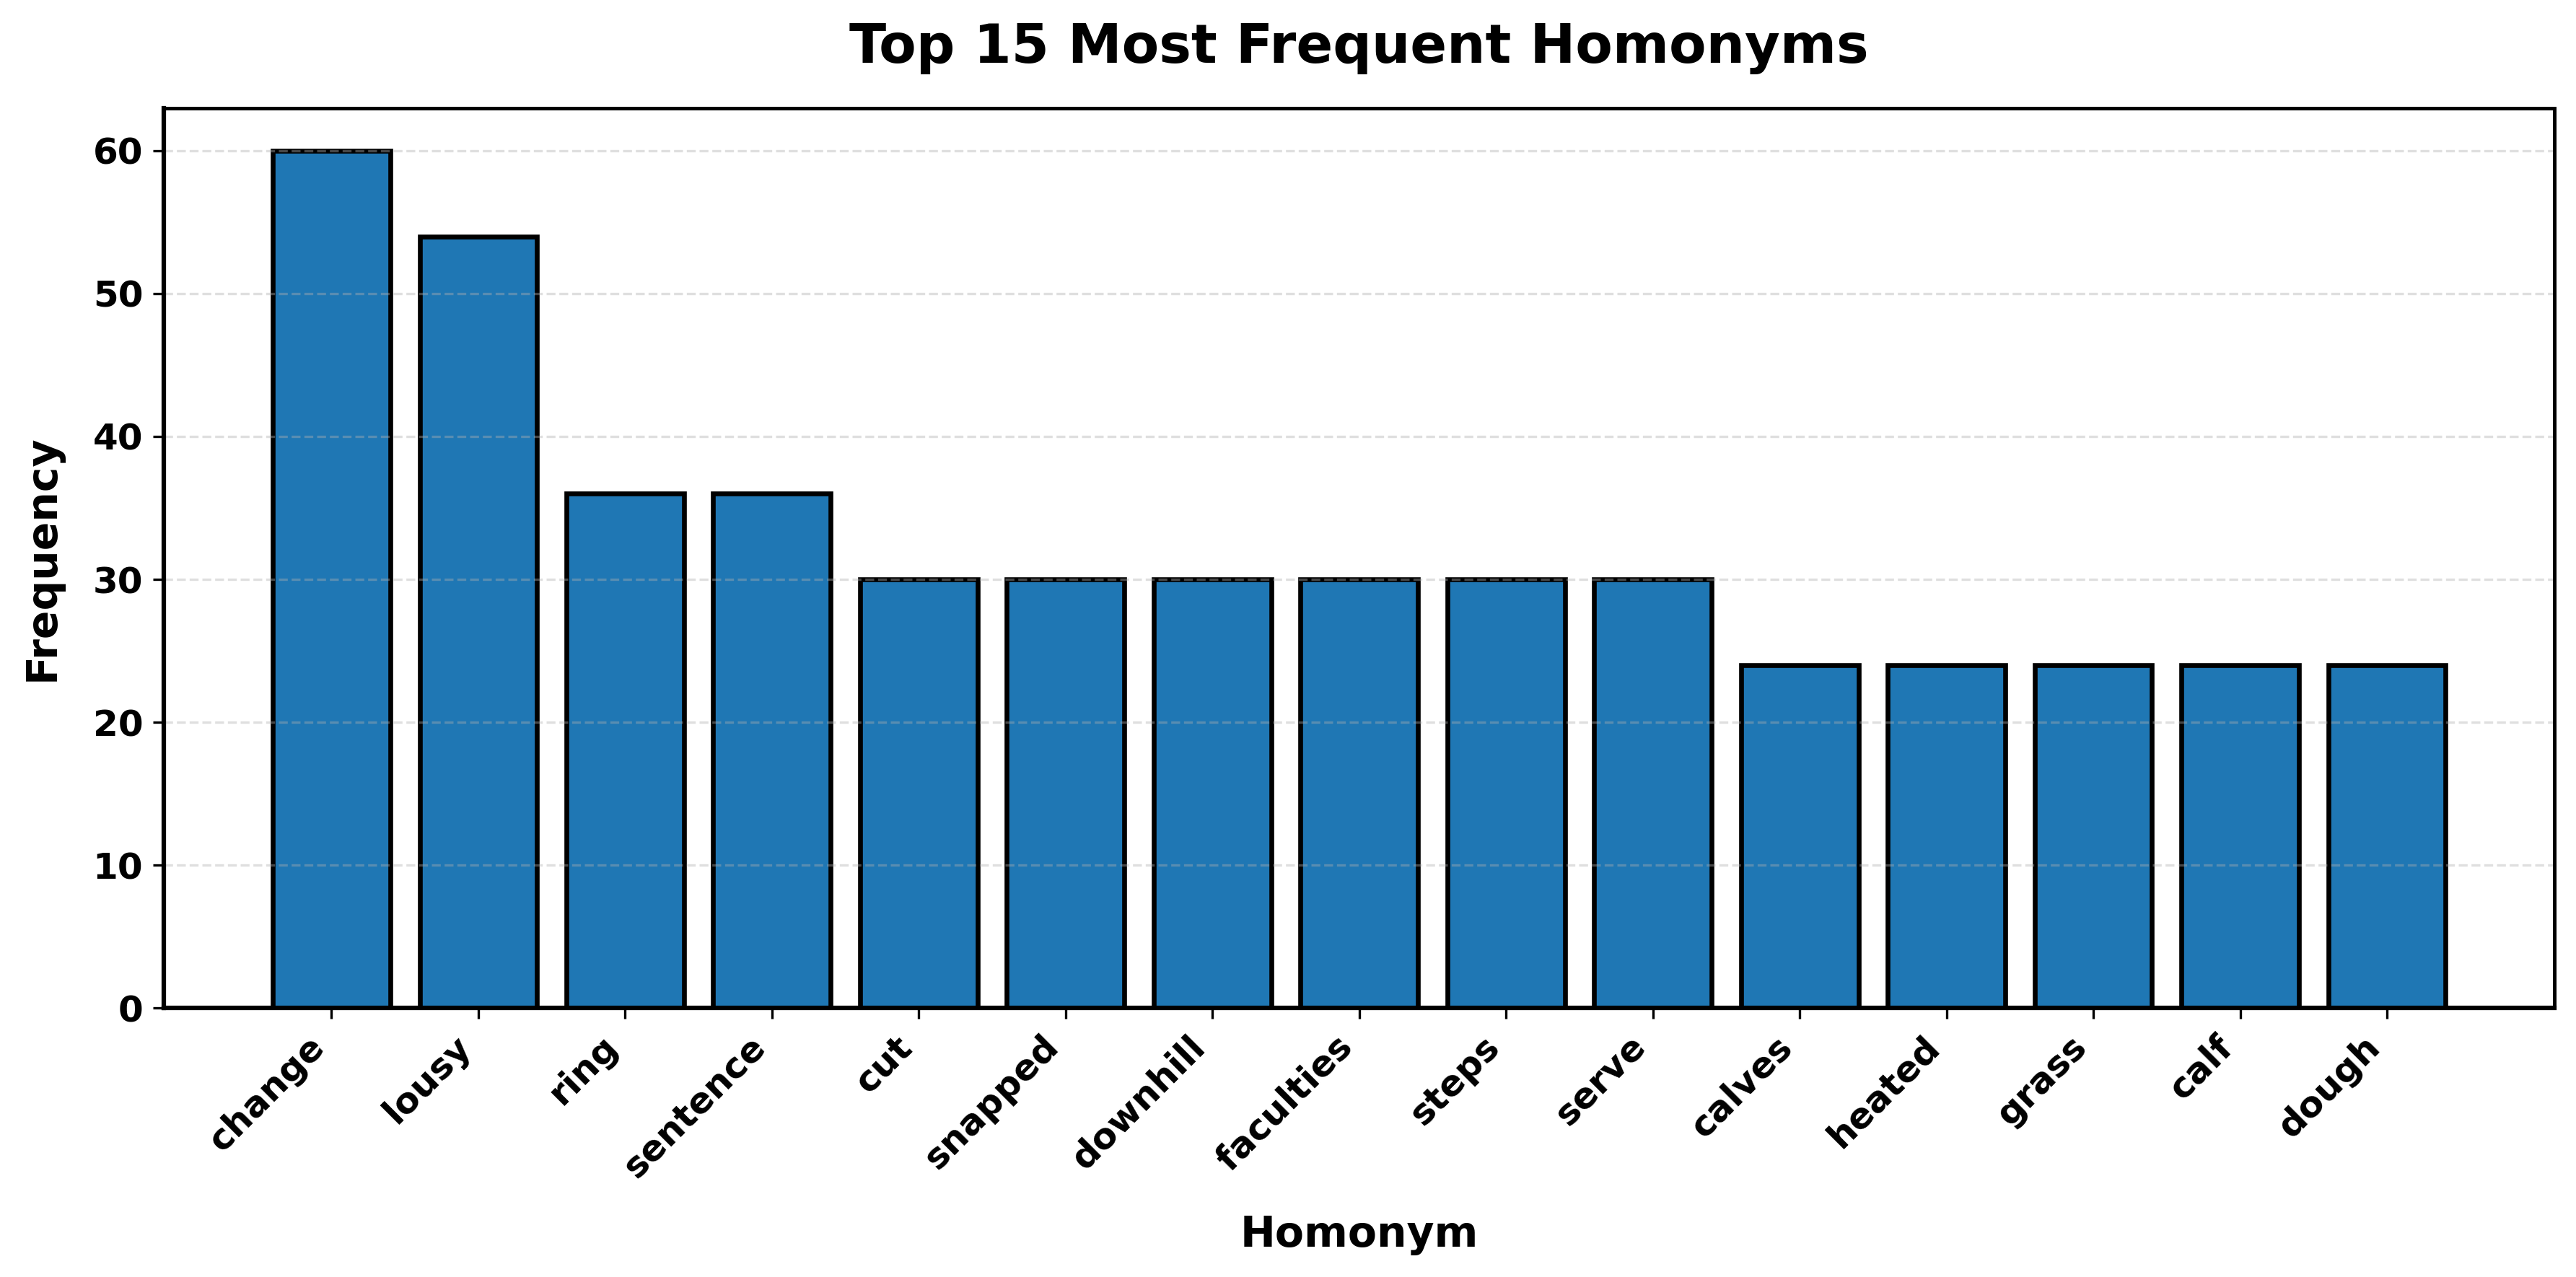

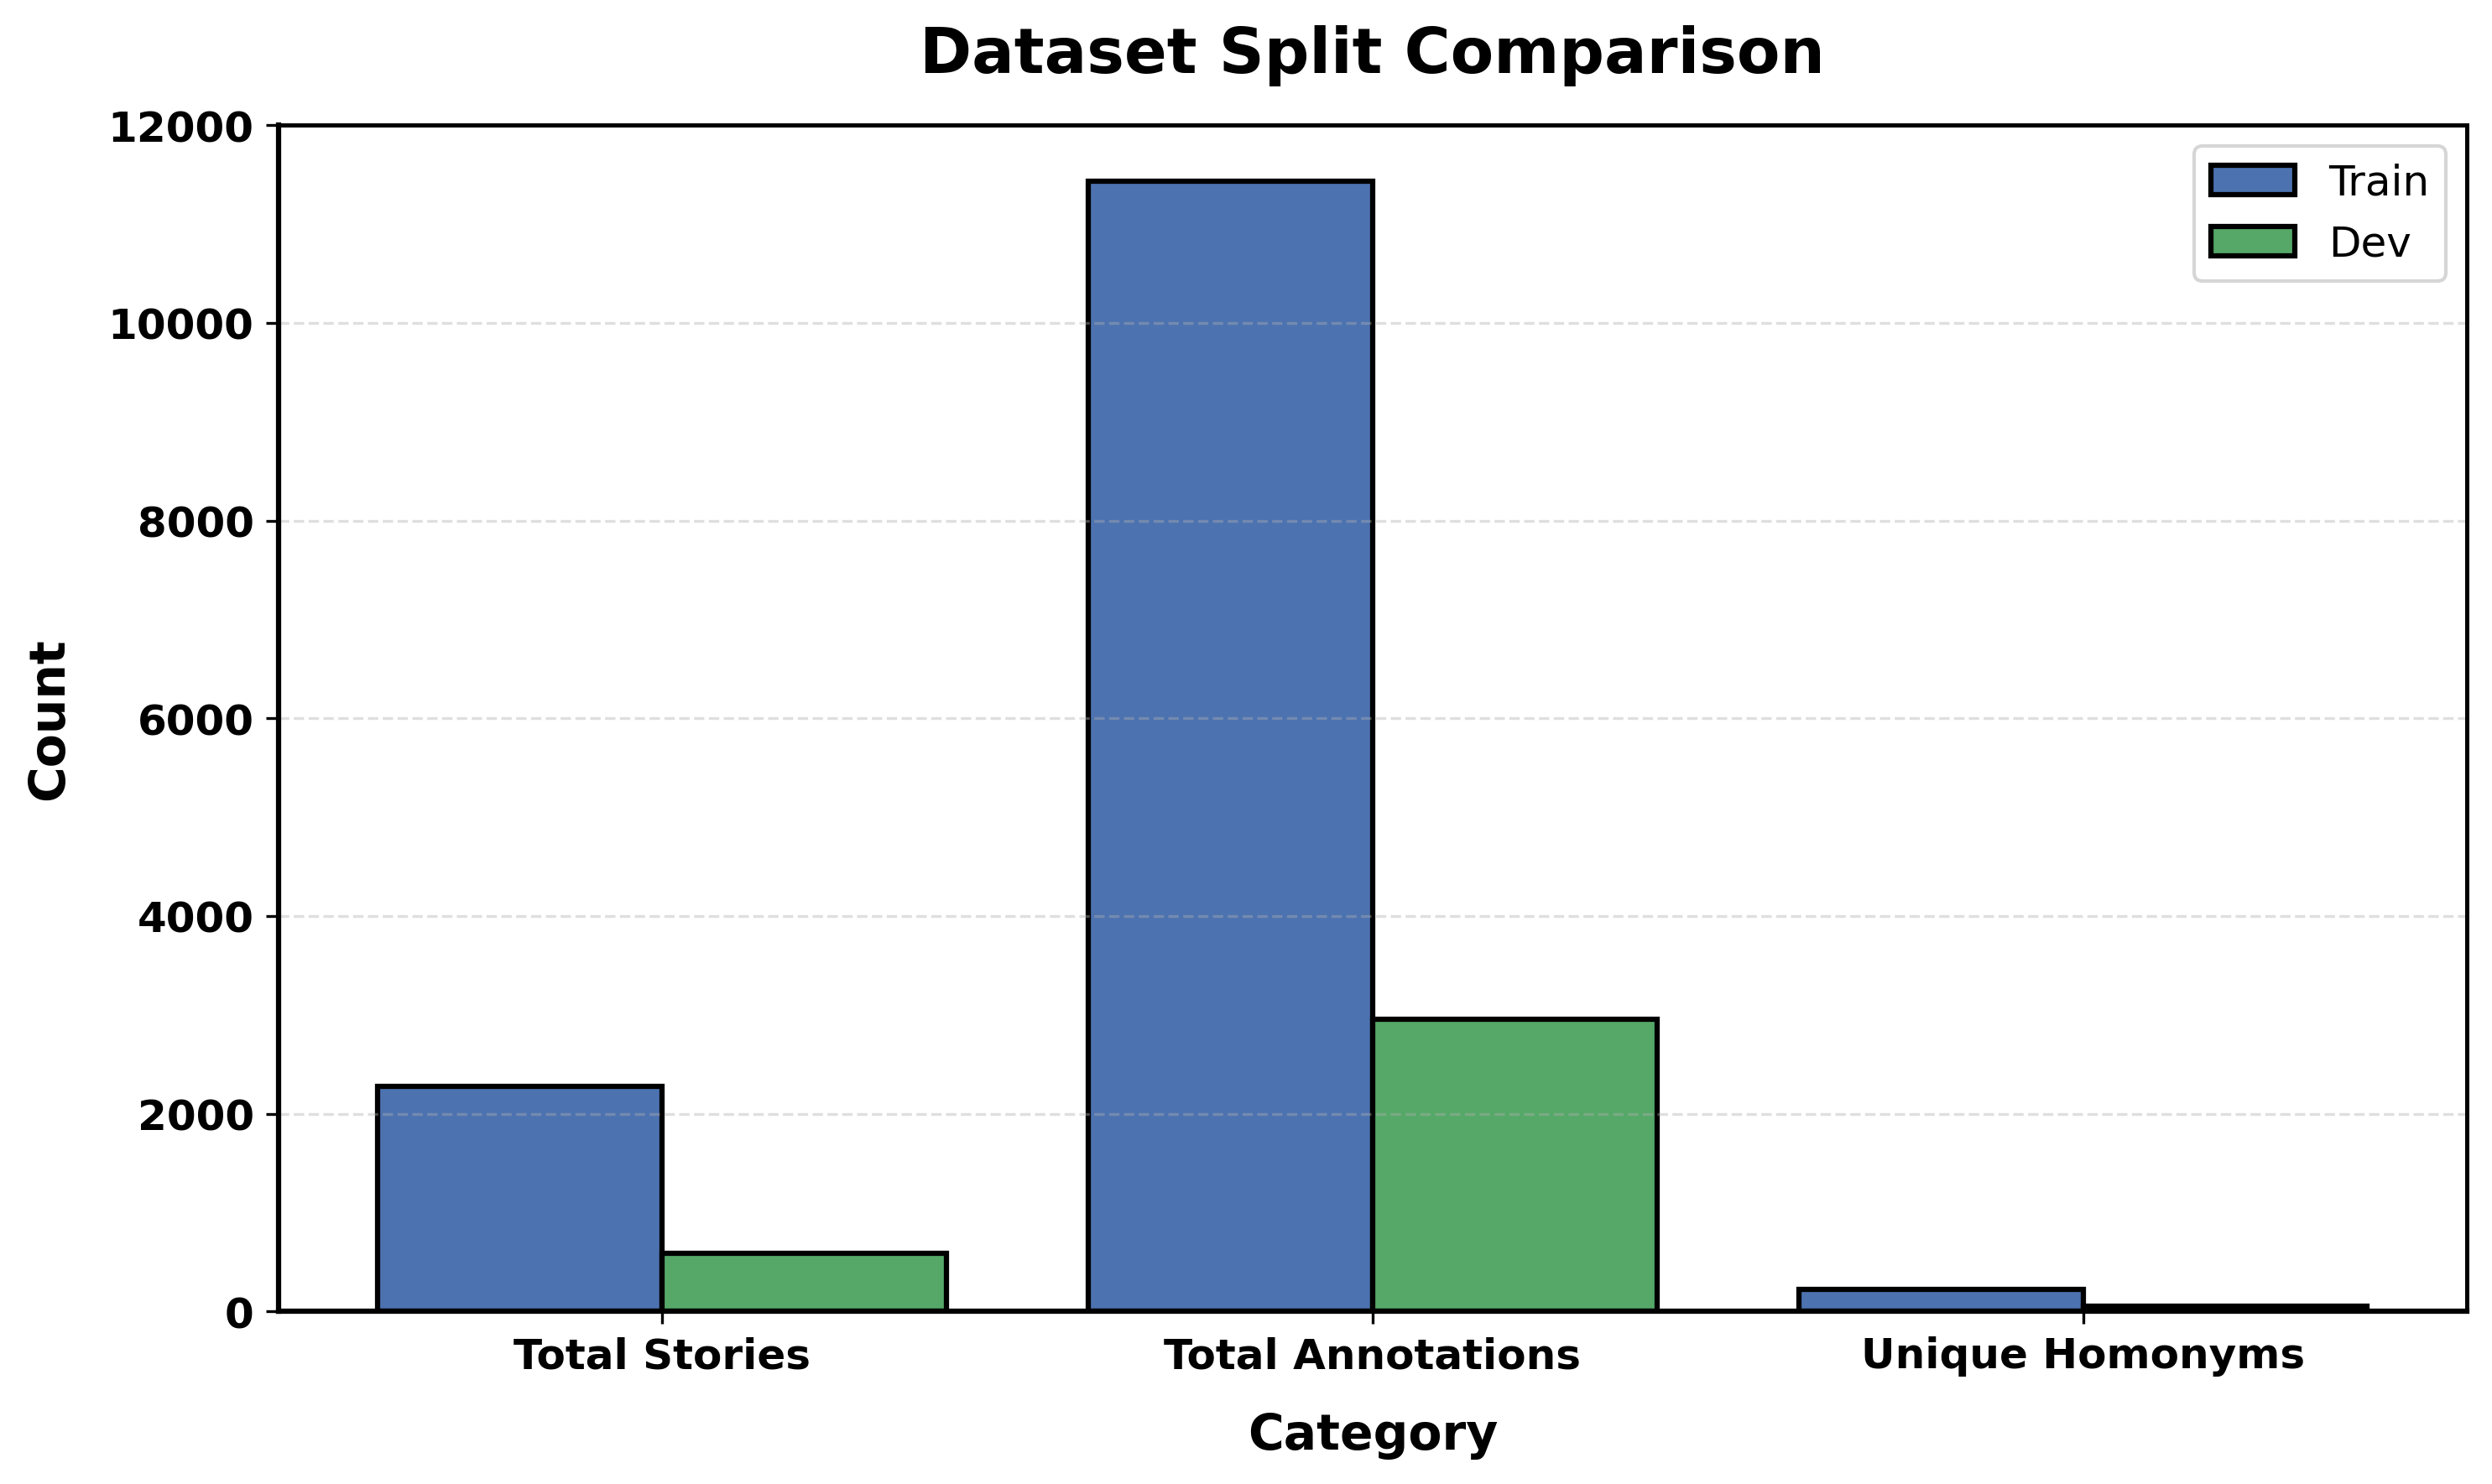

In [13]:


os.makedirs('plots', exist_ok=True)

plt.figure(figsize=(12, 6), dpi=300)

top_15 = homonym_df.head(15)

bars = plt.bar(
    top_15['Homonym'],
    top_15['Count'],
    edgecolor='black',
    linewidth=1.6
)

plt.title('Top 15 Most Frequent Homonyms', fontsize=18, weight='bold', pad=15)

plt.xlabel('Homonym', fontsize=14, weight='bold', labelpad=10)
plt.ylabel('Frequency', fontsize=14, weight='bold', labelpad=10)

plt.xticks(rotation=45, ha='right', fontsize=12, weight='bold')
plt.yticks(fontsize=12, weight='bold')

ax = plt.gca()
ax.spines['bottom'].set_linewidth(1.5)
ax.spines['left'].set_linewidth(1.5)
ax.spines['top'].set_linewidth(1.2)
ax.spines['right'].set_linewidth(1.2)

plt.grid(axis='y', linestyle='--', alpha=0.4)

plt.tight_layout()
plt.savefig('plots/homonym_frequency.png', format='png')
plt.show()

plt.figure(figsize=(10, 6), dpi=300)

categories = ['Total Stories', 'Total Annotations', 'Unique Homonyms']
train_values = [train_dims[0], train_dims[1], train_dims[2]]
dev_values = [dev_dims[0], dev_dims[1], dev_dims[2]]

x = range(len(categories))

bar1 = plt.bar(
    x,
    train_values,
    width=0.4,
    label='Train',
    color='#4C72B0',
    edgecolor='black',
    linewidth=1.5
)

bar2 = plt.bar(
    [i + 0.4 for i in x],
    dev_values,
    width=0.4,
    label='Dev',
    color='#55A868',
    edgecolor='black',
    linewidth=1.5
)

plt.title('Dataset Split Comparison', fontsize=18, weight='bold', pad=15)

plt.xlabel('Category', fontsize=14, weight='bold', labelpad=10)
plt.ylabel('Count', fontsize=14, weight='bold', labelpad=10)

plt.xticks([i + 0.2 for i in x], categories, fontsize=12, weight='bold')
plt.yticks(fontsize=12, weight='bold')

ax = plt.gca()
ax.spines['bottom'].set_linewidth(1.5)
ax.spines['left'].set_linewidth(1.5)
ax.spines['top'].set_linewidth(1.2)
ax.spines['right'].set_linewidth(1.2)

plt.legend(fontsize=12)

plt.grid(axis='y', linestyle='--', alpha=0.4)

plt.tight_layout()
plt.savefig('plots/dataset_comparison.png', format='png')
plt.show()


## Overall Summary Table

In [14]:
summary_data = {
    'Metric': [
        'Total Stories',
        'Total Annotations',
        'Unique Homonyms',
        'Stories with Endings',
        'Stories without Endings',
        'Overall Average Rating',
        'Min Story Average',
        'Max Story Average',
        'Global Average StDev'
    ],
    'Value': [
        len(all_data),
        sum(len(content['choices']) for content in all_data.values()),
        len(homonym_df),
        ending_stats[0],
        ending_stats[1],
        f"{sum(ratings)/len(ratings):.2f}",
        f"{min(averages):.2f}",
        f"{max(averages):.2f}",
        f"{sum(stdevs)/len(stdevs):.2f}"
    ]
}

summary_df = pd.DataFrame(summary_data)
print("\nSummary Table for Report")
print(summary_df)


Summary Table for Report
                    Metric  Value
0            Total Stories   2868
1        Total Annotations  14386
2          Unique Homonyms    275
3     Stories with Endings   1912
4  Stories without Endings    956
5   Overall Average Rating   3.13
6        Min Story Average   1.00
7        Max Story Average   5.00
8     Global Average StDev   0.95


## Rating Distribution & Human Agreement Analysis



In [15]:
ratings_df = pd.DataFrame([
    {
        "story_id": sid,
        "rater1": d["choices"][0],
        "rater2": d["choices"][1],
        "rater3": d["choices"][2],
        "rater4": d["choices"][3],
        "rater5": d["choices"][4],
    }
    for sid, d in all_data.items()
])
print(ratings_df)

     story_id  rater1  rater2  rater3  rater4  rater5
0     train_0       4       5       2       3       1
1     train_1       5       3       4       4       3
2     train_2       2       1       4       3       1
3     train_3       4       5       5       3       5
4     train_4       1       1       4       4       3
...       ...     ...     ...     ...     ...     ...
2863  dev_583       1       1       3       1       1
2864  dev_584       2       5       1       1       1
2865  dev_585       4       5       5       5       4
2866  dev_586       3       2       1       3       2
2867  dev_587       2       3       3       3       1

[2868 rows x 6 columns]


#Overall Rating Distribution

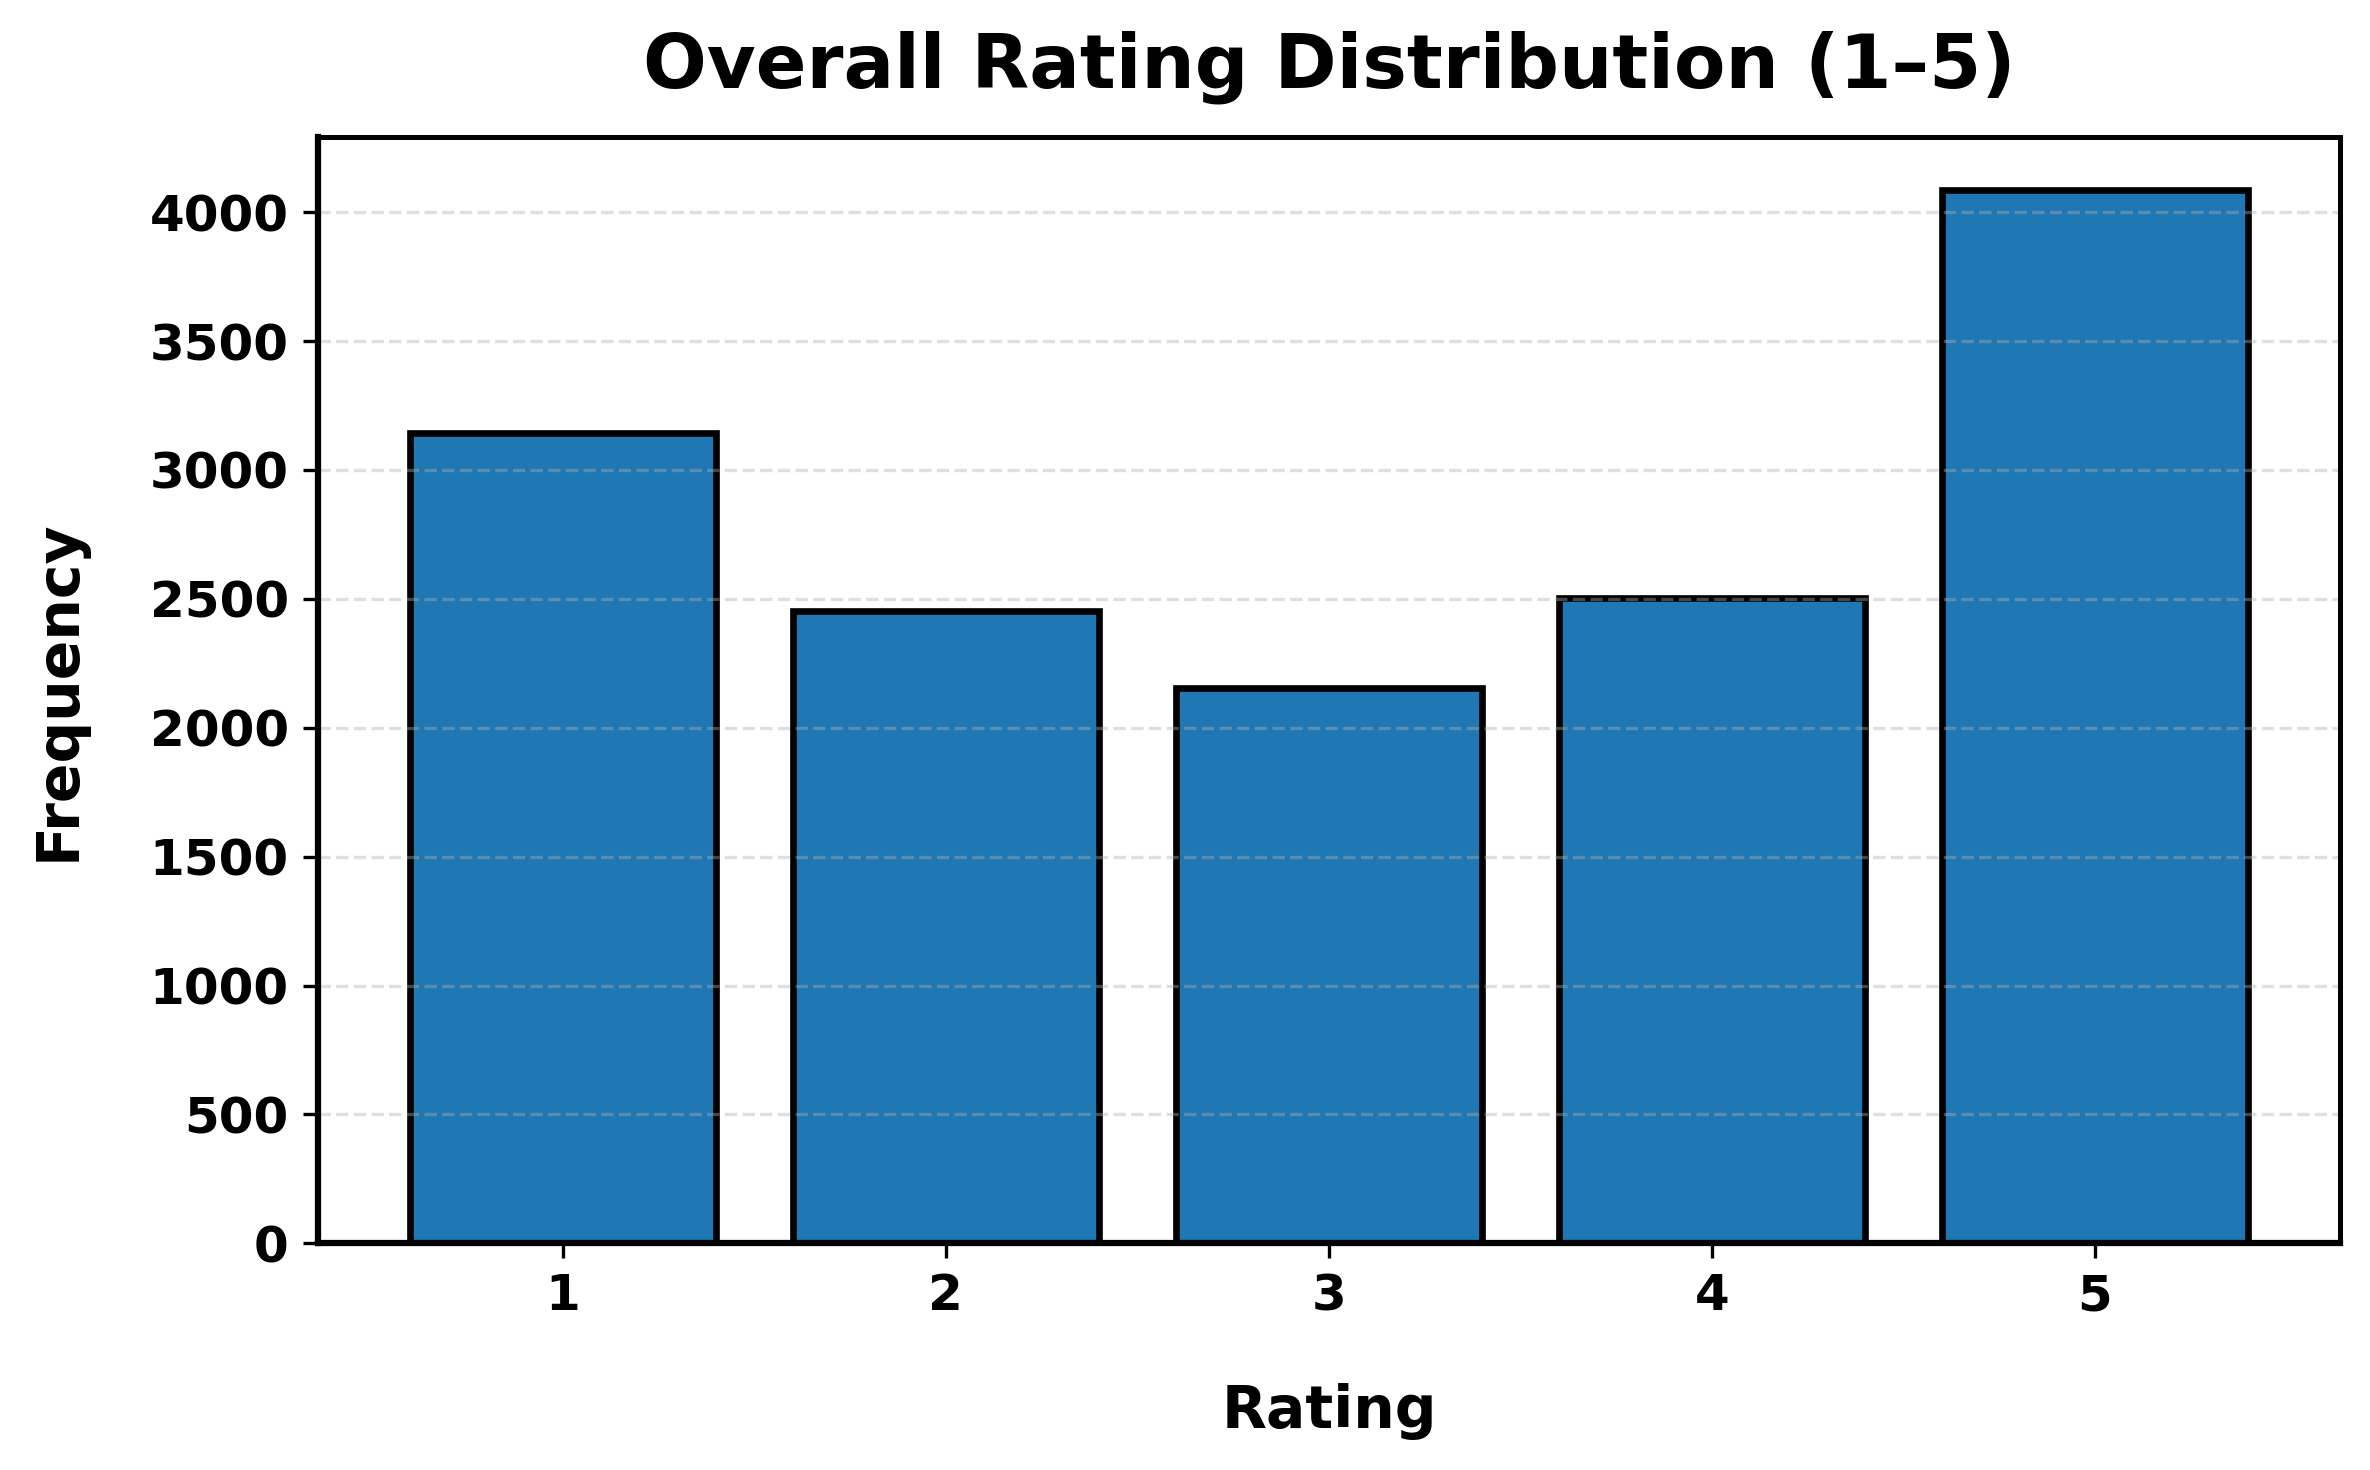

In [16]:
os.makedirs('plots', exist_ok=True)

all_ratings = ratings_df[["rater1","rater2","rater3","rater4","rater5"]].values.flatten()

unique, counts = np.unique(all_ratings, return_counts=True)

plt.figure(figsize=(8, 5), dpi=300)

bars = plt.bar(
    unique,
    counts,
    edgecolor='black',
    linewidth=1.6
)

plt.title("Overall Rating Distribution (1–5)", fontsize=18, weight="bold", pad=12)
plt.xlabel("Rating", fontsize=14, weight="bold", labelpad=15)
plt.ylabel("Frequency", fontsize=14, weight="bold", labelpad=15)
plt.xticks(unique, fontsize=12, weight="bold")
plt.yticks(fontsize=12, weight="bold")

ax = plt.gca()
ax.spines['bottom'].set_linewidth(1.5)
ax.spines['left'].set_linewidth(1.5)
ax.spines['top'].set_linewidth(1.2)
ax.spines['right'].set_linewidth(1.2)

plt.grid(axis='y', linestyle='--', alpha=0.4)
plt.tight_layout()

plt.savefig('plots/rating_distribution.png', format='png')
plt.show()


#High / Medium / Low Rating Percentages

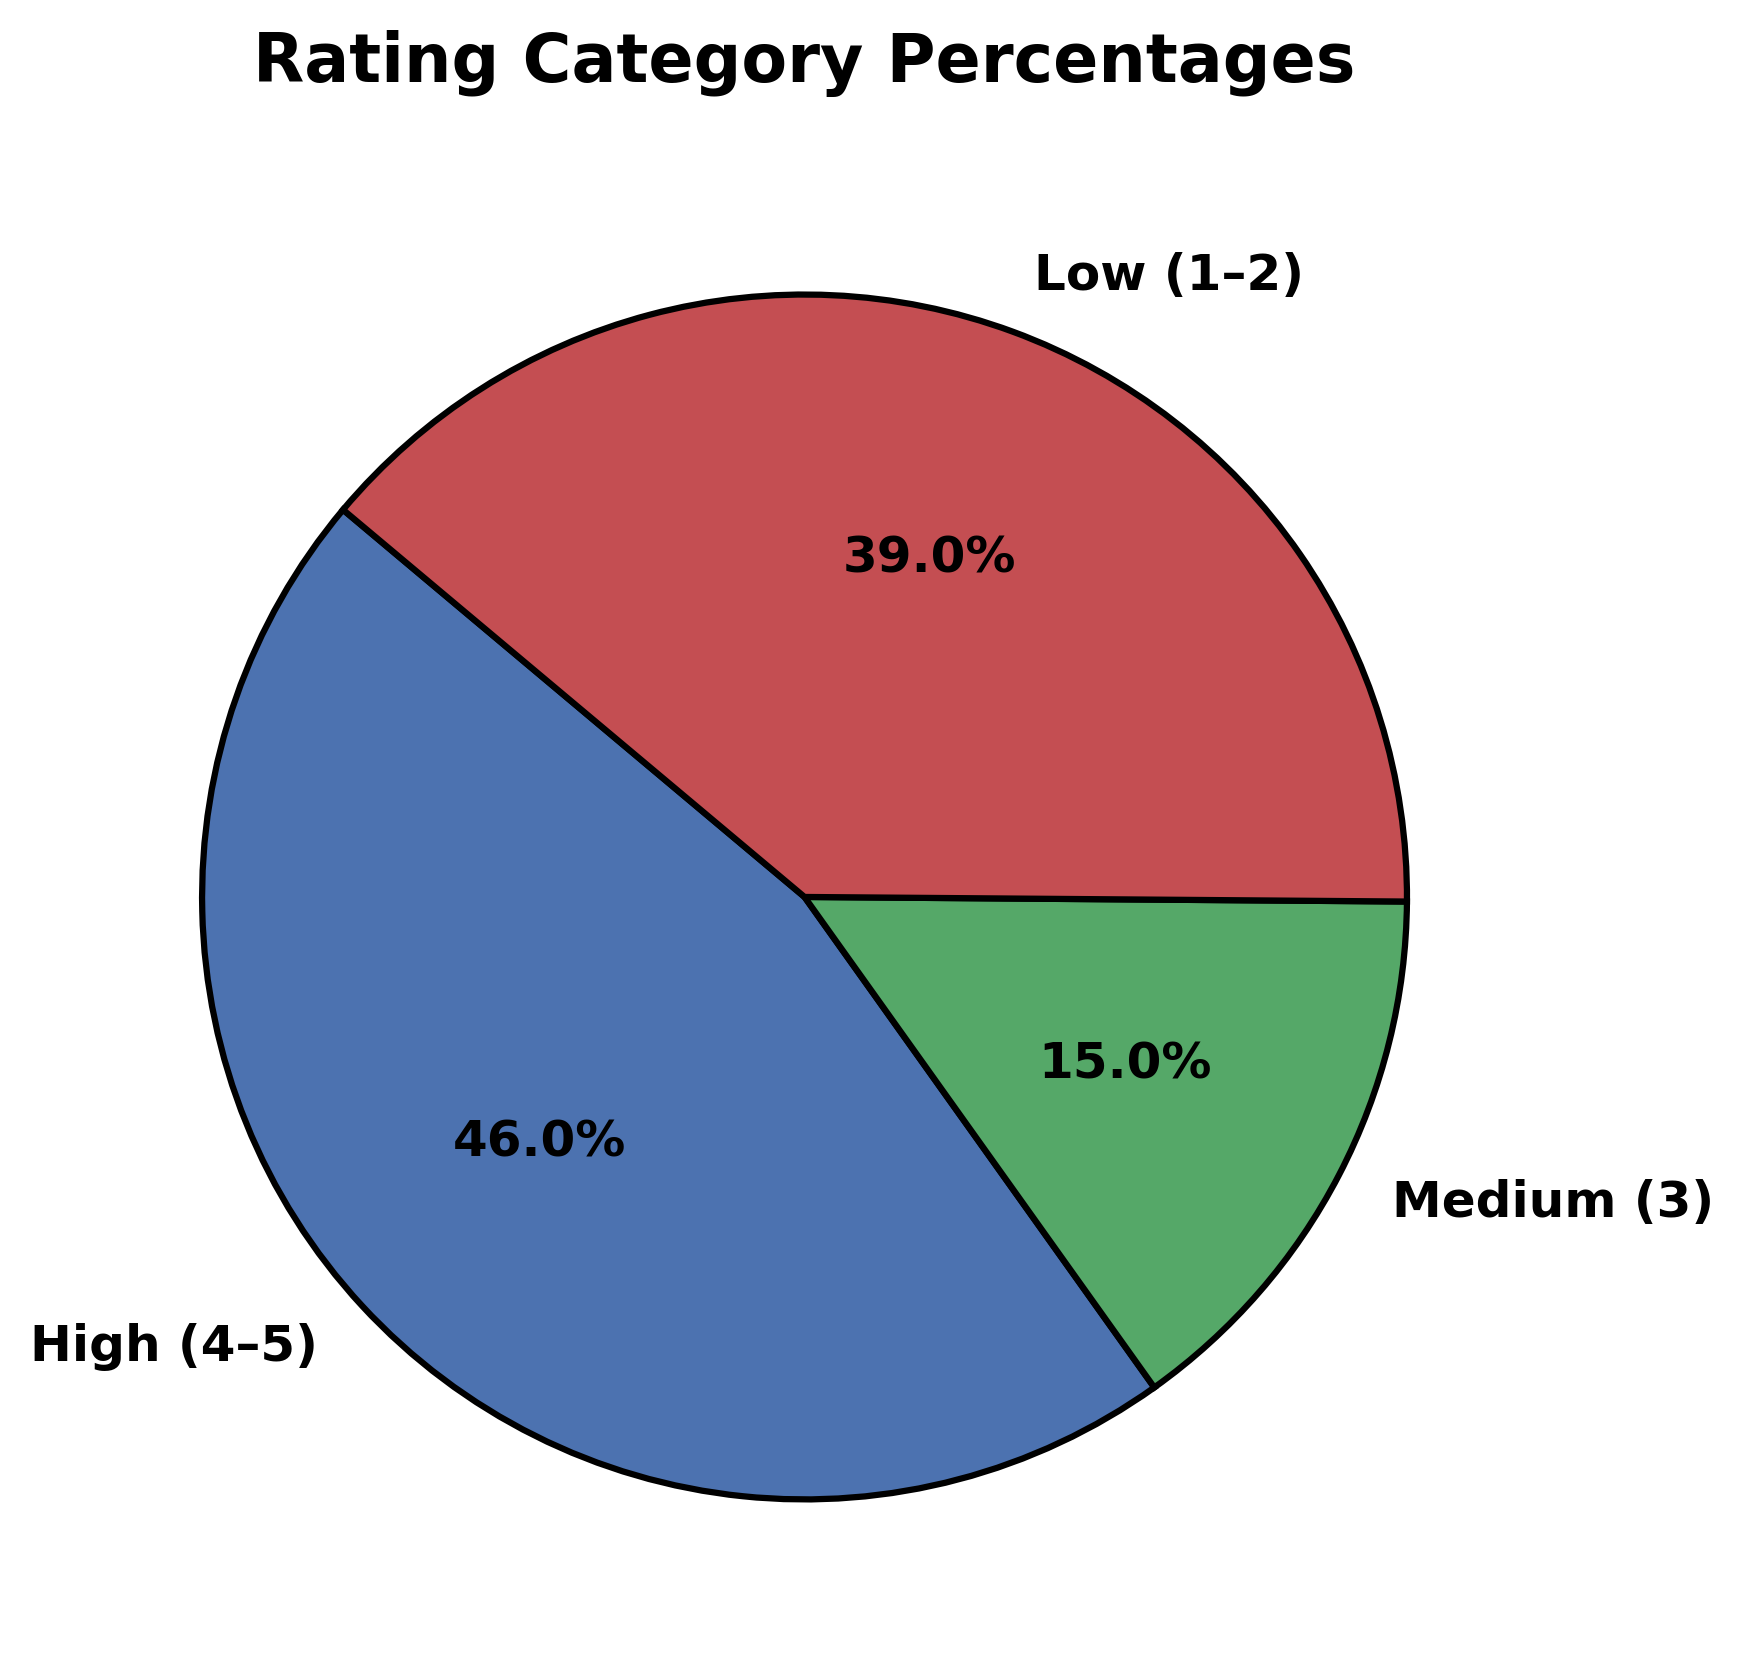

In [17]:

os.makedirs('plots', exist_ok=True)

rating_counts = pd.Series(all_ratings).value_counts().sort_index()
high = rating_counts.loc[[4,5]].sum()
medium = rating_counts.loc[3]
low = rating_counts.loc[[1,2]].sum()

sizes = [high, medium, low]
labels = ["High (4–5)", "Medium (3)", "Low (1–2)"]
colors = ["#4C72B0", "#55A868", "#C44E52"]

plt.figure(figsize=(6,6), dpi=300)
plt.pie(
    sizes,
    labels=labels,
    autopct="%1.1f%%",
    startangle=140,
    colors=colors,
    wedgeprops={'edgecolor':'black', 'linewidth':1.5},
    textprops={'fontsize':12, 'weight':'bold'}
)
plt.title("Rating Category Percentages", fontsize=16, weight='bold', pad=15)
plt.tight_layout()
plt.savefig('plots/rating_category_percentages.png', format='png')
plt.show()


#Human Agreement

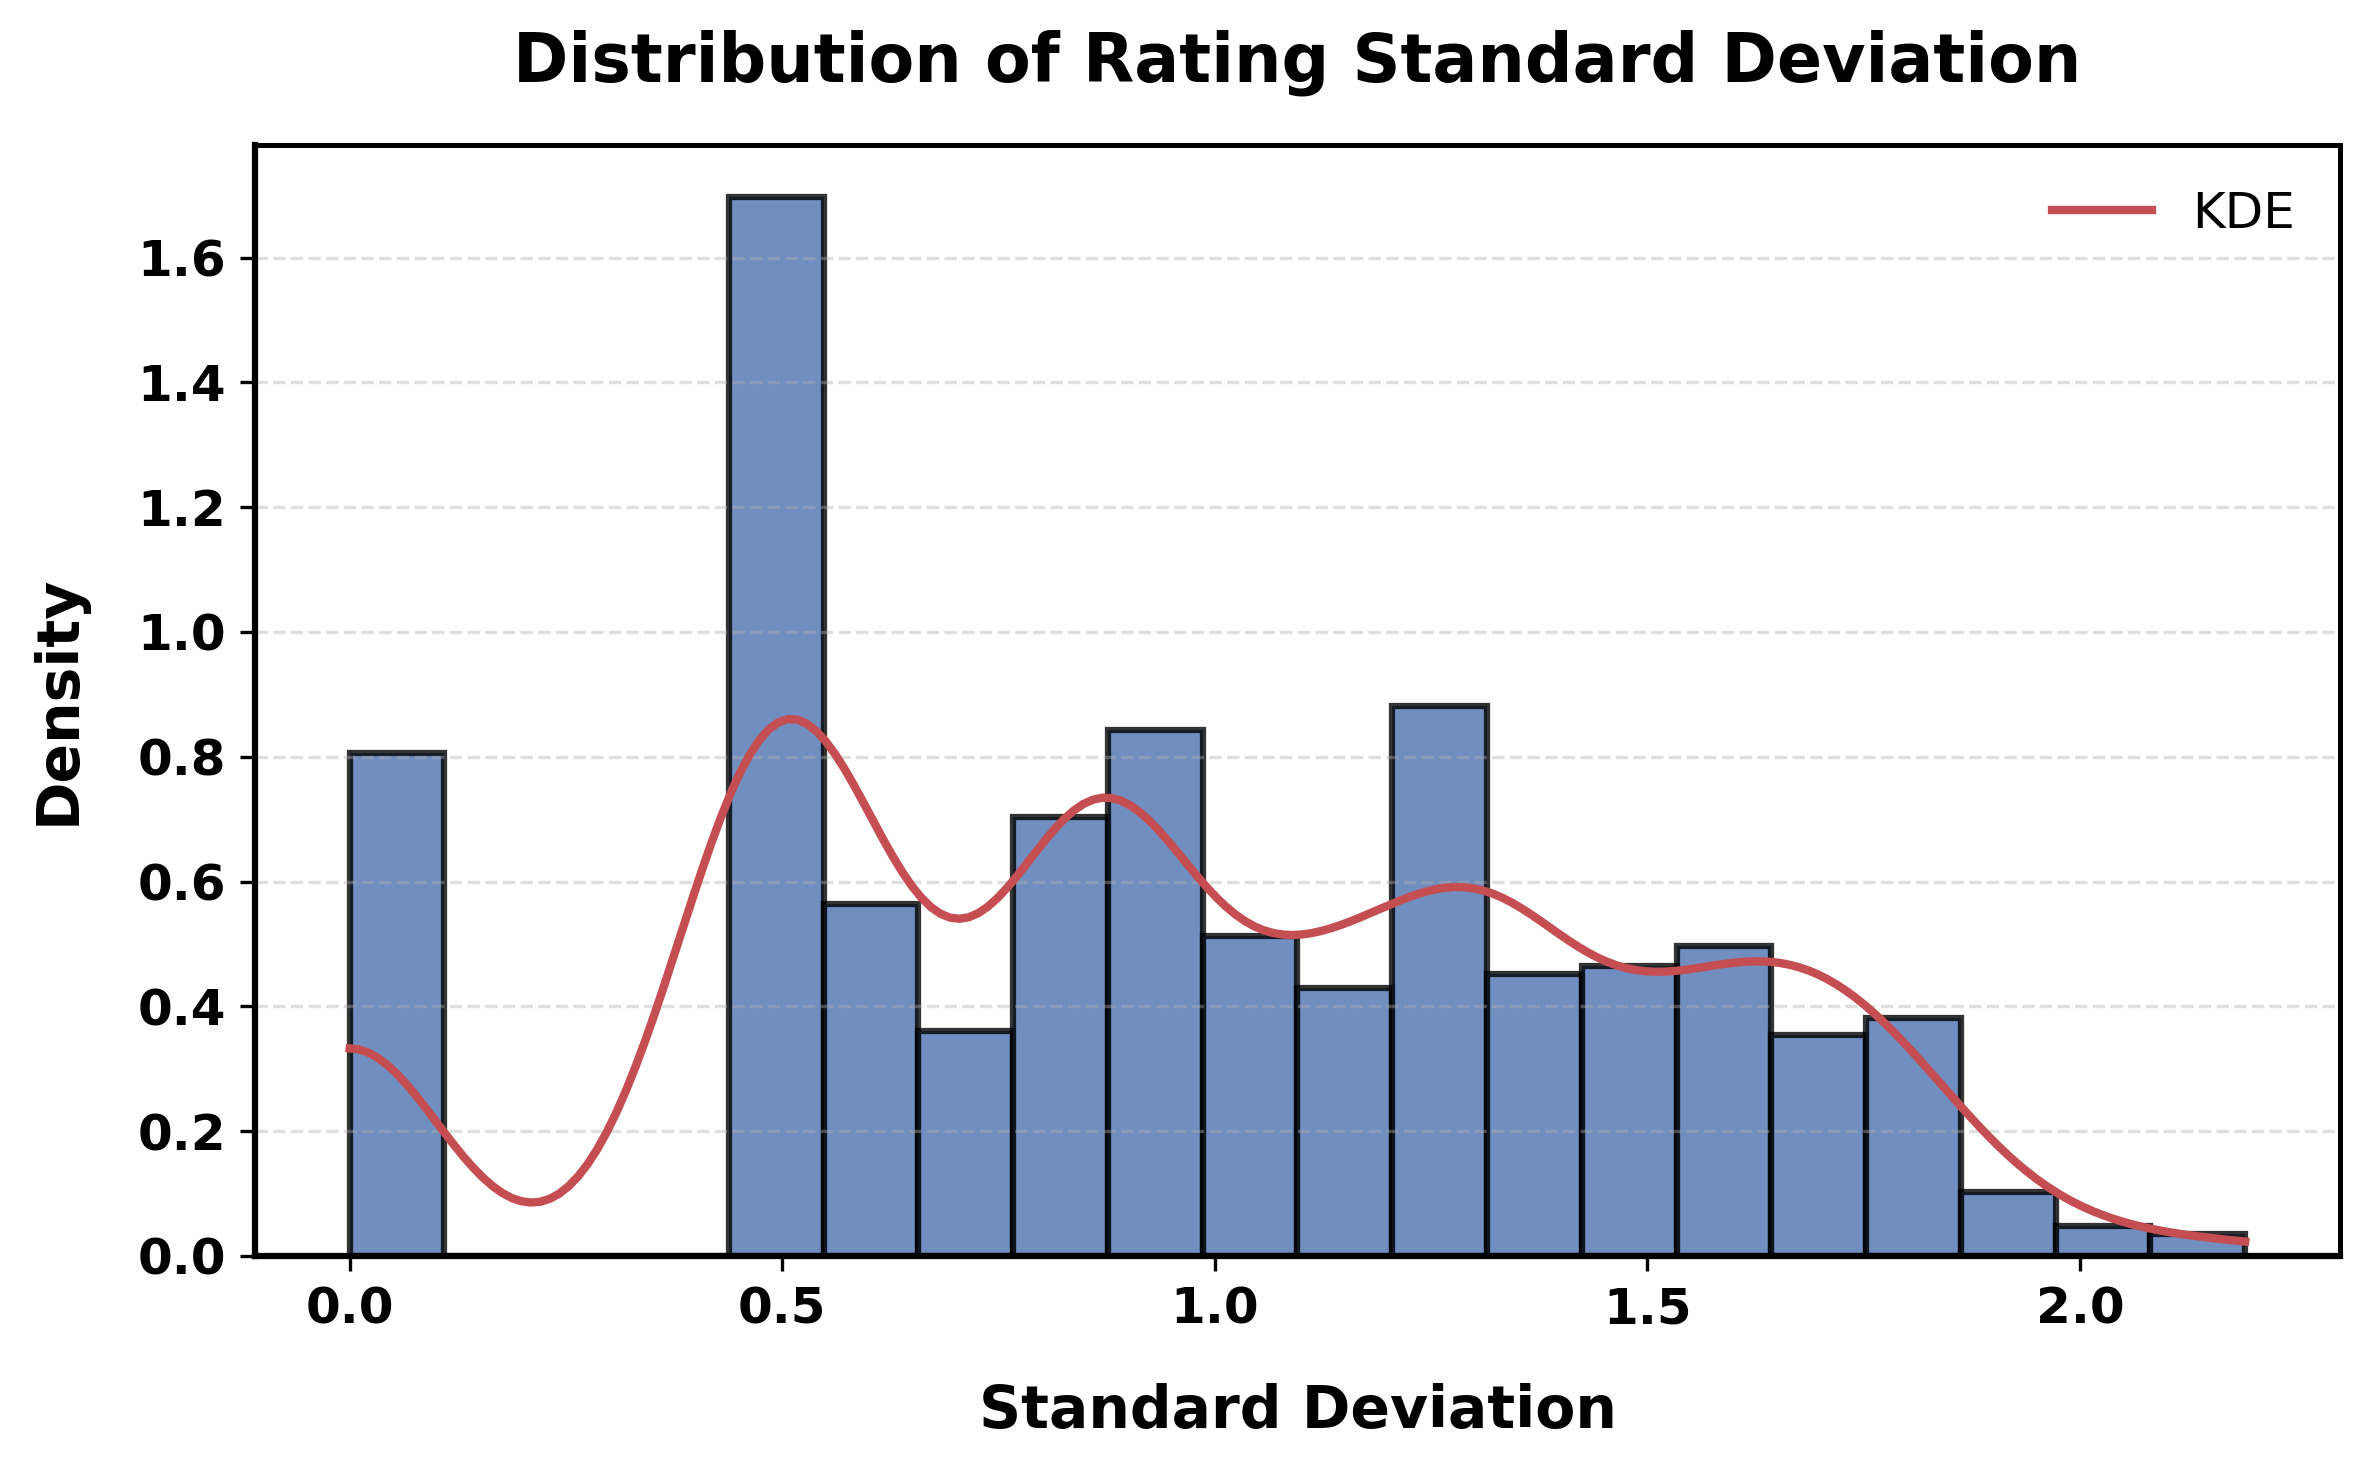

In [18]:
os.makedirs('plots', exist_ok=True)

ratings_df["std"] = ratings_df[["rater1","rater2","rater3","rater4","rater5"]].std(axis=1)

data = ratings_df["std"].values

plt.figure(figsize=(8,5), dpi=300)

counts, bins, patches = plt.hist(
    data,
    bins=20,
    edgecolor='black',
    linewidth=1.5,
    alpha=0.8,
    color='#4C72B0',
    density=True
)

kde = gaussian_kde(data)
x_vals = np.linspace(min(data), max(data), 200)
plt.plot(x_vals, kde(x_vals), color='#C44E52', linewidth=2, label='KDE')

plt.title("Distribution of Rating Standard Deviation", fontsize=16, weight='bold', pad=15)
plt.xlabel("Standard Deviation", fontsize=14, weight='bold', labelpad=12)
plt.ylabel("Density", fontsize=14, weight='bold', labelpad=12)
plt.xticks(fontsize=12, weight='bold')
plt.yticks(fontsize=12, weight='bold')

ax = plt.gca()
ax.spines['bottom'].set_linewidth(1.5)
ax.spines['left'].set_linewidth(1.5)
ax.spines['top'].set_linewidth(1.2)
ax.spines['right'].set_linewidth(1.2)

plt.grid(axis='y', linestyle='--', alpha=0.4)
plt.legend(fontsize=12, frameon=False)
plt.tight_layout()
plt.savefig('plots/rating_std_distribution.png', format='png')
plt.show()


#Agreement Categories

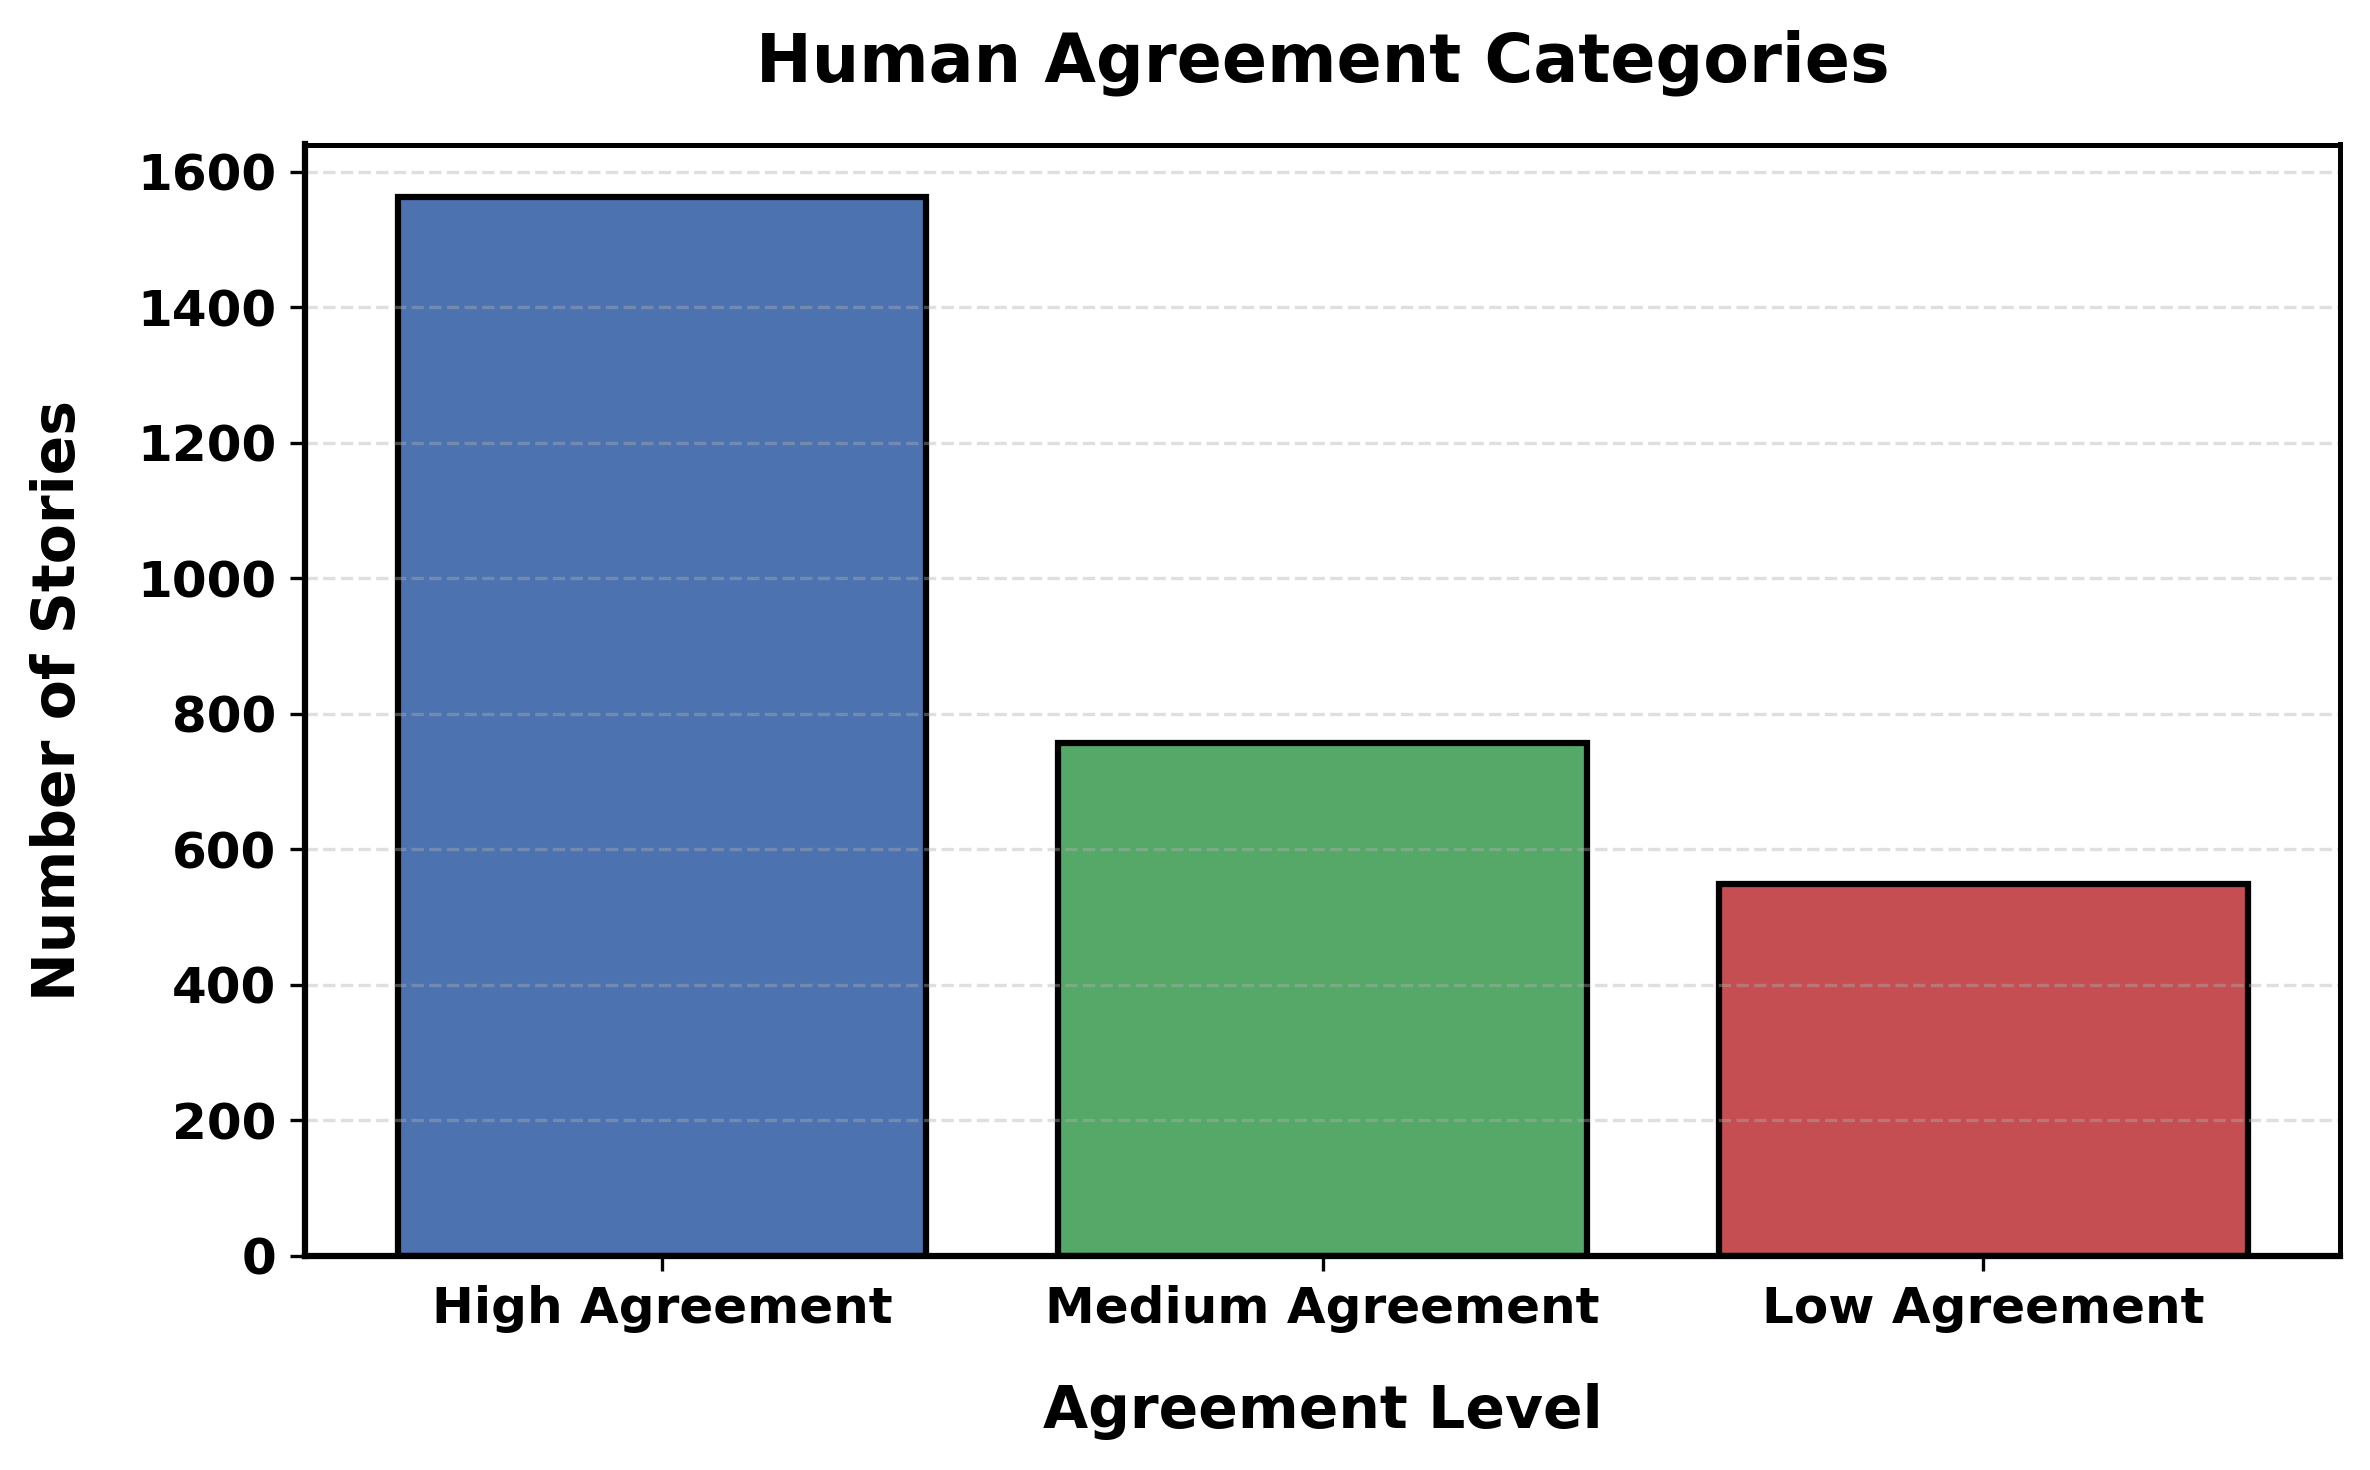

In [19]:
os.makedirs('plots', exist_ok=True)

def agreement(sd):
    if sd < 1.0:
        return "High Agreement"
    elif sd <= 1.5:
        return "Medium Agreement"
    return "Low Agreement"

ratings_df["agreement"] = ratings_df["std"].apply(agreement)

agreement_counts = ratings_df["agreement"].value_counts().reindex(["High Agreement", "Medium Agreement", "Low Agreement"])

plt.figure(figsize=(8,5), dpi=300)

bars = plt.bar(
    agreement_counts.index,
    agreement_counts.values,
    color=['#4C72B0','#55A868','#C44E52'],
    edgecolor='black',
    linewidth=1.5
)

plt.title("Human Agreement Categories", fontsize=16, weight='bold', pad=15)
plt.xlabel("Agreement Level", fontsize=14, weight='bold', labelpad=12)
plt.ylabel("Number of Stories", fontsize=14, weight='bold', labelpad=12)
plt.xticks(fontsize=12, weight='bold')
plt.yticks(fontsize=12, weight='bold')

ax = plt.gca()
ax.spines['bottom'].set_linewidth(1.5)
ax.spines['left'].set_linewidth(1.5)
ax.spines['top'].set_linewidth(1.2)
ax.spines['right'].set_linewidth(1.2)

plt.grid(axis='y', linestyle='--', alpha=0.4)
plt.tight_layout()
plt.savefig('plots/human_agreement_categories.png', format='png')
plt.show()


#Unanimous Ratings vs Maximum-Disagreement

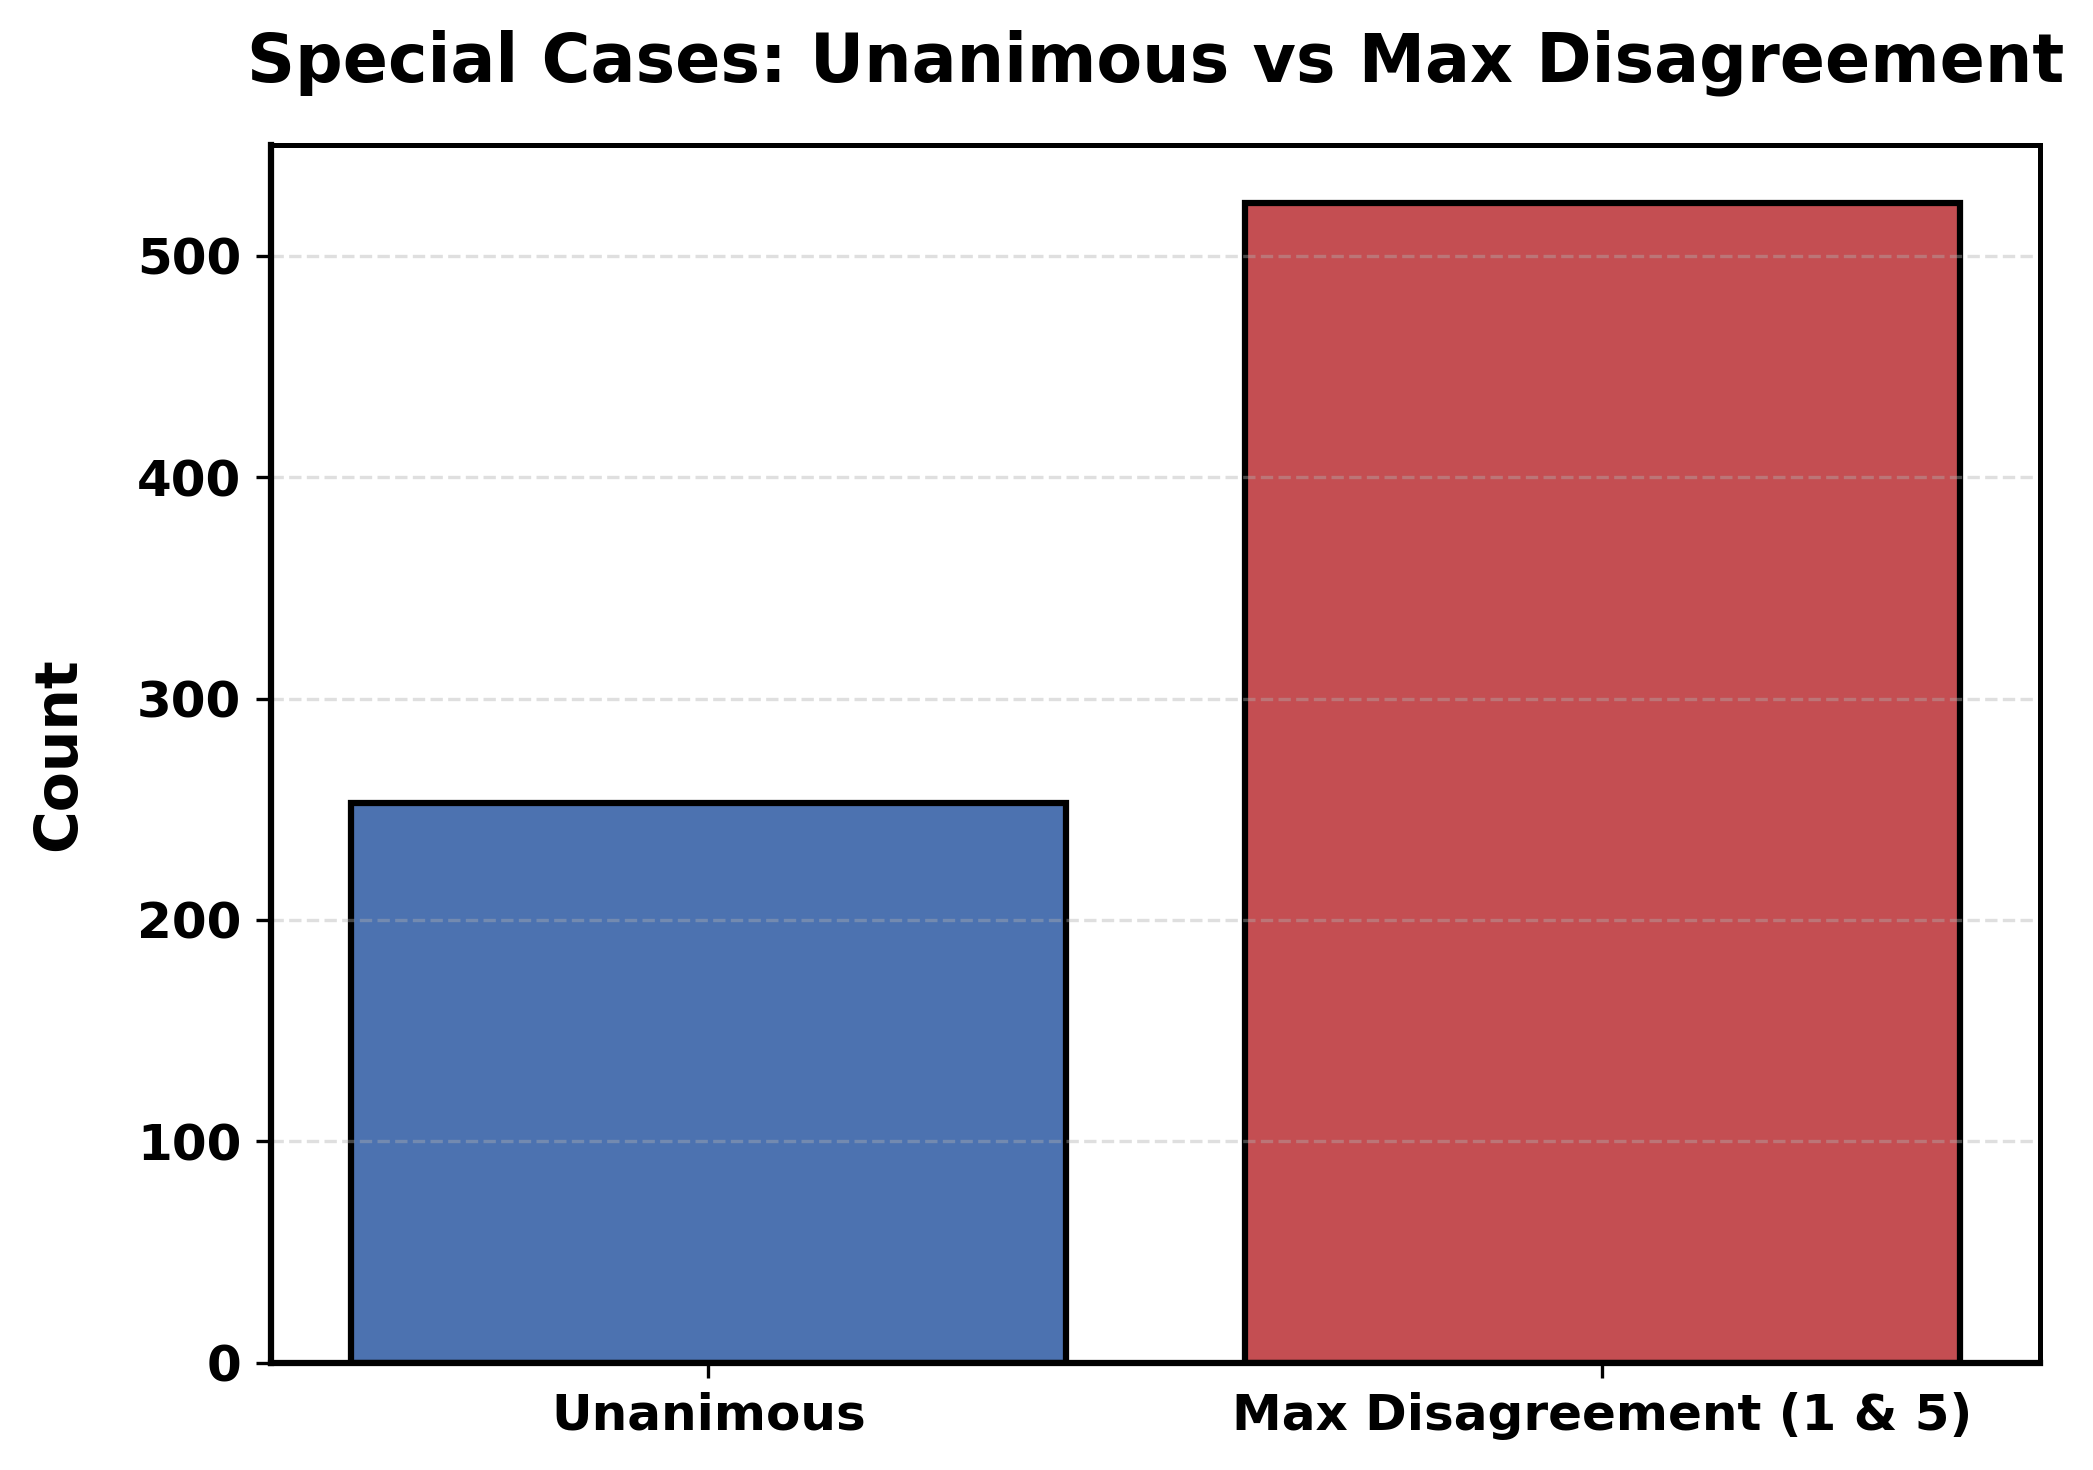

In [20]:
os.makedirs('plots', exist_ok=True)

def unanimous(row):
    return len(set(row)) == 1

def has_1_and_5(row):
    s = set(row)
    return (1 in s) and (5 in s)

ratings_df["is_unanimous"] = ratings_df[["rater1","rater2","rater3","rater4","rater5"]].apply(unanimous, axis=1)
ratings_df["has_1_and_5"] = ratings_df[["rater1","rater2","rater3","rater4","rater5"]].apply(has_1_and_5, axis=1)

labels = ["Unanimous", "Max Disagreement (1 & 5)"]
values = [
    ratings_df["is_unanimous"].sum(),
    ratings_df["has_1_and_5"].sum()
]

plt.figure(figsize=(7,5), dpi=300)

bars = plt.bar(
    labels,
    values,
    color=['#4C72B0', '#C44E52'],
    edgecolor='black',
    linewidth=1.5
)

plt.title("Special Cases: Unanimous vs Max Disagreement", fontsize=16, weight='bold', pad=15)
plt.xlabel("")
plt.ylabel("Count", fontsize=14, weight='bold', labelpad=12)
plt.xticks(fontsize=12, weight='bold')
plt.yticks(fontsize=12, weight='bold')

ax = plt.gca()
ax.spines['bottom'].set_linewidth(1.5)
ax.spines['left'].set_linewidth(1.5)
ax.spines['top'].set_linewidth(1.2)
ax.spines['right'].set_linewidth(1.2)

plt.grid(axis='y', linestyle='--', alpha=0.4)
plt.tight_layout()
plt.savefig('plots/unanimous_vs_max_disagreement.png', format='png')
plt.show()


## Context Length Analysis

In [21]:
def word_count(text):
    if not isinstance(text, str):
        return 0
    return len(text.split())

precontext_lengths = []
sentence_lengths = []
ending_lengths = []

agreement_scores = []

for story_id, content in all_data.items():

    precontext_lengths.append(word_count(content.get("precontext", "")))
    sentence_lengths.append(word_count(content.get("sentence", "")))

    ending = content.get("ending", "")
    if ending and ending.strip():
        ending_lengths.append(word_count(ending))

    agreement_scores.append(content.get("stdev", 0))

context_df = pd.DataFrame({
    "precontext_len": precontext_lengths,
    "sentence_len": sentence_lengths,
    "ending_len": ending_lengths + [np.nan]*(len(precontext_lengths)-len(ending_lengths)),
    "agreement": agreement_scores
})

print("\nContext Length Summary")
print(f"Average Precontext Word Count: {context_df['precontext_len'].mean():.2f}")
print(f"Average Sentence Word Count: {context_df['sentence_len'].mean():.2f}")
print(f"Average Ending Word Count: {context_df['ending_len'].dropna().mean():.2f}")

corr_precontext = context_df["precontext_len"].corr(context_df["agreement"])
corr_sentence = context_df["sentence_len"].corr(context_df["agreement"])
corr_ending = context_df["ending_len"].corr(context_df["agreement"])

print("\nCorrelation With Rating Agreement (Std Dev)")
print(f"Correlation (Precontext length <-> Agreement): {corr_precontext:.4f}")
print(f"Correlation (Sentence length <-> Agreement): {corr_sentence:.4f}")
print(f"Correlation (Ending length <-> Agreement): {corr_ending:.4f}")



Context Length Summary
Average Precontext Word Count: 31.43
Average Sentence Word Count: 9.38
Average Ending Word Count: 13.57

Correlation With Rating Agreement (Std Dev)
Correlation (Precontext length <-> Agreement): 0.0254
Correlation (Sentence length <-> Agreement): 0.0418
Correlation (Ending length <-> Agreement): -0.0005


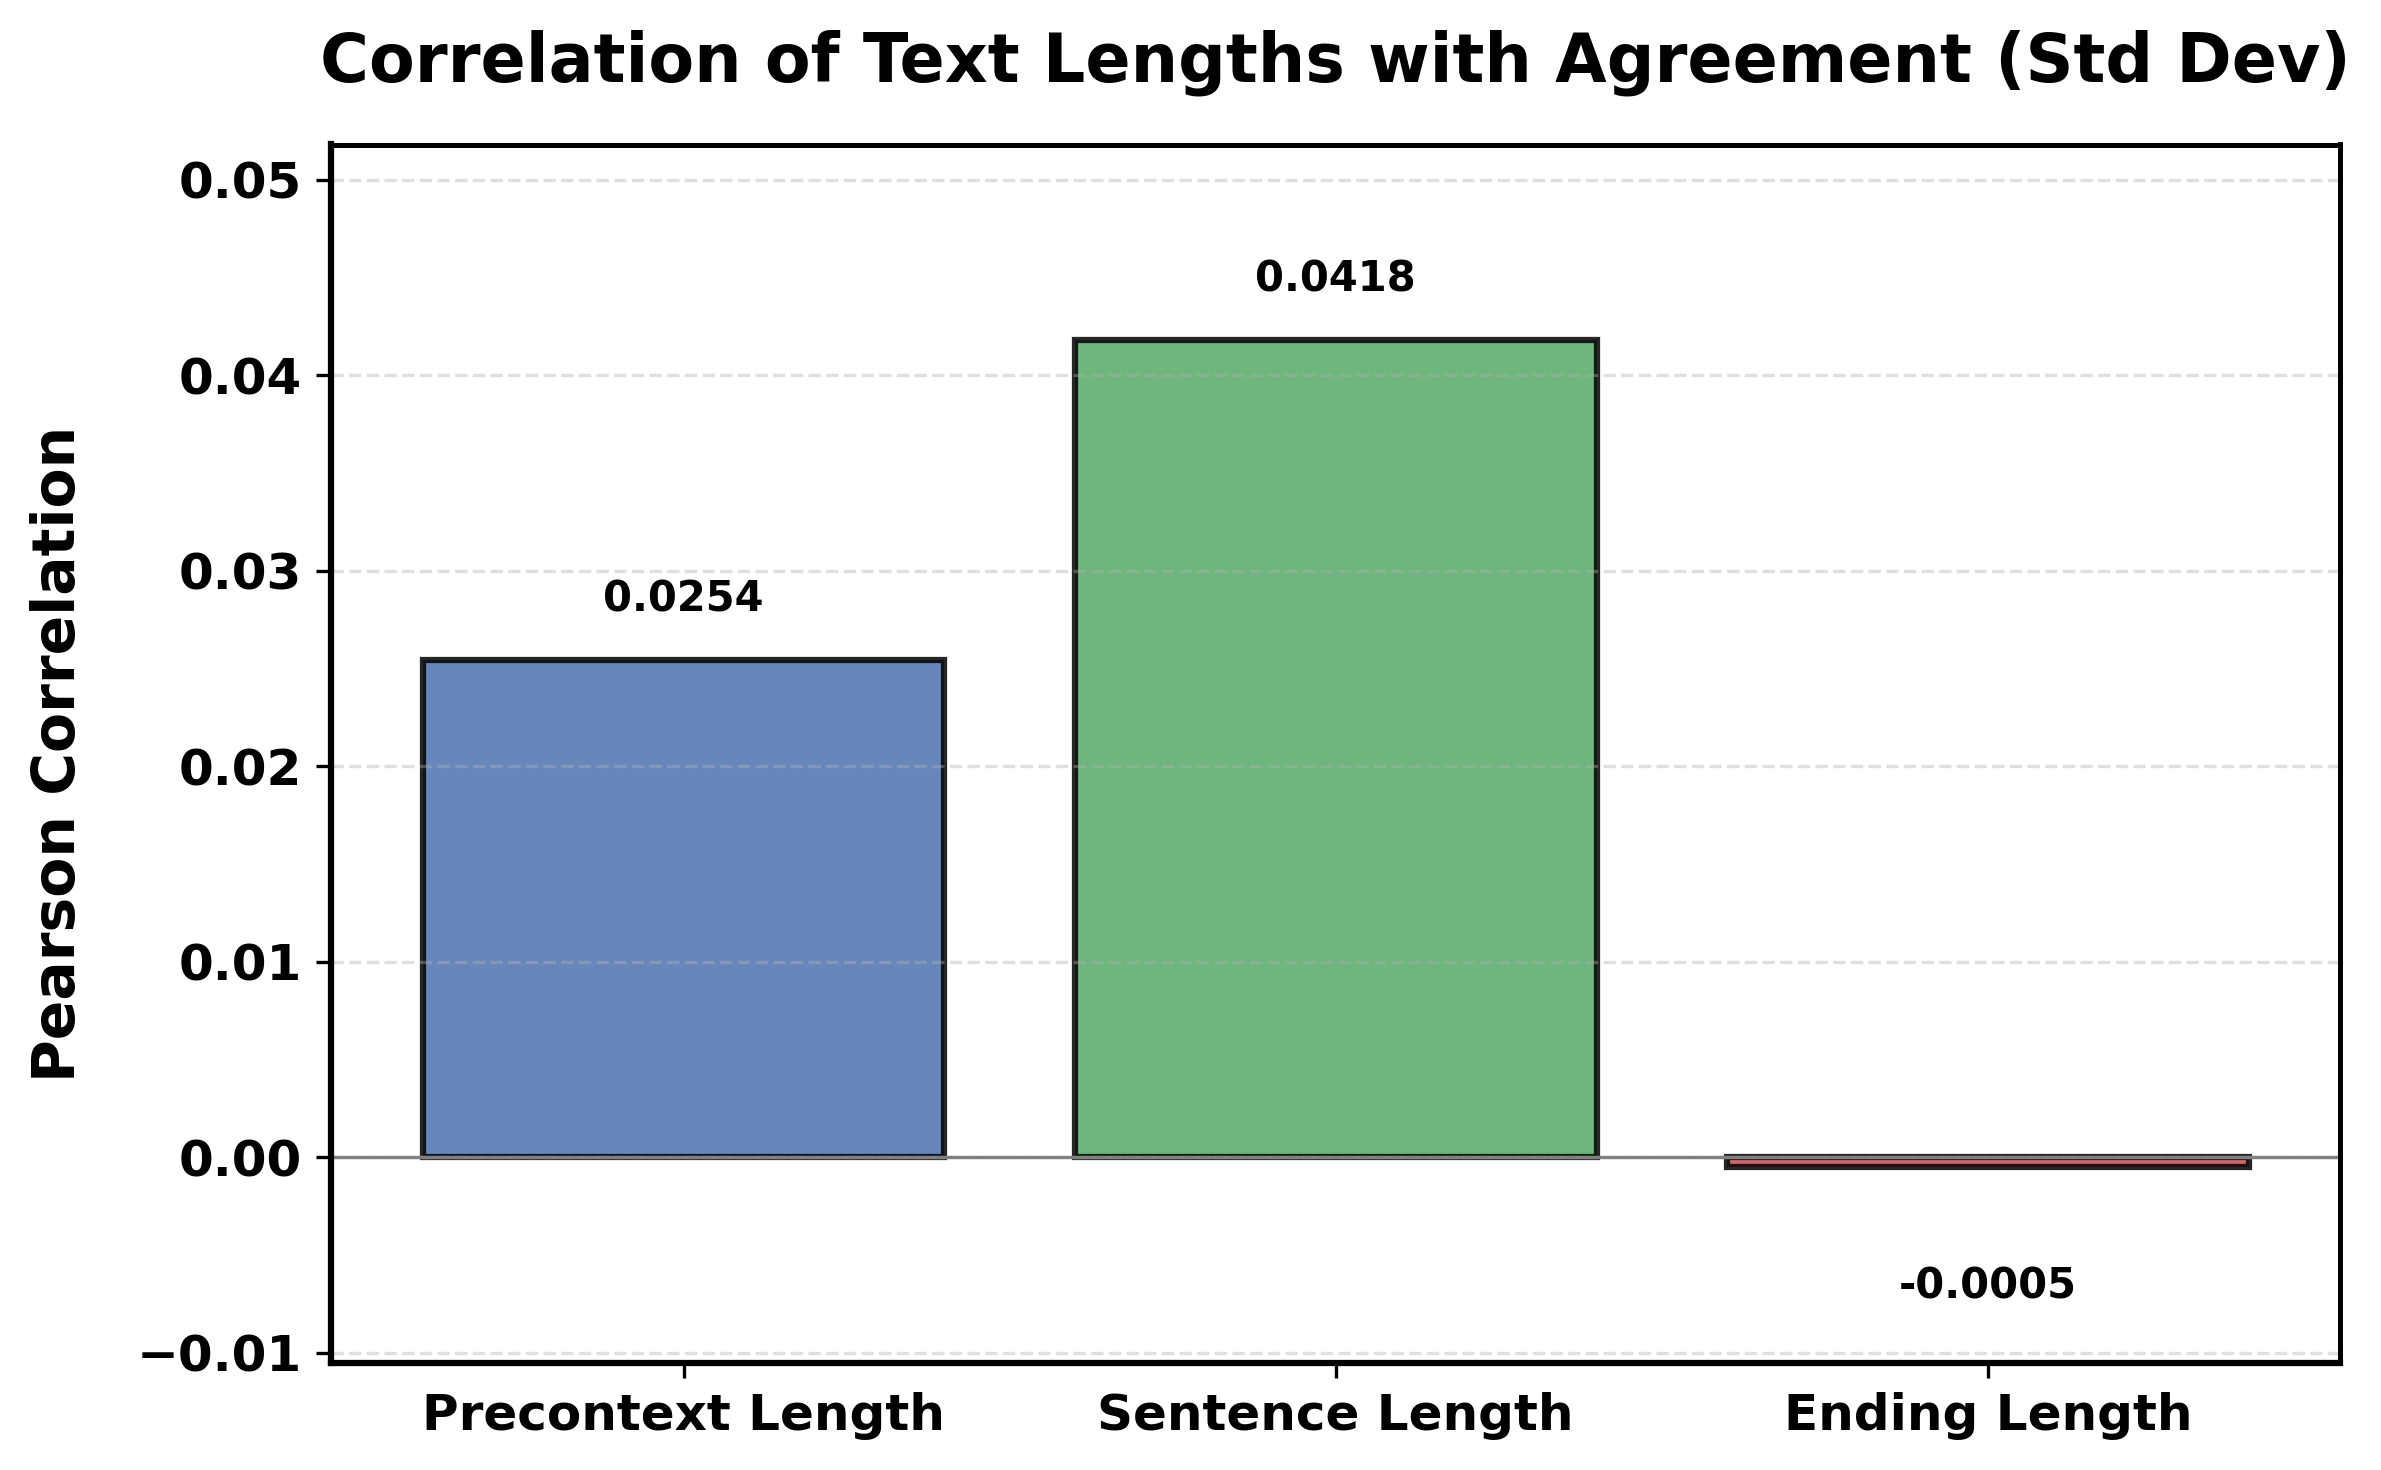

In [22]:

corrs_dict = {
    "Precontext Length": corr_precontext,
    "Sentence Length": corr_sentence,
    "Ending Length": corr_ending
}

plt.figure(figsize=(8,5), dpi=300)

colors = ['#4C72B0', '#55A868', '#C44E52']

plt.bar(
    corrs_dict.keys(),
    corrs_dict.values(),
    color=colors,
    edgecolor='black',
    linewidth=1.5,
    alpha=0.85
)

plt.axhline(0, color='gray', linewidth=0.8) # Add a zero line for reference

plt.title("Correlation of Text Lengths with Agreement (Std Dev)", fontsize=16, weight='bold', pad=15)
plt.ylabel("Pearson Correlation", fontsize=14, weight='bold', labelpad=12)

plt.xticks(fontsize=12, weight='bold')
plt.yticks(fontsize=12, weight='bold')

# Set y-axis limits to better show small correlations if they are close to zero
plt.ylim(min(0, min(corrs_dict.values()) - 0.01), max(0, max(corrs_dict.values()) + 0.01))

# Add correlation values on top of bars
for bar in plt.gca().containers[0]:
    yval = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2, yval + (0.002 if yval >= 0 else -0.005), f'{yval:.4f}',
             ha='center', va='bottom' if yval >= 0 else 'top', fontsize=10, weight='bold', color='black')

ax = plt.gca()
ax.spines['bottom'].set_linewidth(1.5)
ax.spines['left'].set_linewidth(1.5)
ax.spines['top'].set_linewidth(1.2)
ax.spines['right'].set_linewidth(1.2)

plt.grid(axis='y', linestyle='--', alpha=0.4)
plt.tight_layout()
plt.savefig("plots/correlation_bar_chart_colored.png", format='png')
plt.show()

## Ending Analysis

In [23]:
with_end = []
without_end = []

with_end_std = []
without_end_std = []

for story_id, content in all_data.items():

    avg_rating = content.get("average", None)
    std_rating = content.get("stdev", None)

    ending_text = content.get("ending", "")

    if ending_text and ending_text.strip():
        with_end.append(avg_rating)
        with_end_std.append(std_rating)
    else:
        without_end.append(avg_rating)
        without_end_std.append(std_rating)

with_end = np.array(with_end)
without_end = np.array(without_end)
with_end_std = np.array(with_end_std)
without_end_std = np.array(without_end_std)

print("\nEnding Impact Analysis")

print(f"Stories with endings: {len(with_end)}")
print(f"Stories without endings: {len(without_end)}")

print(f"\nAverage Rating (with endings): {with_end.mean():.3f}")
print(f"Average Rating (without endings): {without_end.mean():.3f}")

print(f"\nAverage Std Dev (with endings): {with_end_std.mean():.3f}")
print(f"Average Std Dev (without endings): {without_end_std.mean():.3f}")

from scipy.stats import ttest_ind

t_stat, p_value = ttest_ind(with_end_std, without_end_std, equal_var=False)

print("\nStatistical Significance Test")
print(f"T-statistic: {t_stat:.3f}")
print(f"P-value: {p_value:.4f}")

if p_value < 0.05:
    print("Conclusion: The effect of endings on agreement is statistically significant.")
else:
    print("Conclusion: The effect of endings on agreement is NOT statistically significant (likely noise).")



Ending Impact Analysis
Stories with endings: 1912
Stories without endings: 956

Average Rating (with endings): 3.144
Average Rating (without endings): 3.119

Average Std Dev (with endings): 0.964
Average Std Dev (without endings): 0.918

Statistical Significance Test
T-statistic: 2.355
P-value: 0.0186
Conclusion: The effect of endings on agreement is statistically significant.


/tmp/ipython-input-3027004094.py:7: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  plt.boxplot(data, labels=labels, patch_artist=True,


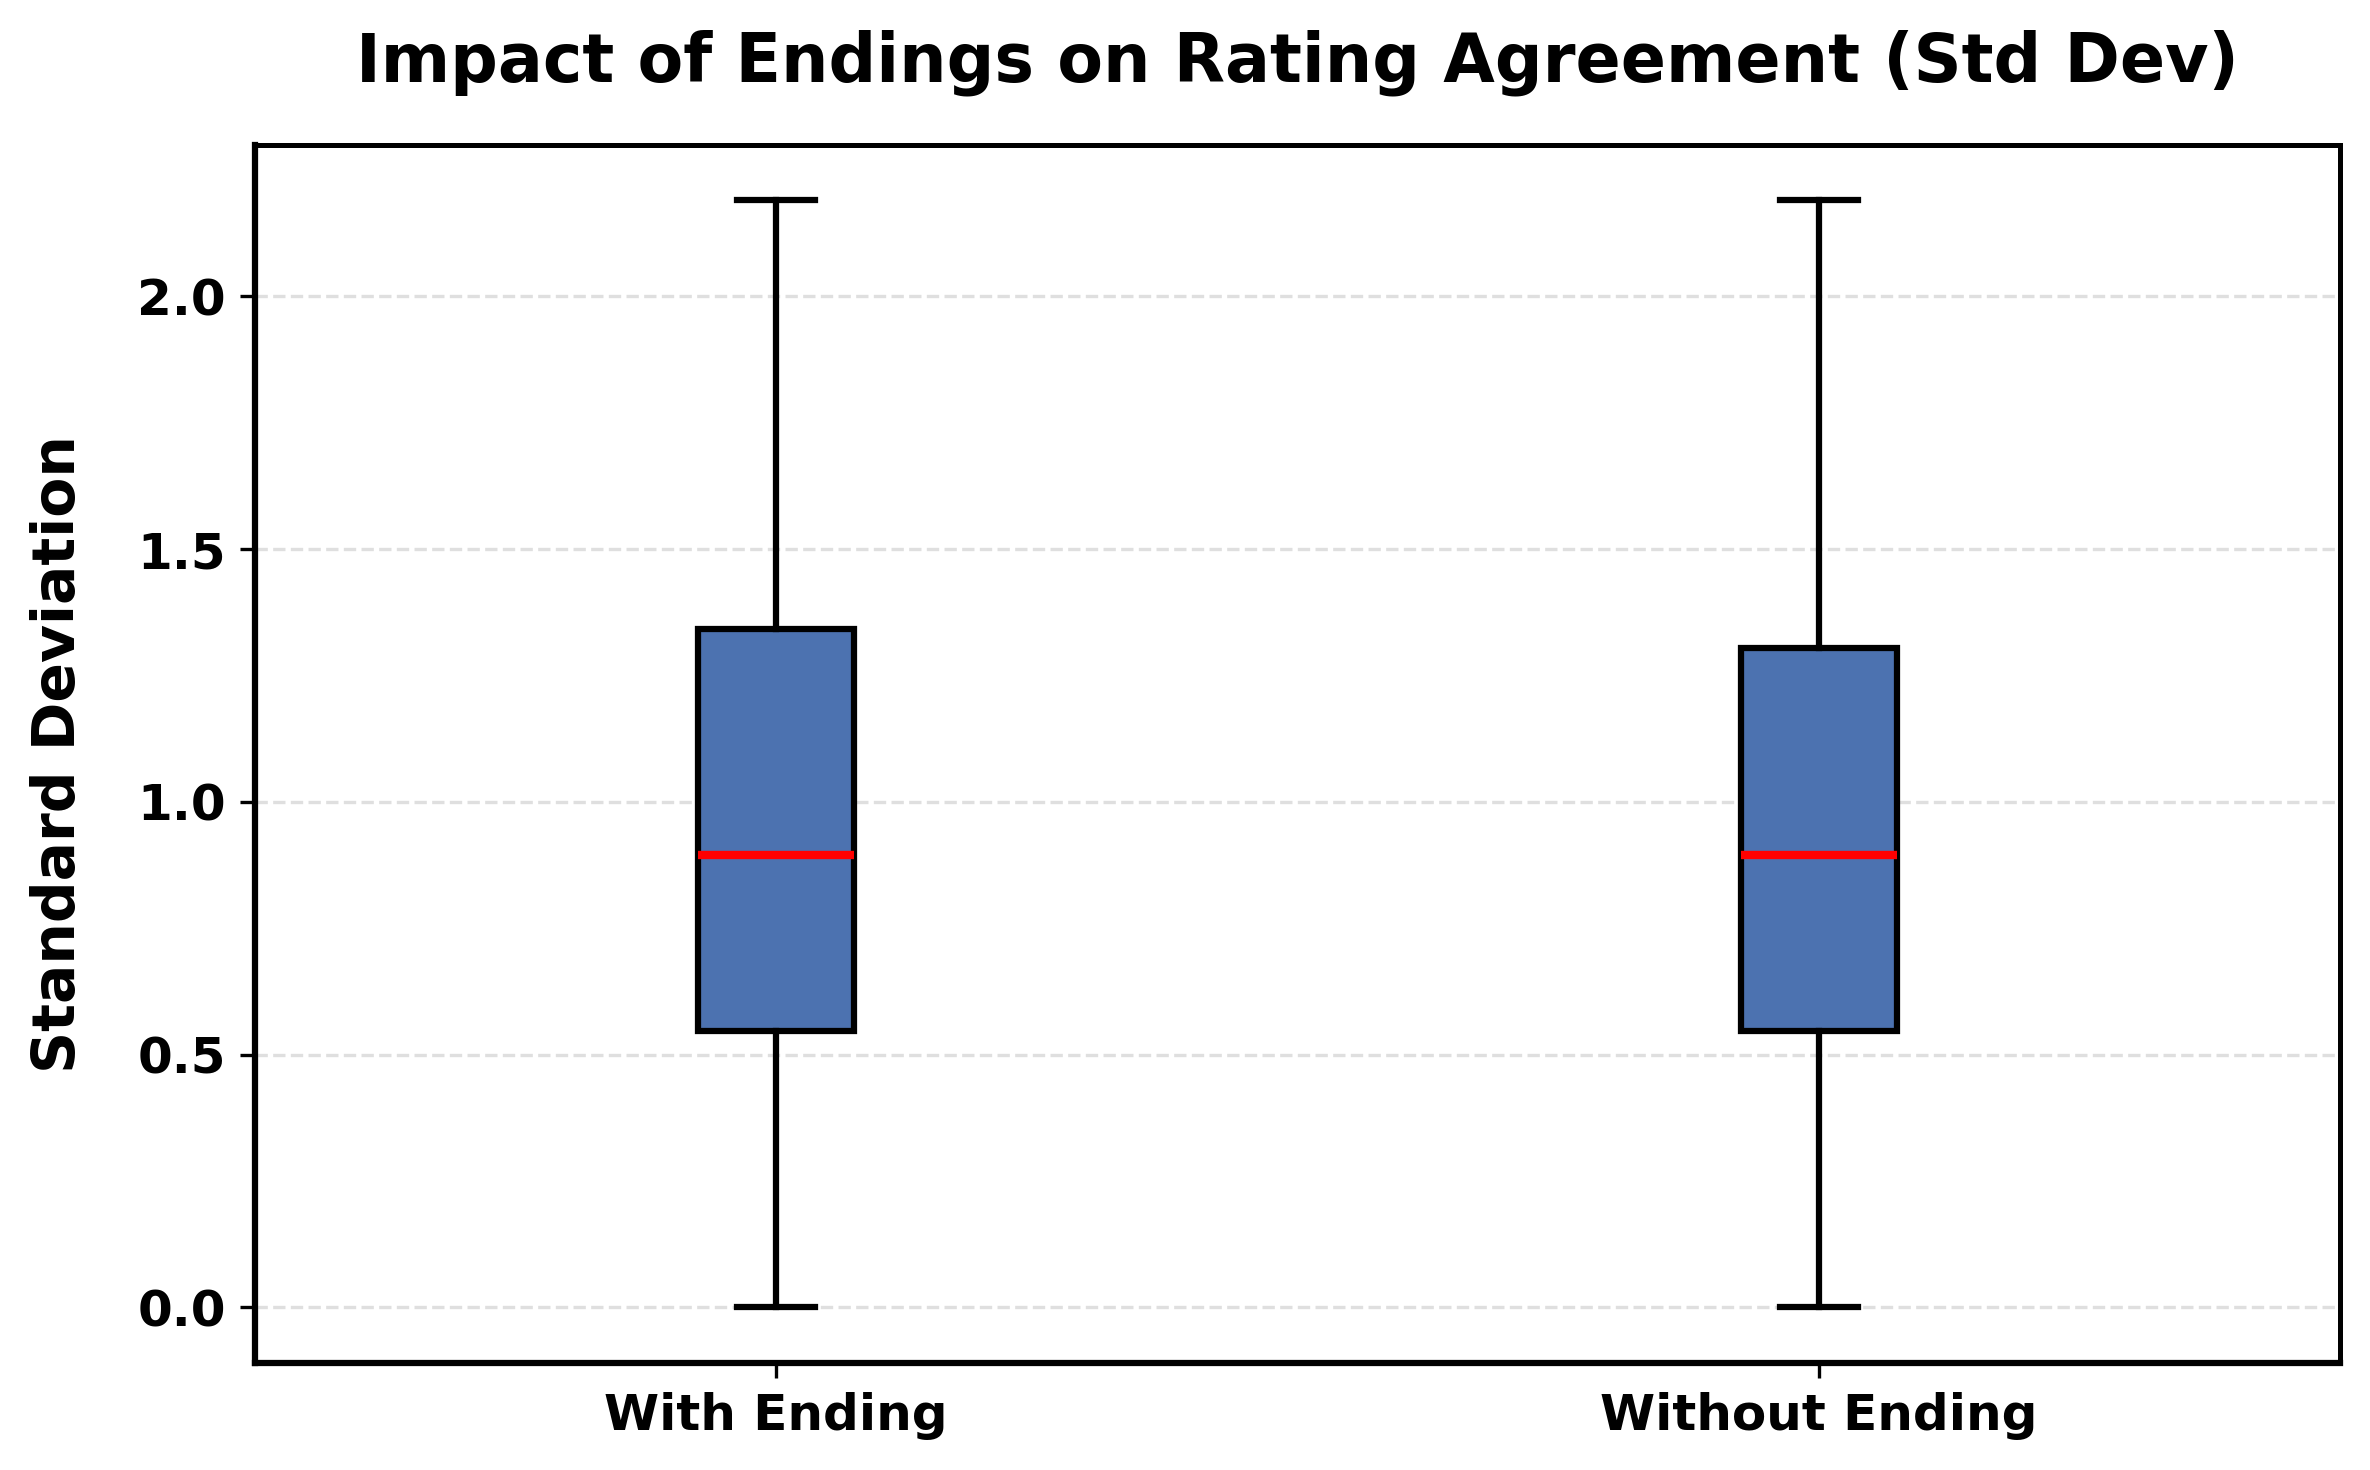

In [24]:
os.makedirs('plots', exist_ok=True)

data = [with_end_std, without_end_std]
labels = ["With Ending", "Without Ending"]

plt.figure(figsize=(8,5), dpi=300)
plt.boxplot(data, labels=labels, patch_artist=True,
            boxprops=dict(facecolor='#4C72B0', edgecolor='black', linewidth=1.5),
            medianprops=dict(color='red', linewidth=2),
            whiskerprops=dict(color='black', linewidth=1.5),
            capprops=dict(color='black', linewidth=1.5))

plt.title("Impact of Endings on Rating Agreement (Std Dev)", fontsize=16, weight='bold', pad=15)
plt.ylabel("Standard Deviation", fontsize=14, weight='bold', labelpad=12)
plt.xticks(fontsize=12, weight='bold')
plt.yticks(fontsize=12, weight='bold')

ax = plt.gca()
ax.spines['bottom'].set_linewidth(1.5)
ax.spines['left'].set_linewidth(1.5)
ax.spines['top'].set_linewidth(1.2)
ax.spines['right'].set_linewidth(1.2)
plt.grid(axis='y', linestyle='--', alpha=0.4)
plt.tight_layout()
plt.savefig('plots/ending_impact_boxplot.png', format='png')
plt.show()


## Linguistic Feature Exploration

In [25]:
nltk.download("stopwords")
stop_words = set(stopwords.words("english"))

def clean(text):
    """Lowercase, tokenize, remove stopwords."""
    tokens = re.findall(r"\b[a-z']+\b", text.lower())
    return [t for t in tokens if t not in stop_words]

precontexts = [c["precontext"] for c in all_data.values()]

word_freq = Counter()
for pre in precontexts:
    word_freq.update(clean(pre))

print("Top 10 Content Words in Precontexts (Stopwords Removed):")
for w, c in word_freq.most_common(10):
    print(f"{w}: {c}")

bigram_freq = Counter()
for pre in precontexts:
    tokens = clean(pre)
    for i in range(len(tokens)-1):
        bigram_freq[(tokens[i], tokens[i+1])] += 1

print("\nTop 10 Content Bigrams in Precontexts:")
for (a, b), c in bigram_freq.most_common(10):
    print(f"{a} {b}: {c}")

endings = [c["ending"] for c in all_data.values() if c.get("ending","").strip()]
ambiguous_sentences = [c["sentence"] for c in all_data.values() if c.get("ending","").strip()]
stds = [c["stdev"] for c in all_data.values() if c.get("ending","").strip()]

if endings and ambiguous_sentences:



    model = SentenceTransformer("all-MiniLM-L6-v2")
    sent_embeds = model.encode(ambiguous_sentences)
    end_embeds = model.encode(endings)

    sims = cosine_similarity(sent_embeds, end_embeds).diagonal()
    avg_sim = np.mean(sims)
    print("\nAverage semantic similarity between endings and ambiguous sentences:", round(avg_sim, 3))

    corr, p_value = pearsonr(sims, stds)
    print(f"Correlation between similarity and rating disagreement: {corr:.3f}")
    print(f"P-value: {p_value:.4f}")

    if p_value < 0.05:
        print("The correlation is statistically significant.")
    else:
        print("The correlation is not statistically significant.")
else:
    print("\nNo endings available for semantic similarity analysis.")


[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


Top 10 Content Words in Precontexts (Stopwords Removed):
john: 456
day: 432
always: 330
every: 324
gathered: 324
room: 324
everyone: 318
tom: 294
sat: 294
morning: 270

Top 10 Content Bigrams in Precontexts:
early morning: 102
sat quietly: 96
gathered around: 72
every day: 72
dimly lit: 72
eager see: 66
john always: 60
team gathered: 60
every morning: 48
john sat: 48


/usr/local/lib/python3.12/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


modules.json:   0%|          | 0.00/349 [00:00<?, ?B/s]

config_sentence_transformers.json:   0%|          | 0.00/116 [00:00<?, ?B/s]

README.md: 0.00B [00:00, ?B/s]

sentence_bert_config.json:   0%|          | 0.00/53.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/612 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/90.9M [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/350 [00:00<?, ?B/s]

vocab.txt: 0.00B [00:00, ?B/s]

tokenizer.json: 0.00B [00:00, ?B/s]

special_tokens_map.json:   0%|          | 0.00/112 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/190 [00:00<?, ?B/s]


Average semantic similarity between endings and ambiguous sentences: 0.349
Correlation between similarity and rating disagreement: -0.022
P-value: 0.3283
The correlation is not statistically significant.


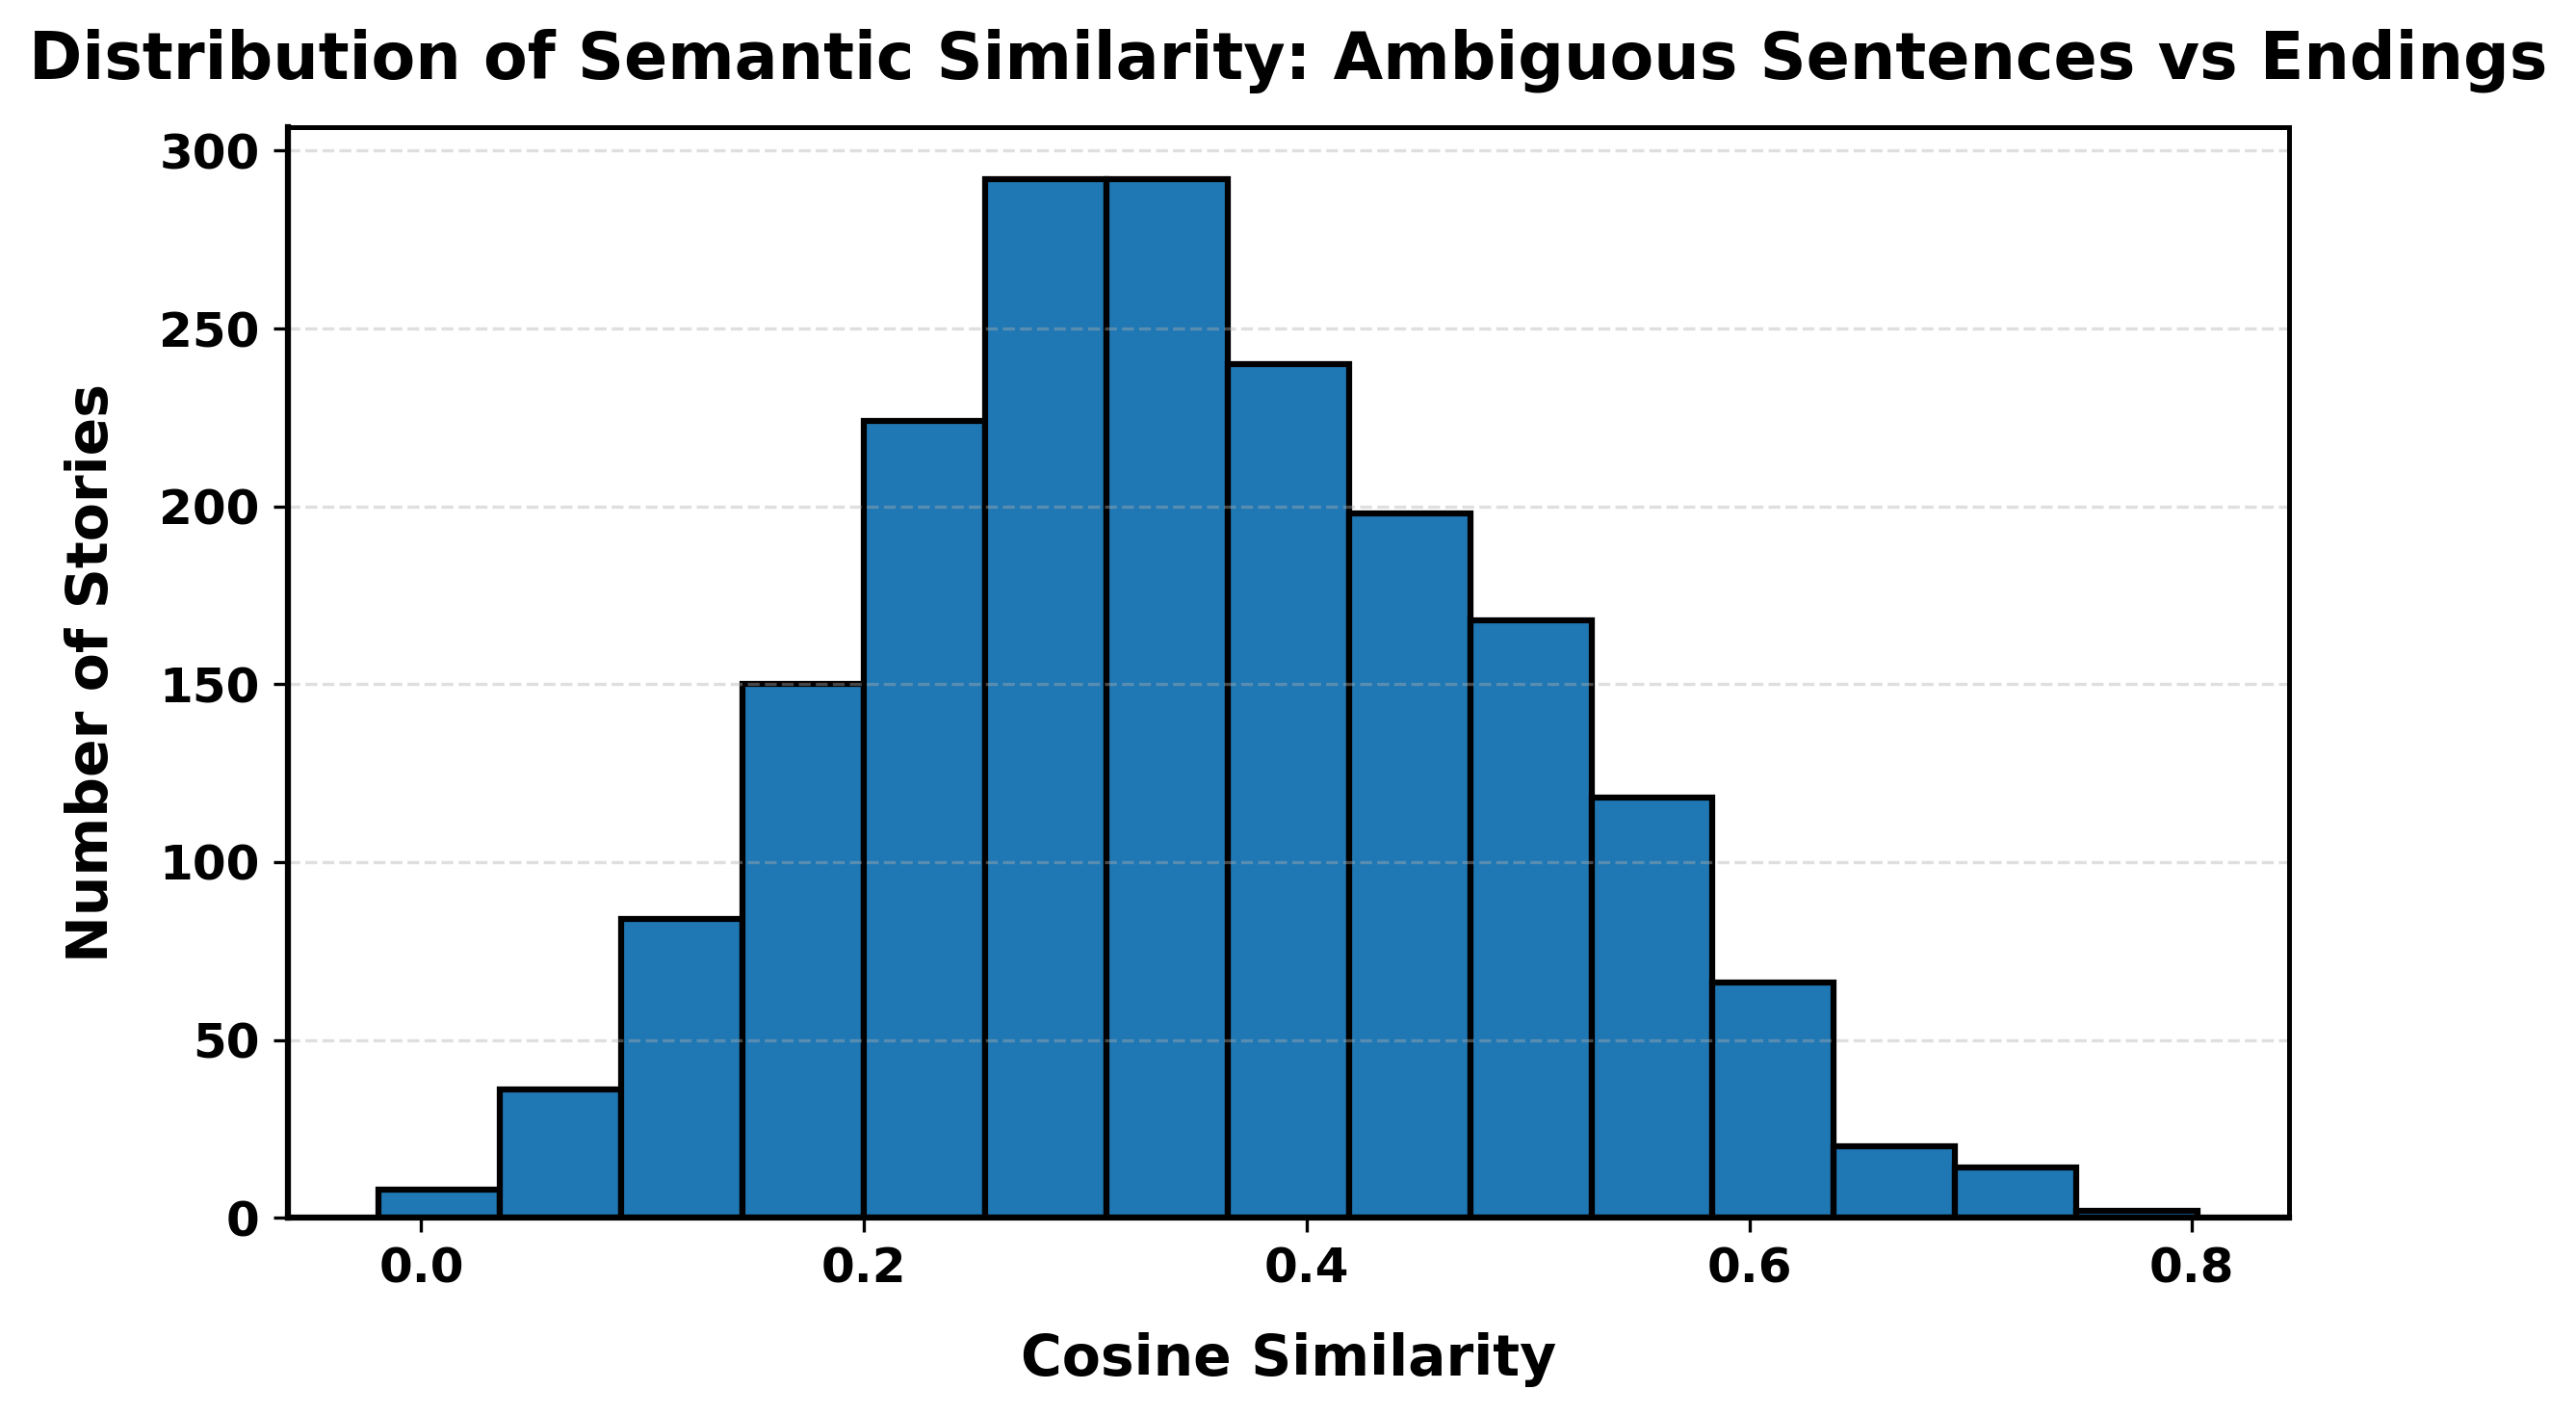

In [26]:
os.makedirs('plots', exist_ok=True)

plt.figure(figsize=(8,5), dpi=300)
plt.hist(sims, bins=15, edgecolor='black', linewidth=1.5)
plt.title("Distribution of Semantic Similarity: Ambiguous Sentences vs Endings", fontsize=16, weight="bold", pad=12)
plt.xlabel("Cosine Similarity", fontsize=14, weight="bold", labelpad=10)
plt.ylabel("Number of Stories", fontsize=14, weight="bold", labelpad=10)
plt.xticks(fontsize=12, weight="bold")
plt.yticks(fontsize=12, weight="bold")
ax = plt.gca()
ax.spines['bottom'].set_linewidth(1.5)
ax.spines['left'].set_linewidth(1.5)
ax.spines['top'].set_linewidth(1.2)
ax.spines['right'].set_linewidth(1.2)
plt.grid(axis='y', linestyle='--', alpha=0.4)
plt.tight_layout()
plt.savefig('plots/semantic_similarity_distribution.png', format='png')
plt.show()


## Case Study Analysis

In [27]:
def is_unanimous(choices):
    return len(set(choices)) == 1

def is_max_disagreement(choices):
    s = set(choices)
    return (1 in s) and (5 in s)

perfect_cases = []
disagree_cases = []

for sid, content in all_data.items():
    ratings = content["choices"]

    if is_unanimous(ratings) and len(perfect_cases) < 5:
        perfect_cases.append((sid, content))
    if is_max_disagreement(ratings) and len(disagree_cases) < 5:
        disagree_cases.append((sid, content))
    if len(perfect_cases) >= 5 and len(disagree_cases) >= 5:
        break

def summarize_linguistics(stories):
    summaries = []
    for sid, c in stories:
        pre = c["precontext"]
        sent = c["sentence"]
        end = c.get("ending", "")

        summaries.append({
            "story_id": sid,
            "pre_len": len(pre.split()),
            "sentence_len": len(sent.split()),
            "ending_len": len(end.split()) if end else 0,
            "homonym": c["homonym"],
            "num_ratings": len(c["choices"]),
            "rating_std": c["stdev"]
        })
    return pd.DataFrame(summaries)

perfect_df = summarize_linguistics(perfect_cases)
disagree_df = summarize_linguistics(disagree_cases)

print("\nSummary: Linguistic features of perfect agreement stories")
print(perfect_df.describe())

print("\nSummary: Linguistic features of maximum disagreement stories")
print(disagree_df.describe())

print("\nData-driven observations:")

pre_diff = perfect_df["pre_len"].mean() - disagree_df["pre_len"].mean()
sent_diff = perfect_df["sentence_len"].mean() - disagree_df["sentence_len"].mean()
end_diff = perfect_df["ending_len"].mean() - disagree_df["ending_len"].mean()

print(f"Average precontext length difference (perfect - disagreement): {pre_diff:.1f} words")
print(f"Average ambiguous sentence length difference (perfect - disagreement): {sent_diff:.1f} words")
print(f"Average ending length difference (perfect - disagreement): {end_diff:.1f} words")

print(f"Average rating std for perfect agreement stories: {perfect_df['rating_std'].mean():.2f}")
print(f"Average rating std for max disagreement stories: {disagree_df['rating_std'].mean():.2f}")

if pre_diff < 0:
    print("Perfect-agreement stories have slightly shorter precontexts than maximum-disagreement stories.")
else:
    print("Perfect-agreement stories have slightly longer precontexts than maximum-disagreement stories.")

if sent_diff < 0:
    print("Perfect-agreement stories have shorter ambiguous sentences, possibly making meaning clearer.")
else:
    print("Perfect-agreement stories have longer ambiguous sentences than maximum-disagreement stories.")

if end_diff > 0:
    print("Endings in perfect-agreement stories tend to be slightly longer, reinforcing clarity.")
else:
    print("Endings in perfect-agreement stories tend to be shorter or absent.")



Summary: Linguistic features of perfect agreement stories
       pre_len  sentence_len  ending_len  num_ratings  rating_std
count      5.0      5.000000    5.000000          5.0         5.0
mean      27.0      8.200000   15.400000          5.0         0.0
std        3.0      2.167948   14.656057          0.0         0.0
min       23.0      6.000000    0.000000          5.0         0.0
25%       26.0      6.000000    0.000000          5.0         0.0
50%       26.0      9.000000   19.000000          5.0         0.0
75%       30.0      9.000000   28.000000          5.0         0.0
max       30.0     11.000000   30.000000          5.0         0.0

Summary: Linguistic features of maximum disagreement stories
         pre_len  sentence_len  ending_len  num_ratings  rating_std
count   5.000000      5.000000    5.000000          5.0    5.000000
mean   27.800000      8.400000   17.200000          5.0    1.717525
std     3.271085      2.792848   12.070626          0.0    0.193999
min    23.000

/tmp/ipython-input-43847975.py:12: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x='group', y='pre_len', data=combined_df, **box_kwargs)
/tmp/ipython-input-43847975.py:27: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x='group', y='sentence_len', data=combined_df, **box_kwargs)
/tmp/ipython-input-43847975.py:42: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x='group', y='ending_len', data=combined_df, **box_kwargs)
/tmp/ipython-input-43847975.py:57: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed 

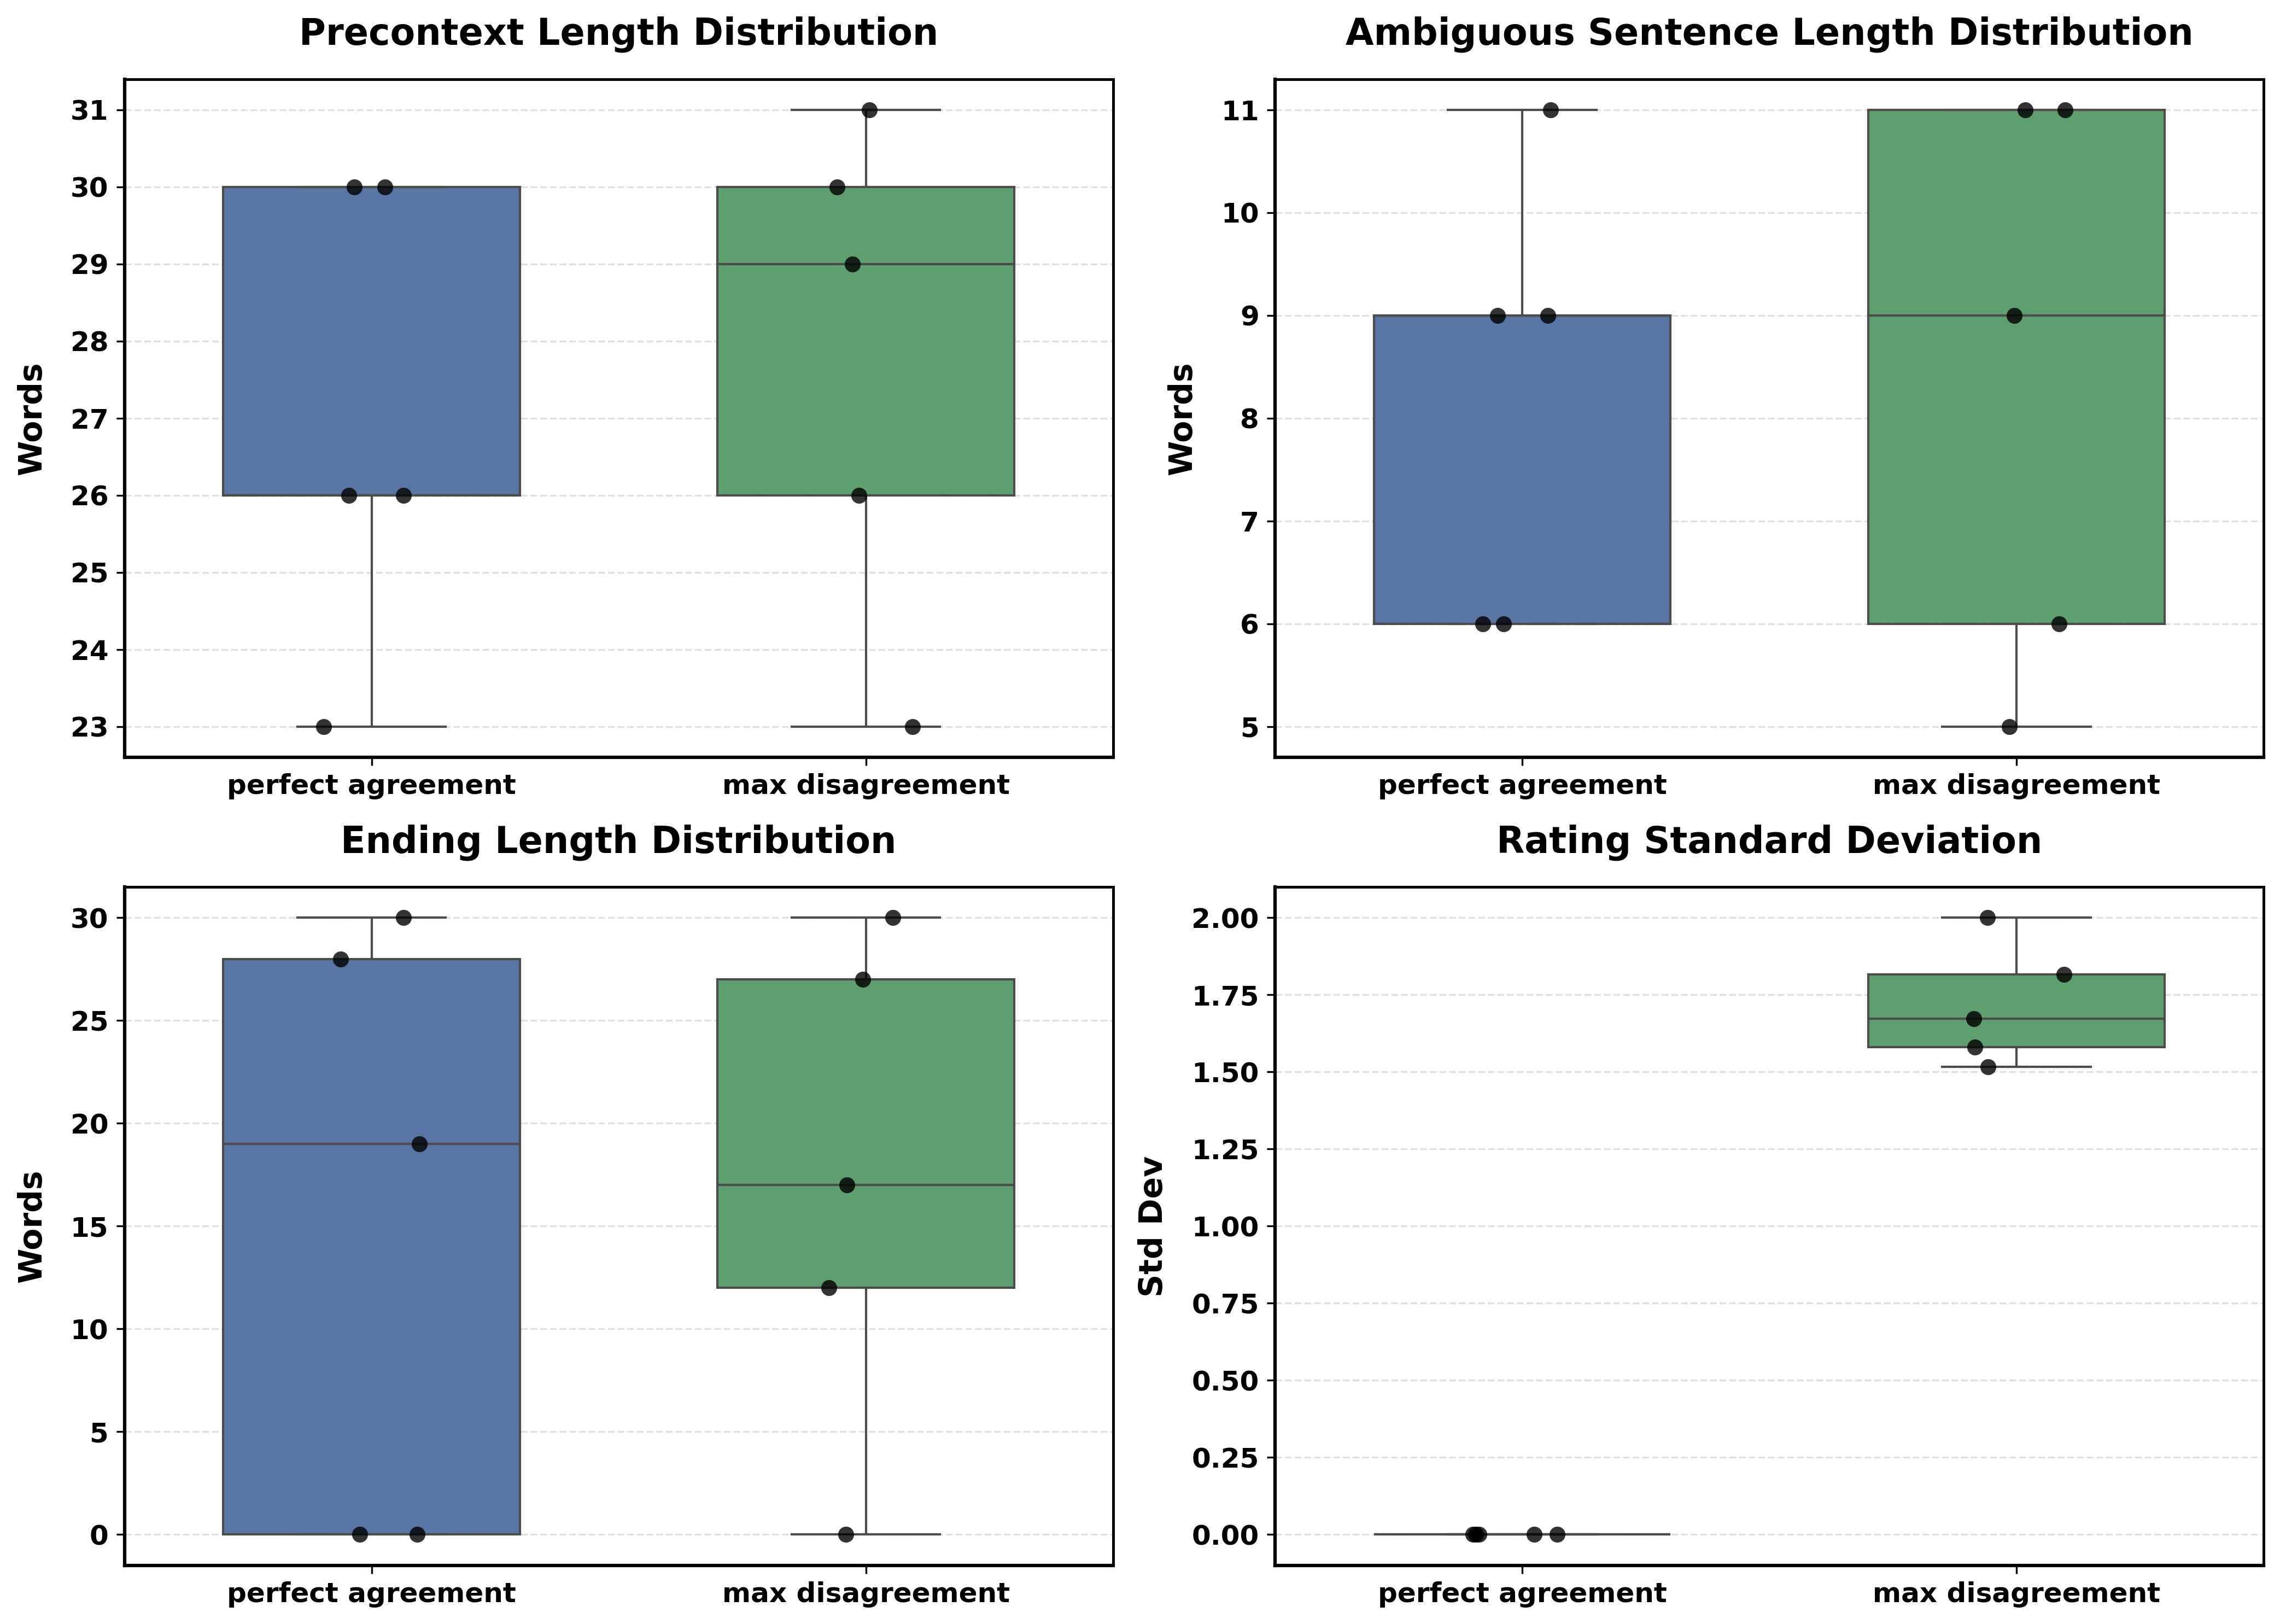

In [28]:
perfect_df['group'] = 'perfect agreement'
disagree_df['group'] = 'max disagreement'

combined_df = pd.concat([perfect_df, disagree_df], ignore_index=True)

plt.figure(figsize=(14,10), dpi=300)

box_kwargs = dict(width=0.6, palette=['#4C72B0', '#55A868'])
strip_kwargs = dict(color='black', size=7, jitter=True, alpha=0.8)

plt.subplot(2,2,1)
sns.boxplot(x='group', y='pre_len', data=combined_df, **box_kwargs)
sns.stripplot(x='group', y='pre_len', data=combined_df, **strip_kwargs)
plt.title("Precontext Length Distribution", fontsize=16, weight='bold', pad=15)
plt.ylabel("Words", fontsize=14, weight='bold', labelpad=10)
plt.xlabel("")
plt.xticks(fontsize=12, weight='bold')
plt.yticks(fontsize=12, weight='bold')
ax = plt.gca()
ax.spines['bottom'].set_linewidth(1.5)
ax.spines['left'].set_linewidth(1.5)
ax.spines['top'].set_linewidth(1.2)
ax.spines['right'].set_linewidth(1.2)
plt.grid(axis='y', linestyle='--', alpha=0.4)

plt.subplot(2,2,2)
sns.boxplot(x='group', y='sentence_len', data=combined_df, **box_kwargs)
sns.stripplot(x='group', y='sentence_len', data=combined_df, **strip_kwargs)
plt.title("Ambiguous Sentence Length Distribution", fontsize=16, weight='bold', pad=15)
plt.ylabel("Words", fontsize=14, weight='bold', labelpad=10)
plt.xlabel("")
plt.xticks(fontsize=12, weight='bold')
plt.yticks(fontsize=12, weight='bold')
ax = plt.gca()
ax.spines['bottom'].set_linewidth(1.5)
ax.spines['left'].set_linewidth(1.5)
ax.spines['top'].set_linewidth(1.2)
ax.spines['right'].set_linewidth(1.2)
plt.grid(axis='y', linestyle='--', alpha=0.4)

plt.subplot(2,2,3)
sns.boxplot(x='group', y='ending_len', data=combined_df, **box_kwargs)
sns.stripplot(x='group', y='ending_len', data=combined_df, **strip_kwargs)
plt.title("Ending Length Distribution", fontsize=16, weight='bold', pad=15)
plt.ylabel("Words", fontsize=14, weight='bold', labelpad=10)
plt.xlabel("")
plt.xticks(fontsize=12, weight='bold')
plt.yticks(fontsize=12, weight='bold')
ax = plt.gca()
ax.spines['bottom'].set_linewidth(1.5)
ax.spines['left'].set_linewidth(1.5)
ax.spines['top'].set_linewidth(1.2)
ax.spines['right'].set_linewidth(1.2)
plt.grid(axis='y', linestyle='--', alpha=0.4)

plt.subplot(2,2,4)
sns.boxplot(x='group', y='rating_std', data=combined_df, **box_kwargs)
sns.stripplot(x='group', y='rating_std', data=combined_df, **strip_kwargs)
plt.title("Rating Standard Deviation", fontsize=16, weight='bold', pad=15)
plt.ylabel("Std Dev", fontsize=14, weight='bold', labelpad=10)
plt.xlabel("")
plt.xticks(fontsize=12, weight='bold')
plt.yticks(fontsize=12, weight='bold')
ax = plt.gca()
ax.spines['bottom'].set_linewidth(1.5)
ax.spines['left'].set_linewidth(1.5)
ax.spines['top'].set_linewidth(1.2)
ax.spines['right'].set_linewidth(1.2)
plt.grid(axis='y', linestyle='--', alpha=0.4)

plt.tight_layout()
plt.savefig("plots/length_rating_boxplots.png", format='png')
plt.show()


#Correlation Analysis

In [29]:
# Prepare data for analysis
context_lengths = []
rating_agreements = []

In [30]:
#iterate over story content,
for sample in all_data.values():
    # Calculate the context length as sum of words in precontext and sentence
    context_length = len(sample["precontext"].split()) + len(sample["sentence"].split())
    context_lengths.append(context_length)

    # Rating agreement is the standard deviation of the 'choices' ratings
    rating_agreement = np.std(sample["choices"])
    rating_agreements.append(rating_agreement)

# Create a DataFrame
df = pd.DataFrame({
    'context_length': context_lengths,
    'rating_agreement': rating_agreements
})

# Calculate the correlation between context length and rating agreement
correlation, p_value = pearsonr(df['context_length'], df['rating_agreement'])

# Output the results
print(f"Correlation between context length and rating agreement: {correlation:.4f}")
print(f"P-value: {p_value:.4f}")


Correlation between context length and rating agreement: 0.0417
P-value: 0.0257


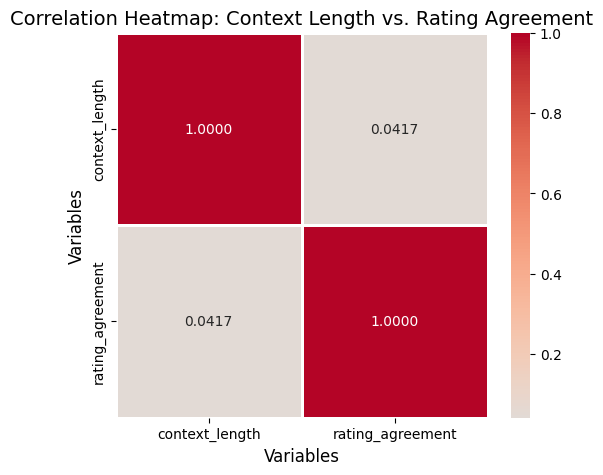

In [61]:
# Plot the heatmap
corr_matrix = df.corr()
plt.figure(figsize=(6, 5))
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', center=0, linewidths=1, fmt='.4f', cbar=True)

# Set title and labels
plt.title("Correlation Heatmap: Context Length vs. Rating Agreement", fontsize=14)
plt.xlabel("Variables", fontsize=12)
plt.ylabel("Variables", fontsize=12)
plt.savefig("plots/correlation_heatmap.png", format='png')
# Show the plot
plt.show()

In [32]:
# Calculate the average standard deviation for each homonym
homonym_disagreement = all_data_df.groupby('homonym')['stdev'].mean().sort_values(ascending=False)

# Select the top 10 homonyms with the highest disagreement (ambiguity)
top_disagreement_homonyms = homonym_disagreement.head(10)

print("\nHomonyms with Highest Rating Disagreement (Top 10 by average StDev):")
print(top_disagreement_homonyms)



Homonyms with Highest Rating Disagreement (Top 10 by average StDev):
homonym
identities    1.594159
draft         1.534309
quarter       1.486527
bit           1.390588
hops          1.379270
Drawing       1.374542
story         1.372389
single        1.370535
fans          1.357737
landing       1.336817
Name: stdev, dtype: float64


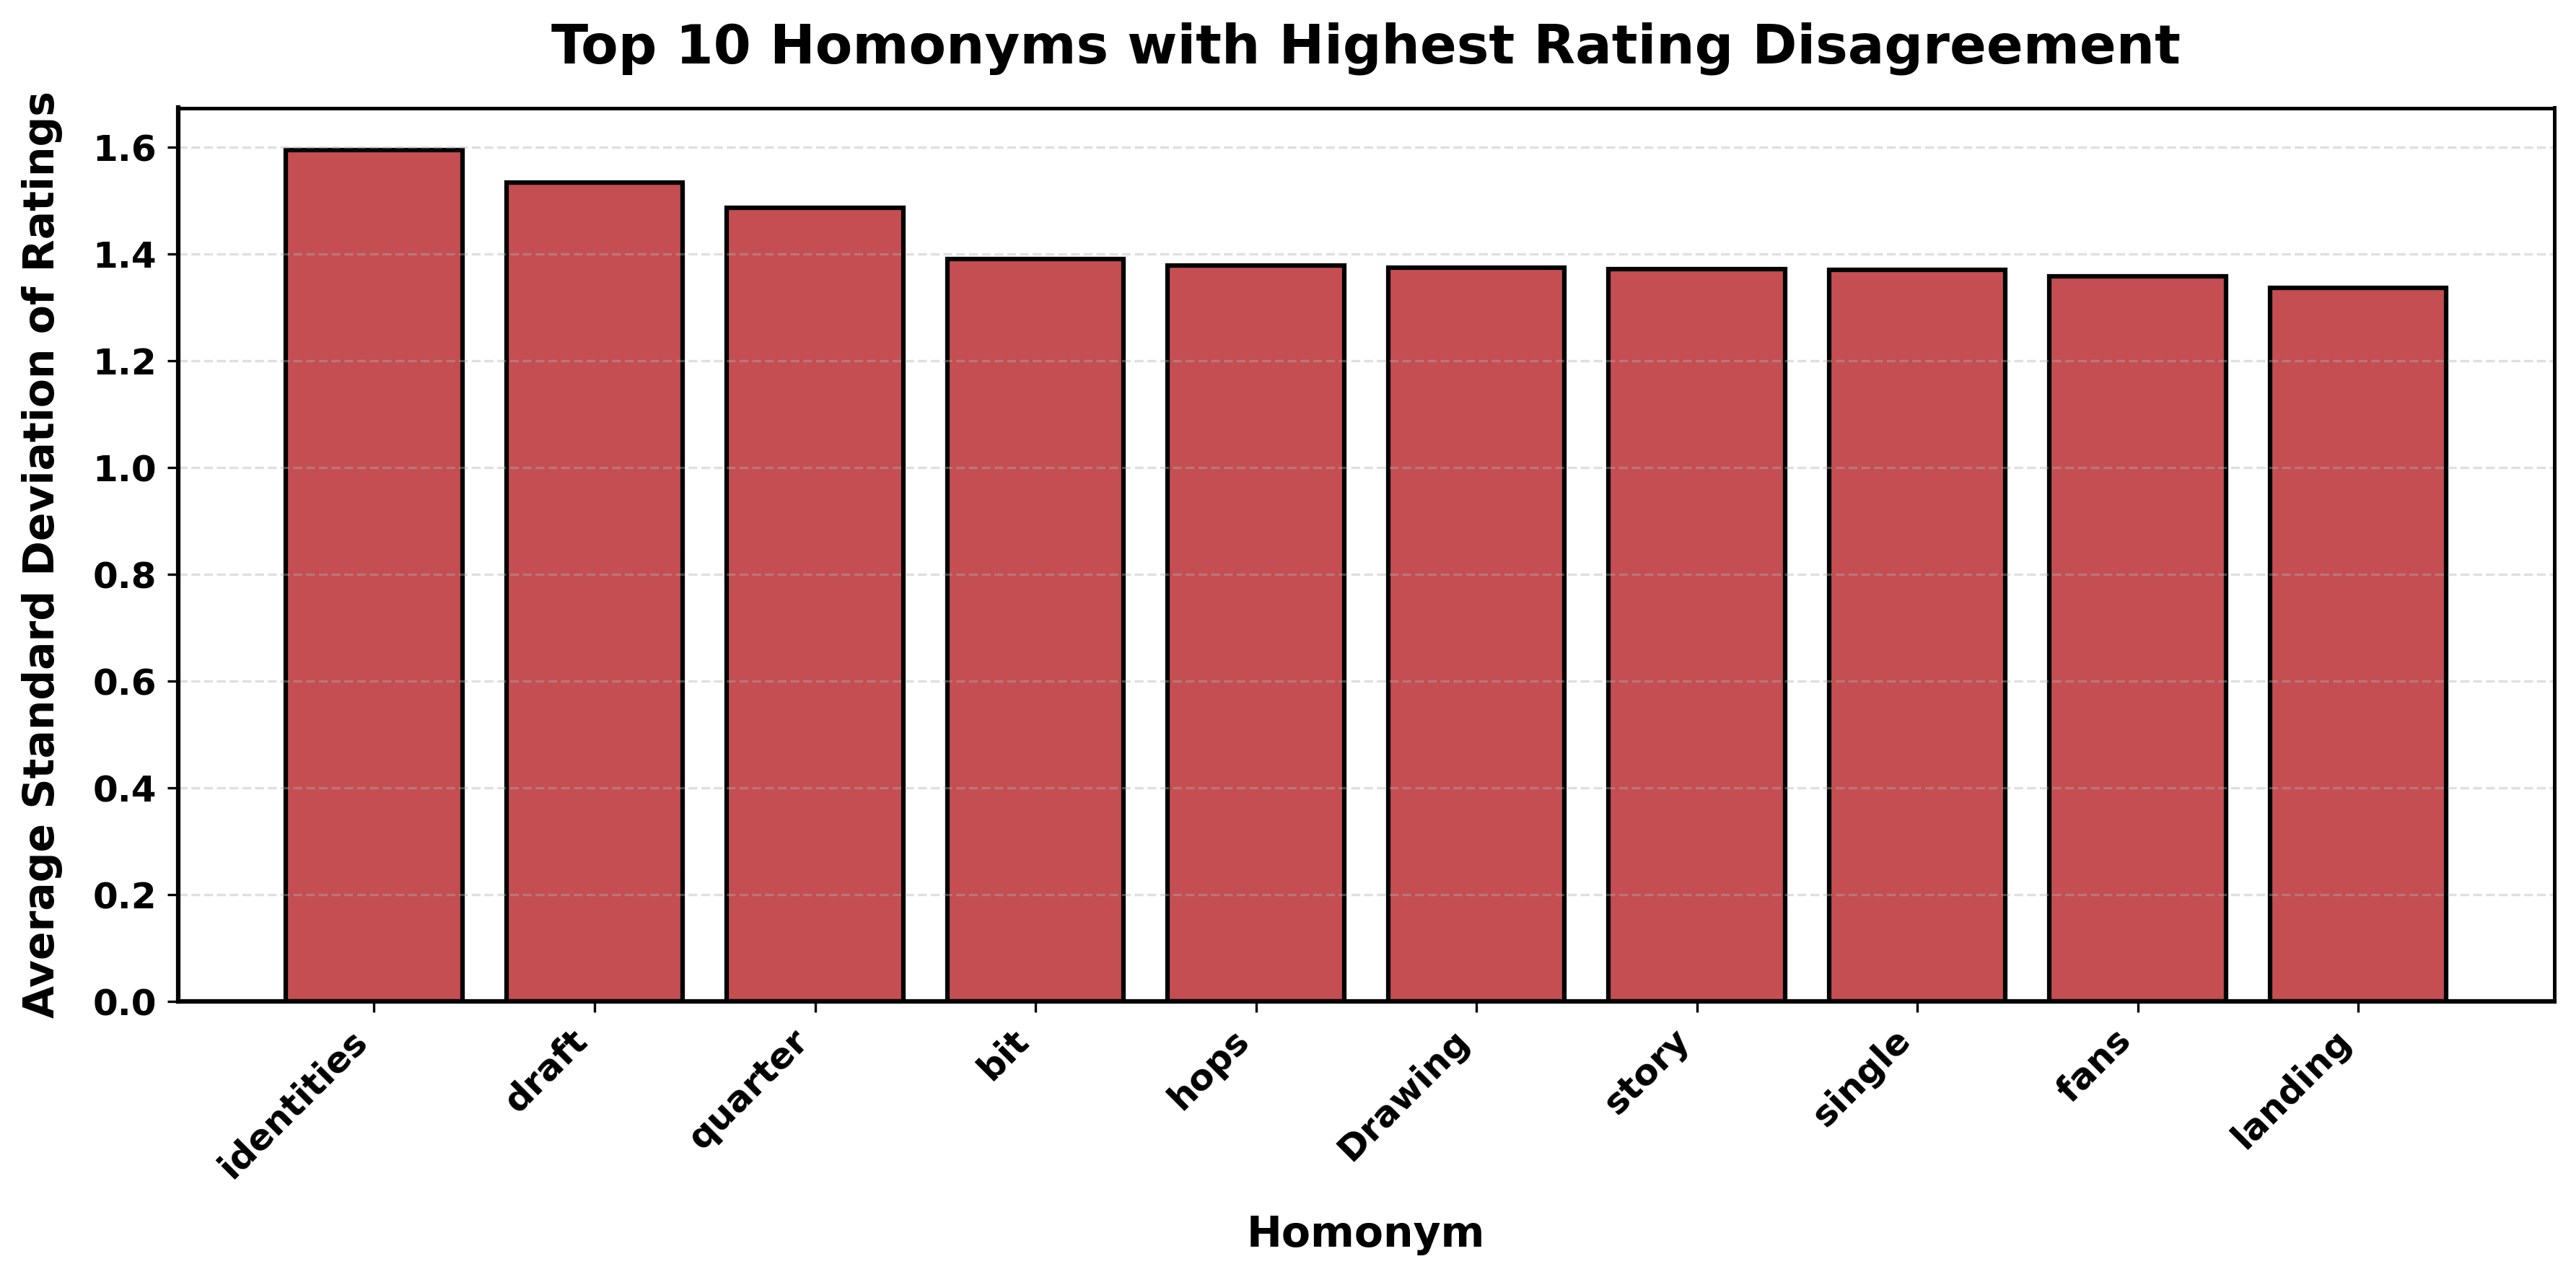

In [33]:
# Plotting the top 10 homonyms by disagreement
plt.figure(figsize=(12, 6), dpi=300)

bars = plt.bar(
    top_disagreement_homonyms.index,
    top_disagreement_homonyms.values,
    color='#C44E52',
    edgecolor='black',
    linewidth=1.5
)

plt.title('Top 10 Homonyms with Highest Rating Disagreement', fontsize=18, weight='bold', pad=15)
plt.xlabel('Homonym', fontsize=14, weight='bold', labelpad=10)
plt.ylabel('Average Standard Deviation of Ratings', fontsize=14, weight='bold', labelpad=10)
plt.xticks(rotation=45, ha='right', fontsize=12, weight='bold')
plt.yticks(fontsize=12, weight='bold')

ax = plt.gca()
ax.spines['bottom'].set_linewidth(1.5)
ax.spines['left'].set_linewidth(1.5)
ax.spines['top'].set_linewidth(1.2)
ax.spines['right'].set_linewidth(1.2)

plt.grid(axis='y', linestyle='--', alpha=0.4)
plt.tight_layout()
plt.savefig('plots/top_disagreement_homonyms.png', format='png')
plt.show()

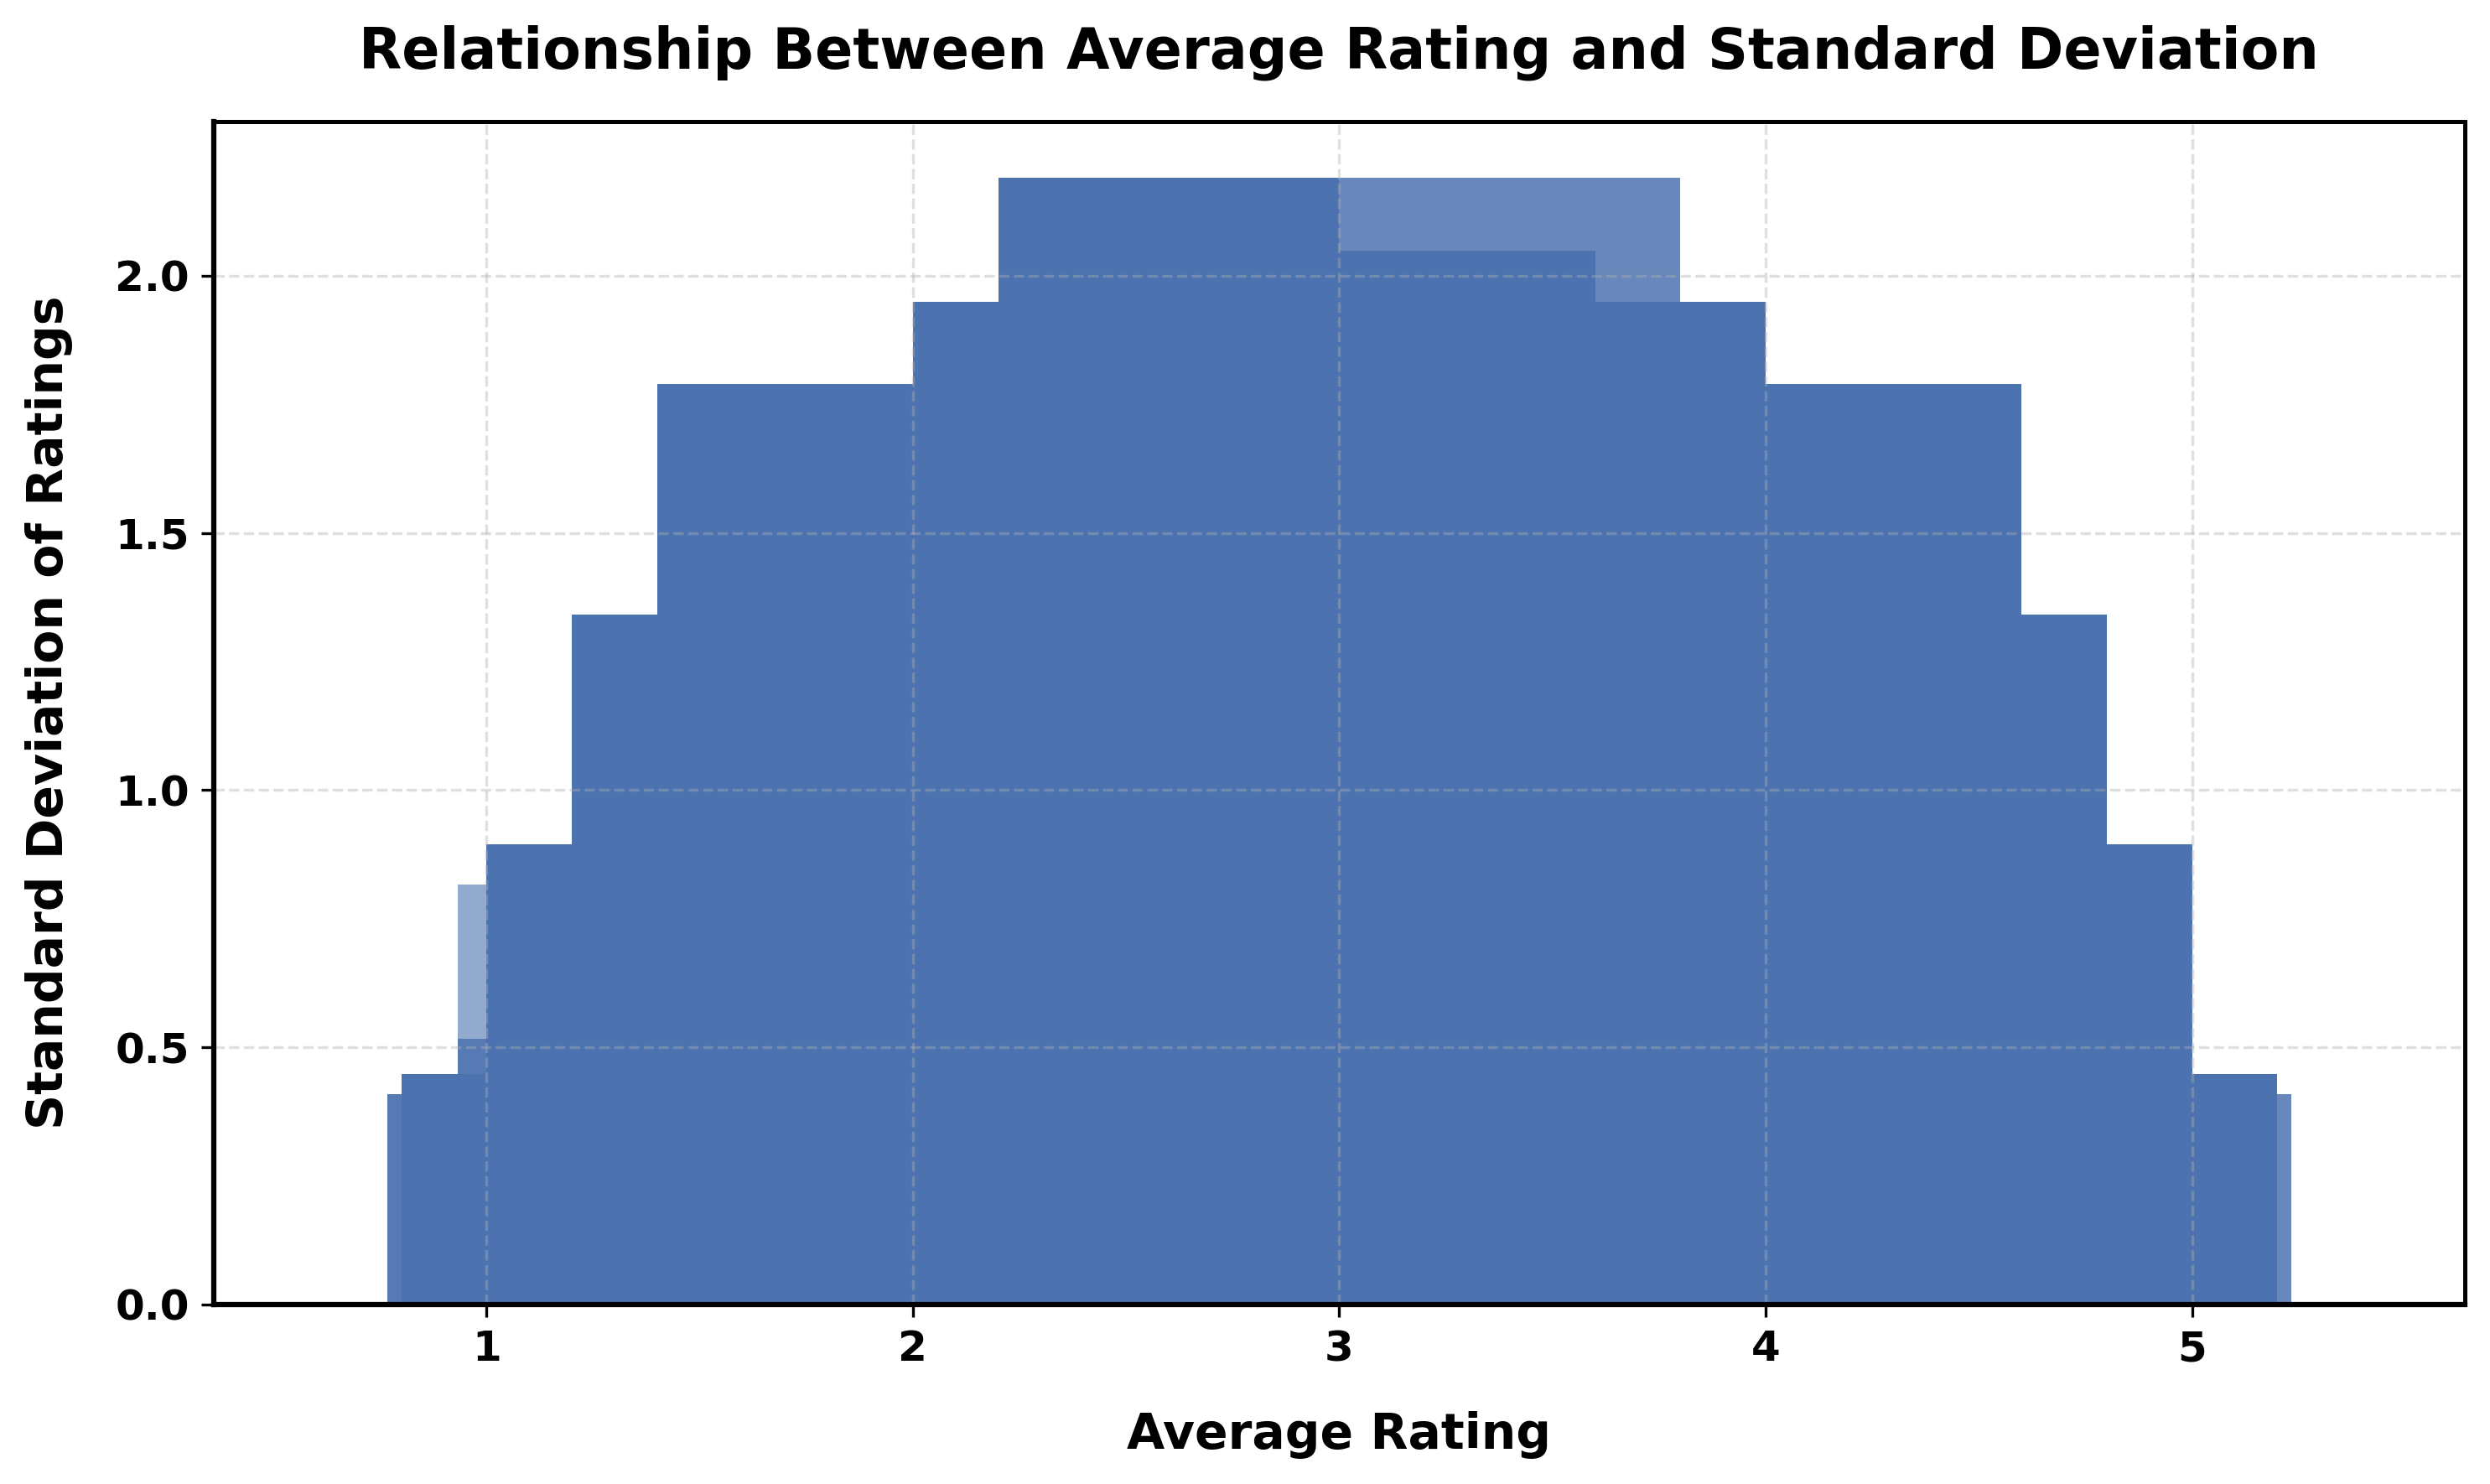

In [34]:
plt.figure(figsize=(10, 6), dpi=300)

# Create a bar plot
plt.bar(averages, stdevs, color='#4C72B0', alpha=0.6)

# Add title and labels
plt.title('Relationship Between Average Rating and Standard Deviation', fontsize=16, weight='bold', pad=15)
plt.xlabel('Average Rating', fontsize=14, weight='bold', labelpad=12)
plt.ylabel('Standard Deviation of Ratings', fontsize=14, weight='bold', labelpad=12)
plt.xticks(fontsize=12, weight='bold')
plt.yticks(fontsize=12, weight='bold')

# Customize the plot's axes
ax = plt.gca()
ax.spines['bottom'].set_linewidth(1.5)
ax.spines['left'].set_linewidth(1.5)
ax.spines['top'].set_linewidth(1.2)
ax.spines['right'].set_linewidth(1.2)

plt.grid(True, linestyle='--', alpha=0.4)
plt.tight_layout()

# Save the plot to a file
plt.savefig('plots/avg_rating_vs_std_dev_bar.png', format='png')

# Display the plot
plt.show()


# Challenge Categorization

In [35]:
print(ratings_df['agreement'].value_counts().reindex(["High Agreement", "Medium Agreement", "Low Agreement"]))

def print_story_details(label, story_id, content):
    print(f"\n{label}: STORY {story_id}")
    print(f"Homonym: {content['homonym']}")
    print(f"Ratings: {content['choices']}   (avg={content['average']:.2f}, stdev={content['stdev']:.2f})")
    print(f"Difficulty Level: {ratings_df.loc[ratings_df['story_id'] == story_id, 'agreement'].iloc[0]}")
    print("PRECONTEXT:")
    print(content["precontext"])
    print("AMBIGUOUS SENTENCE:")
    print(content["sentence"])
    print(
f"ENDING (if any):\n{content.get('ending', '').strip() or '[NO ENDING]'}"
)


agreement
High Agreement      1562
Medium Agreement     757
Low Agreement        549
Name: count, dtype: int64


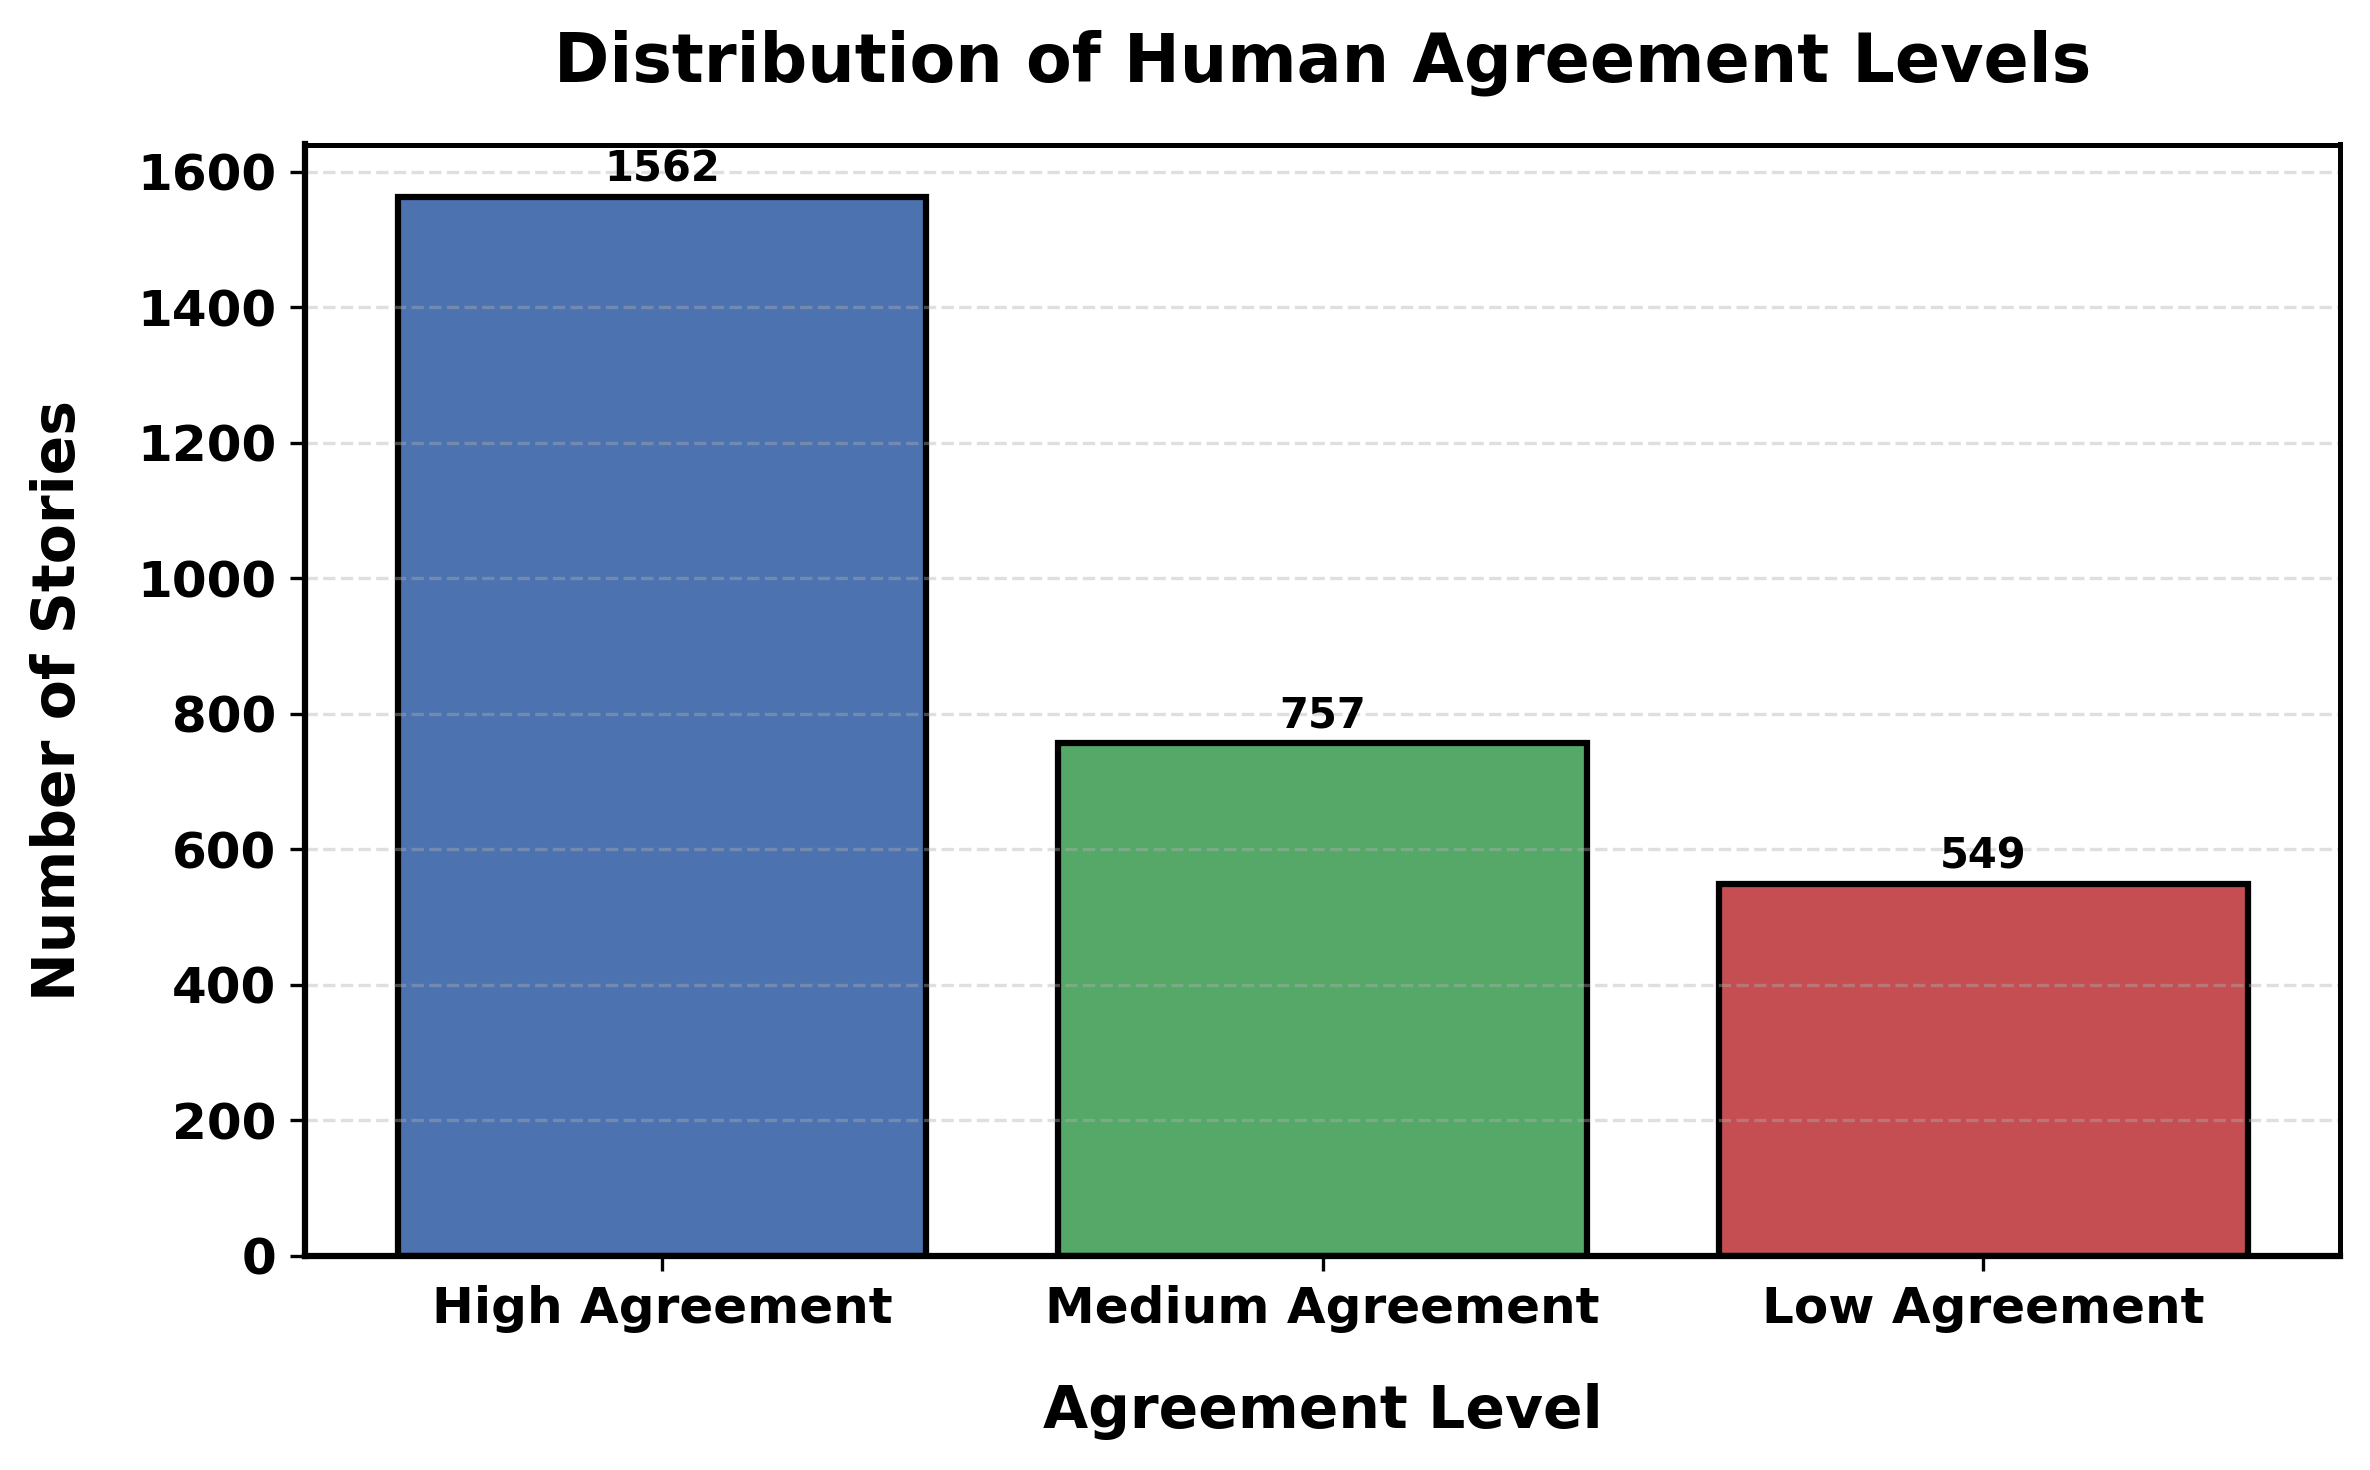

In [36]:

plt.figure(figsize=(8, 5), dpi=300)

bars = plt.bar(
    agreement_counts.index,
    agreement_counts.values,
    color=['#4C72B0', '#55A868', '#C44E52'], # Distinct colors for each category
    edgecolor='black',
    linewidth=1.5
)

plt.title('Distribution of Human Agreement Levels', fontsize=16, weight='bold', pad=15)
plt.xlabel('Agreement Level', fontsize=14, weight='bold', labelpad=12)
plt.ylabel('Number of Stories', fontsize=14, weight='bold', labelpad=12)
plt.xticks(fontsize=12, weight='bold')
plt.yticks(fontsize=12, weight='bold')

# Add counts on top of the bars
for bar in bars:
    yval = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2, yval + 10, int(yval),
             ha='center', va='bottom', fontsize=10, weight='bold', color='black')

ax = plt.gca()
ax.spines['bottom'].set_linewidth(1.5)
ax.spines['left'].set_linewidth(1.5)
ax.spines['top'].set_linewidth(1.2)
ax.spines['right'].set_linewidth(1.2)

plt.grid(axis='y', linestyle='--', alpha=0.4)
plt.tight_layout()
plt.savefig('plots/agreement_levels_distribution.png', format='png')
plt.show()

# Statistical Outlier Detection

In [37]:
# Calculate Q1 (25th percentile) and Q3 (75th percentile) of the standard deviations
Q1 = ratings_df['std'].quantile(0.25)
Q3 = ratings_df['std'].quantile(0.75)
IQR = Q3 - Q1

# Define outlier bounds
upper_bound = Q3 + 1.5 * IQR

# Identify outliers: stories with std dev above the upper bound
outlier_stories = ratings_df[ratings_df['std'] > upper_bound]

print(f"Q1 (25th percentile of Std Dev): {Q1:.3f}")
print(f"Q3 (75th percentile of Std Dev): {Q3:.3f}")
print(f"IQR (Interquartile Range): {IQR:.3f}")
print(f"Upper bound for outliers (Q3 + 1.5 * IQR): {upper_bound:.3f}")

print(f"\nTotal outlier stories identified: {len(outlier_stories)}")

if not outlier_stories.empty:
    print("\nFirst 5 outlier stories (based on high standard deviation):")
    # Display details of the first few outlier stories
    for i, (story_id, row) in enumerate(outlier_stories.head(5).iterrows()):
        content = all_data[story_id] # Assuming all_data is available
        print(f"\n  Outlier Story ID: {story_id}")
        print(f"  Homonym: {content['homonym']}")
        print(f"  Ratings: {content['choices']} (avg={content['average']:.2f}, stdev={row['std']:.2f})")
        print(f"  Precontext: {content['precontext'][:100]}...") # Show first 100 chars
        print(f"  Sentence: {content['sentence']}")
        print(f"  Ending: {content.get('ending', '').strip()[:100]}...")
        if i == 4: # Limit to 5 examples
            break
else:
    print("No outliers found based on the IQR method for standard deviation.")

Q1 (25th percentile of Std Dev): 0.548
Q3 (75th percentile of Std Dev): 1.342
IQR (Interquartile Range): 0.794
Upper bound for outliers (Q3 + 1.5 * IQR): 2.533

Total outlier stories identified: 0
No outliers found based on the IQR method for standard deviation.


In [38]:
def print_unexpected_story(label, story_data):
    print(f"\n--- {label} ---")
    print(f"Story ID: {story_data['story_id']}")
    print(f"Homonym: {all_data[story_data['story_id']]['homonym']}")
    print(f"Ratings: {all_data[story_data['story_id']]['choices']} (Avg: {story_data['average']:.2f}, Std: {story_data['std']:.2f})")
    print(f"Precontext: {all_data[story_data['story_id']]['precontext'][:150]}...")
    print(f"Sentence: {all_data[story_data['story_id']]['sentence']}")
    print(f"Ending: {all_data[story_data['story_id']].get('ending', '').strip()[:150]}...")
    print("-"*80)


In [39]:
if 'average' not in ratings_df.columns:
    ratings_df['average'] = ratings_df[["rater1","rater2","rater3","rater4","rater5"]].mean(axis=1)

# Define thresholds
high_avg_threshold = 4.0
low_avg_threshold = 2.0
high_std_threshold = 1.5 #


In [40]:
# High Average, High Disagreement (e.g., Average >= 4, Std >= 1.5)

high_avg_high_std = ratings_df[(ratings_df['average'] >= high_avg_threshold) & (ratings_df['std'] >= high_std_threshold)]
print(f"Found {len(high_avg_high_std)} stories with High Average and High Disagreement.")
if not high_avg_high_std.empty:
    print_unexpected_story("Example: High Avg (>=4.0) & High Std (>=1.5)", high_avg_high_std.iloc[0])



Found 40 stories with High Average and High Disagreement.

--- Example: High Avg (>=4.0) & High Std (>=1.5) ---
Story ID: train_57
Homonym: appendix
Ratings: [5, 5, 4, 5, 1] (Avg: 4.00, Std: 1.73)
Precontext: John had been working on his novel for months, pouring over every chapter. He was determined to have it completed by the end of the week. However, the...
Sentence: John was late completing the book because he had been having trouble with his appendix.
Ending: It had been causing him a lot of pain in his lower abdomen recently....
--------------------------------------------------------------------------------


In [41]:
# Low Average, High Disagreement (e.g., Average <= 2, Std >= 1.5)
low_avg_high_std = ratings_df[(ratings_df['average'] <= low_avg_threshold) & (ratings_df['std'] >= high_std_threshold)]
print(f"Found {len(low_avg_high_std)} stories with Low Average and High Disagreement.")
if not low_avg_high_std.empty:
    print_unexpected_story("Example: Low Avg (<=2.0) & High Std (>=1.5)", low_avg_high_std.iloc[0])


Found 44 stories with Low Average and High Disagreement.

--- Example: Low Avg (<=2.0) & High Std (>=1.5) ---
Story ID: train_56
Homonym: appendix
Ratings: [1, 5, 1, 1, 2] (Avg: 2.00, Std: 1.73)
Precontext: John had been working on his novel for months, pouring over every chapter. He was determined to have it completed by the end of the week. However, the...
Sentence: John was late completing the book because he had been having trouble with his appendix.
Ending: It had been causing him a lot of pain in his lower abdomen recently....
--------------------------------------------------------------------------------


In [42]:
# Neutral Average, High Disagreement (e.g., Average between 2.5 and 3.5, Std >= 1.5)
neutral_avg_high_std = ratings_df[(ratings_df['average'] > low_avg_threshold) &
                                   (ratings_df['average'] < high_avg_threshold) &
                                   (ratings_df['std'] >= high_std_threshold)]
print(f"Found {len(neutral_avg_high_std)} stories with Neutral Average and High Disagreement.")
if not neutral_avg_high_std.empty:
    print_unexpected_story("Example: Neutral Avg (>2.0 & <4.0) & High Std (>=1.5)", neutral_avg_high_std.iloc[0])


Found 465 stories with Neutral Average and High Disagreement.

--- Example: Neutral Avg (>2.0 & <4.0) & High Std (>=1.5) ---
Story ID: train_0
Homonym: potential
Ratings: [4, 5, 2, 3, 1] (Avg: 3.00, Std: 1.58)
Precontext: The old machine hummed in the corner of the workshop. Clara examined its dusty dials with a furrowed brow. She wondered if it could be brought back to...
Sentence: The potential couldn't be measured.
Ending: She collected a battery reader and looked on earnestly, willing some life back into the old machine....
--------------------------------------------------------------------------------


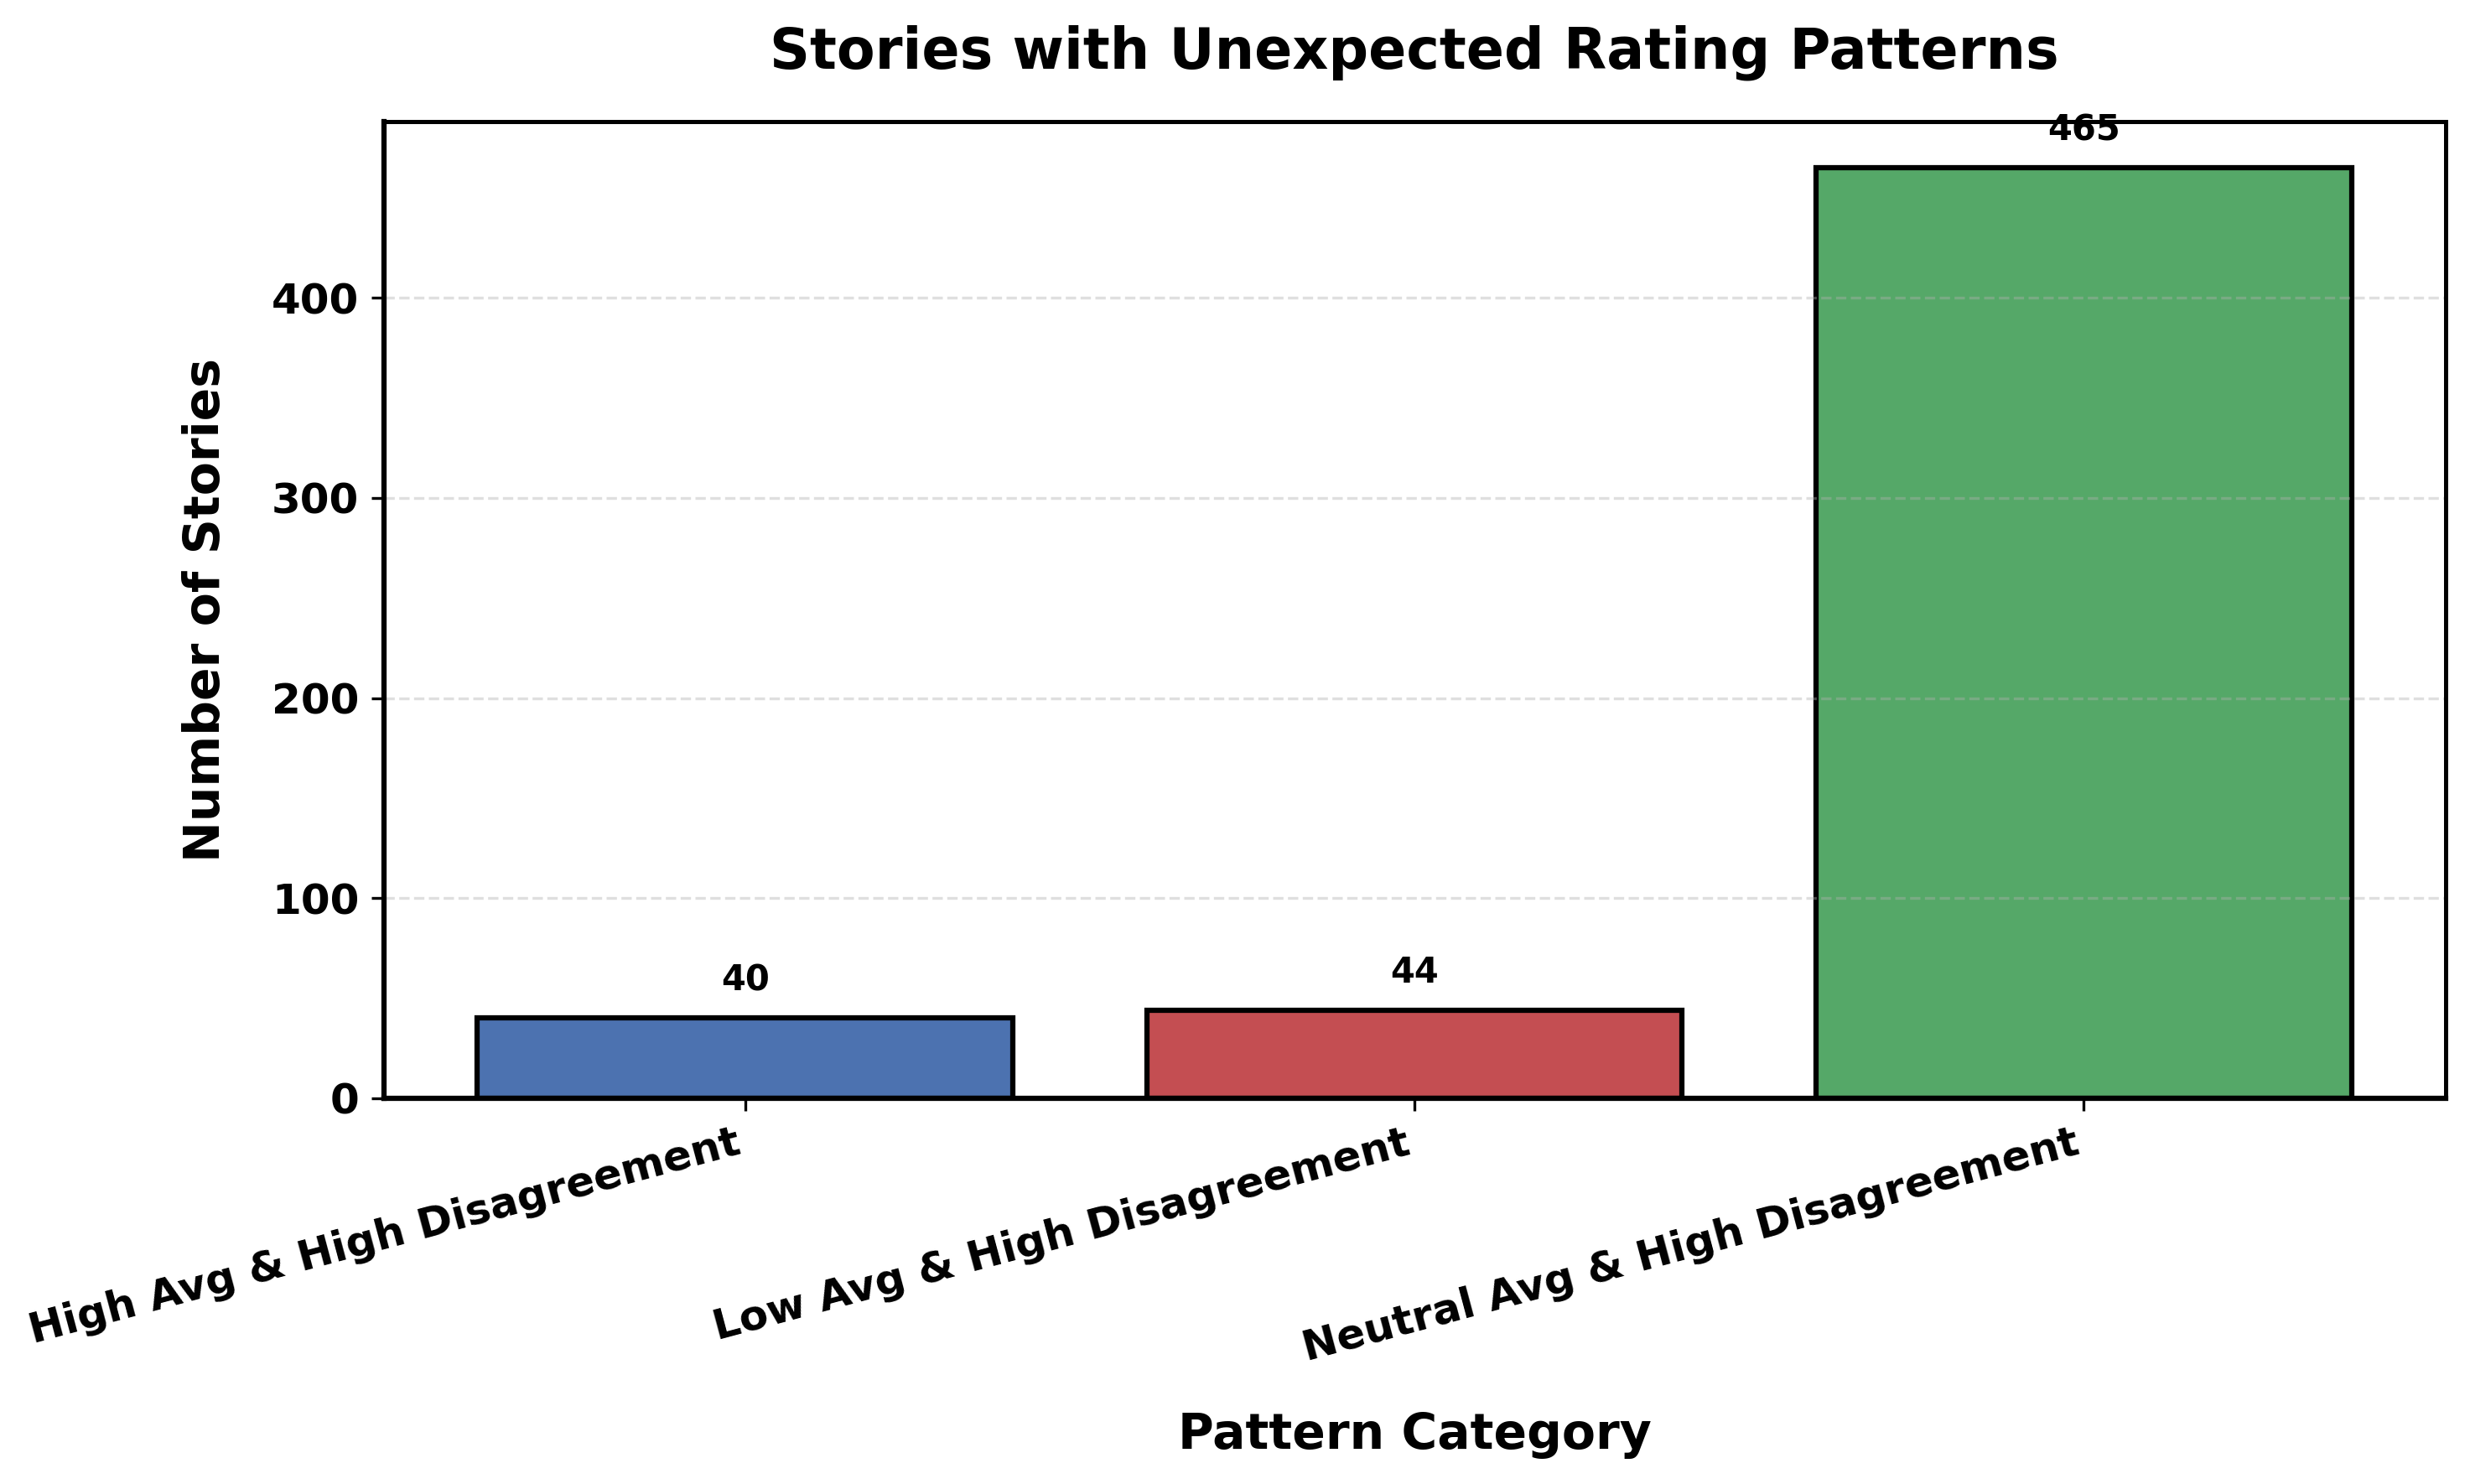

In [43]:

labels = [
    'High Avg & High Disagreement',
    'Low Avg & High Disagreement',
    'Neutral Avg & High Disagreement'
]
counts = [
    len(high_avg_high_std),
    len(low_avg_high_std),
    len(neutral_avg_high_std)
]

colors = ['#4C72B0', '#C44E52', '#55A868']

plt.figure(figsize=(10, 6), dpi=300)

bars = plt.bar(
    labels,
    counts,
    color=colors,
    edgecolor='black',
    linewidth=1.5
)

plt.title('Stories with Unexpected Rating Patterns', fontsize=16, weight='bold', pad=15)
plt.xlabel('Pattern Category', fontsize=14, weight='bold', labelpad=12)
plt.ylabel('Number of Stories', fontsize=14, weight='bold', labelpad=12)
plt.xticks(rotation=15, ha='right', fontsize=12, weight='bold')
plt.yticks(fontsize=12, weight='bold')

# Add counts on top of the bars
for bar in bars:
    yval = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2, yval + 10, int(yval),
             ha='center', va='bottom', fontsize=10, weight='bold', color='black')

ax = plt.gca()
ax.spines['bottom'].set_linewidth(1.5)
ax.spines['left'].set_linewidth(1.5)
ax.spines['top'].set_linewidth(1.2)
ax.spines['right'].set_linewidth(1.2)

plt.grid(axis='y', linestyle='--', alpha=0.4)
plt.tight_layout()
plt.savefig('plots/unexpected_rating_patterns_bar_chart.png', format='png')
plt.show()

# Pattern Recognition

In [44]:
with_end = []
without_end = []

with_end_std = []
without_end_std = []

for story_id, content in all_data.items():

    avg_rating = content.get("average", None)
    std_rating = content.get("stdev", None)

    ending_text = content.get("ending", "")

    if ending_text and ending_text.strip():
        with_end.append(avg_rating)
        with_end_std.append(std_rating)
    else:
        without_end.append(avg_rating)
        without_end_std.append(std_rating)

with_end = np.array(with_end)
without_end = np.array(without_end)
with_end_std = np.array(with_end_std)
without_end_std = np.array(without_end_std)

In [45]:
print("\nEnding Impact Analysis")

print(f"Stories with endings: {len(with_end)}")
print(f"Stories without endings: {len(without_end)}")

print(f"\nAverage Rating (with endings): {with_end.mean():.3f}")
print(f"Average Rating (without endings): {without_end.mean():.3f}")

print(f"\nAverage Std Dev (with endings): {with_end_std.mean():.3f}")
print(f"Average Std Dev (without endings): {without_end_std.mean():.3f}")



Ending Impact Analysis
Stories with endings: 1912
Stories without endings: 956

Average Rating (with endings): 3.144
Average Rating (without endings): 3.119

Average Std Dev (with endings): 0.964
Average Std Dev (without endings): 0.918


In [46]:
t_stat, p_value = ttest_ind(with_end_std, without_end_std, equal_var=False)

print("\nStatistical Significance Test")
print(f"T-statistic: {t_stat:.3f}")
print(f"P-value: {p_value:.4f}")

if p_value < 0.05:
    print("Conclusion: The effect of endings on agreement is statistically significant.")
else:
    print("Conclusion: The effect of endings on agreement is NOT statistically significant (likely noise).")




Statistical Significance Test
T-statistic: 2.355
P-value: 0.0186
Conclusion: The effect of endings on agreement is statistically significant.


In [47]:
# Context Length Analysis (word counts and correlations)
def word_count(text):
    if not isinstance(text, str):
        return 0
    return len(text.split())

precontext_lengths = []
sentence_lengths = []
ending_lengths = []

agreement_scores = []

for story_id, content in all_data.items():

    precontext_lengths.append(word_count(content.get("precontext", "")))
    sentence_lengths.append(word_count(content.get("sentence", "")))

    ending = content.get("ending", "")
    if ending and ending.strip():
        ending_lengths.append(word_count(ending))

    agreement_scores.append(content.get("stdev", 0))

context_df = pd.DataFrame({
    "precontext_len": precontext_lengths,
    "sentence_len": sentence_lengths,
    "ending_len": ending_lengths + [np.nan]*(len(precontext_lengths)-len(ending_lengths)),
    "agreement": agreement_scores
})



In [48]:
print("\nContext Length Summary")
print(f"Average Precontext Word Count: {context_df['precontext_len'].mean():.2f}")
print(f"Average Sentence Word Count: {context_df['sentence_len'].mean():.2f}")
print(f"Average Ending Word Count: {context_df['ending_len'].dropna().mean():.2f}")




Context Length Summary
Average Precontext Word Count: 31.43
Average Sentence Word Count: 9.38
Average Ending Word Count: 13.57


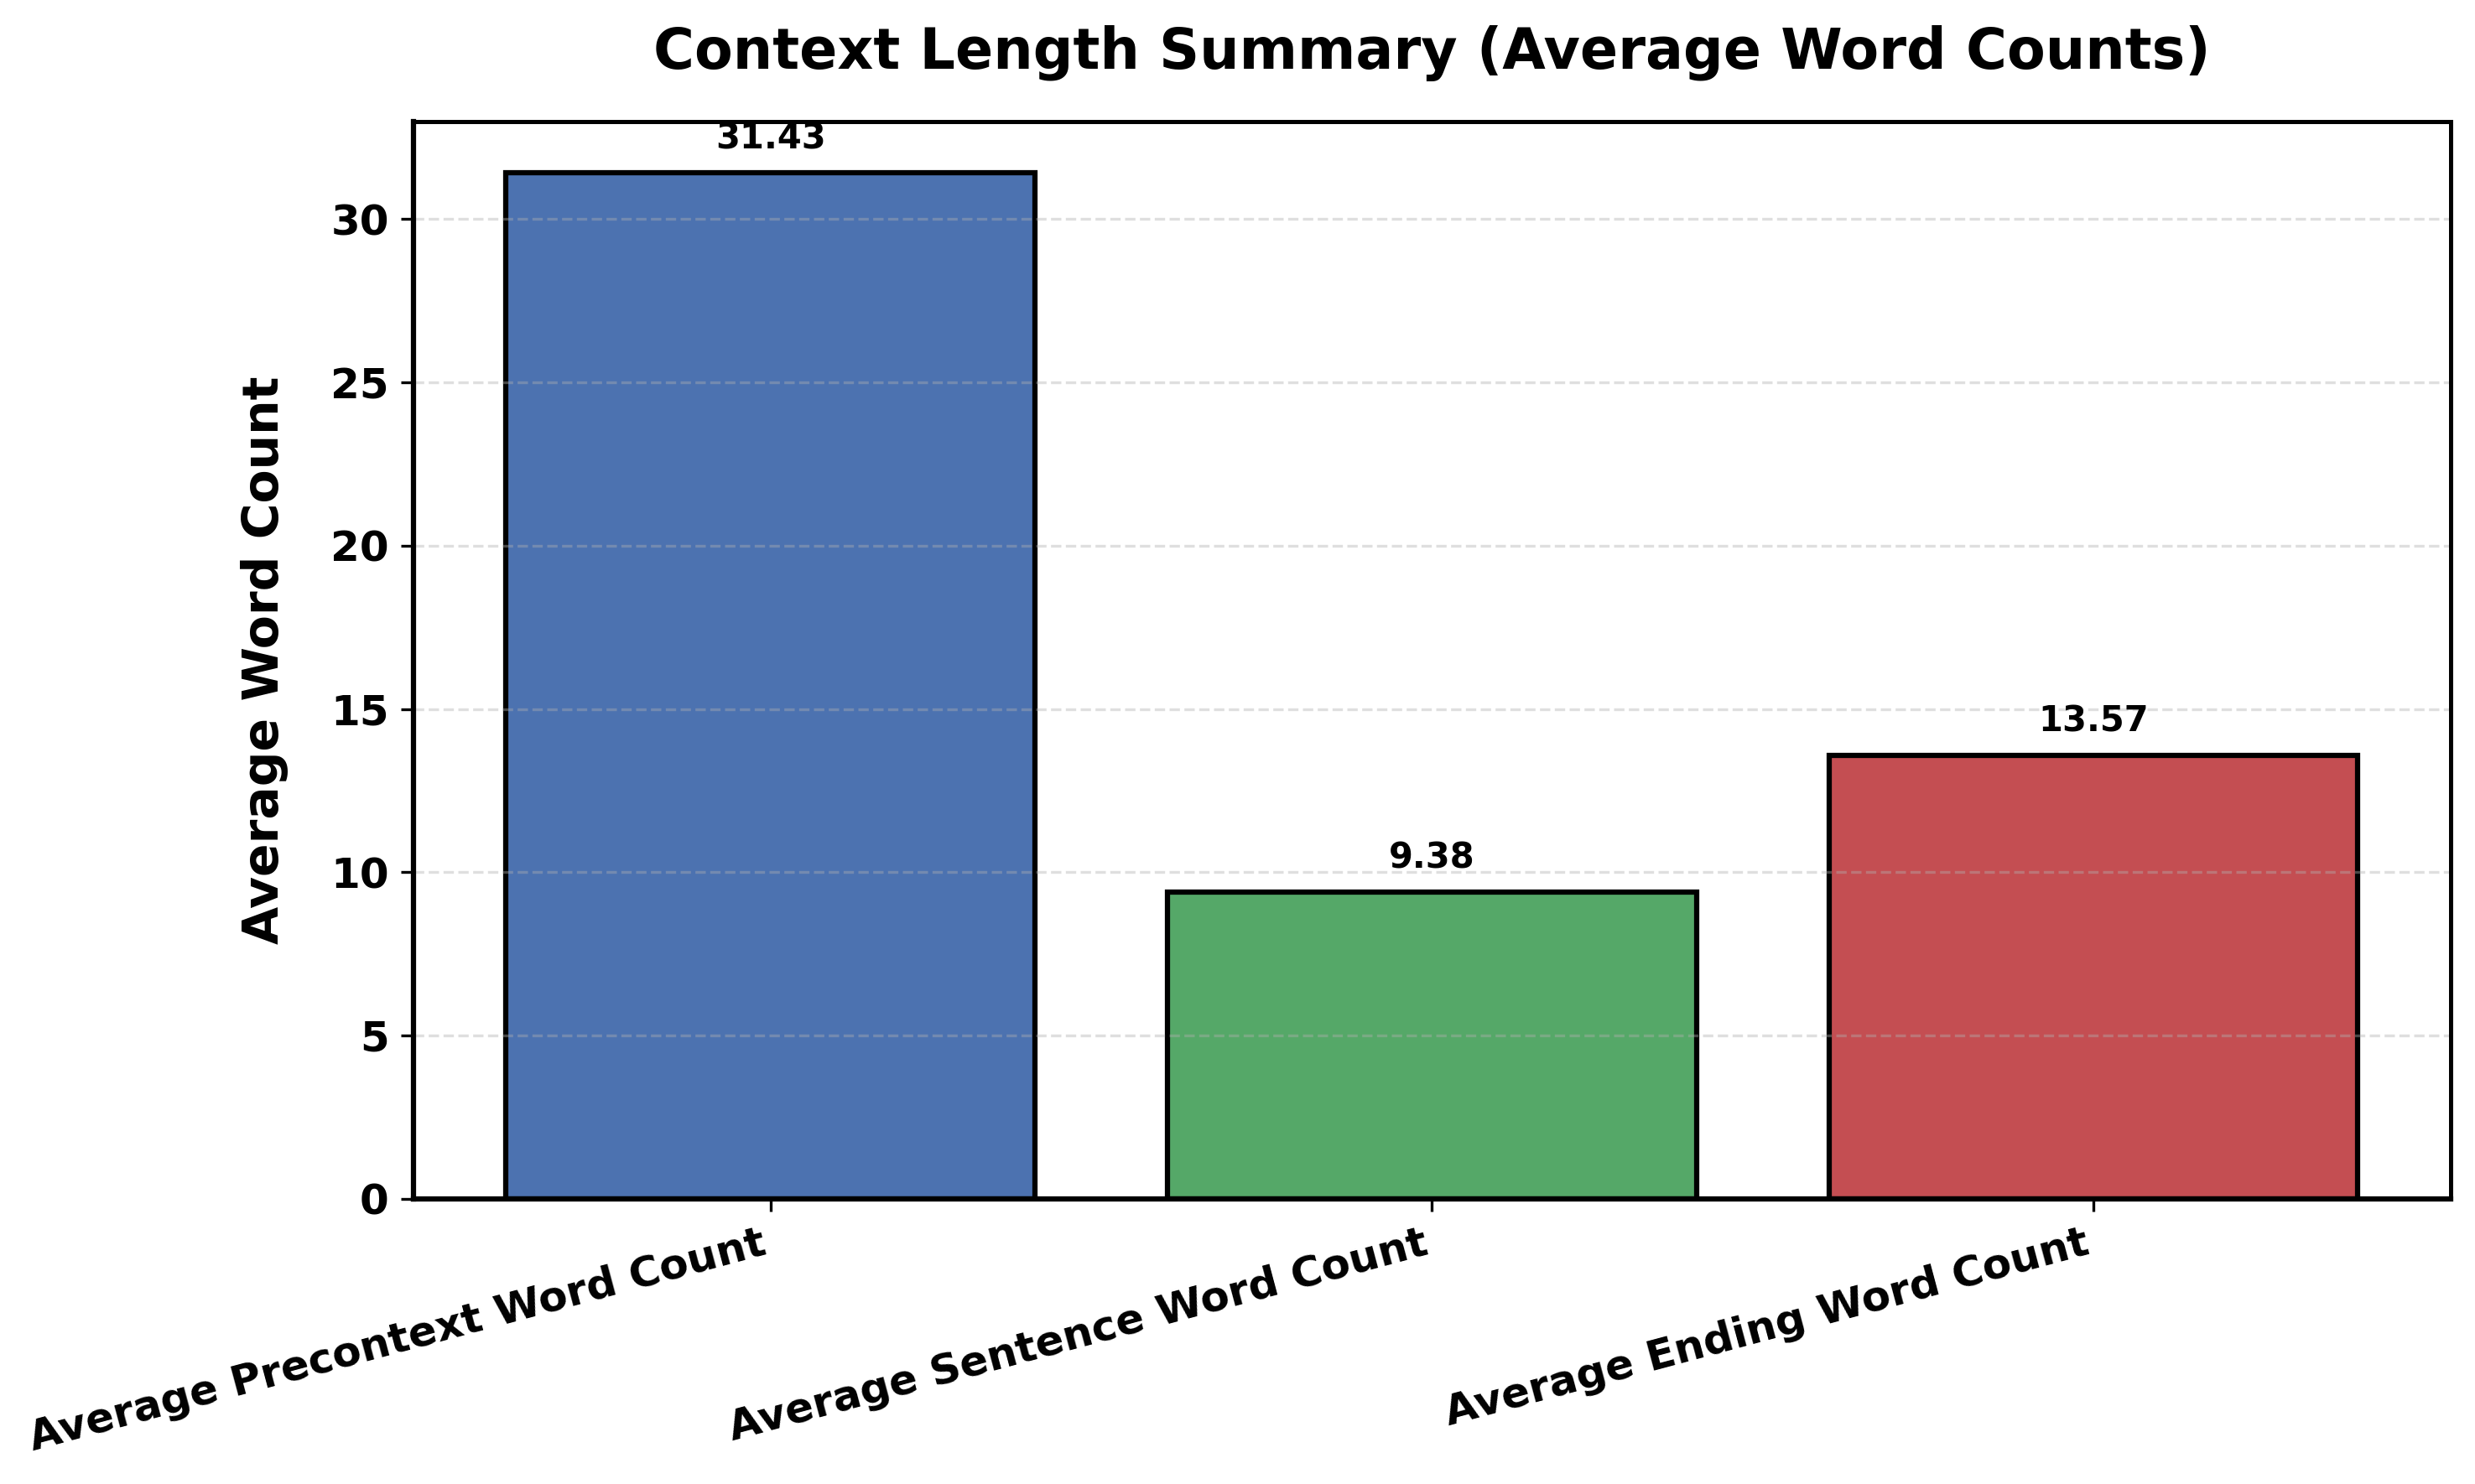

In [49]:

# Data provided by the user
labels = ['Average Precontext Word Count', 'Average Sentence Word Count', 'Average Ending Word Count']
values = [31.43, 9.38, 13.57]

plt.figure(figsize=(10, 6), dpi=300)

bars = plt.bar(
    labels,
    values,
    color=['#4C72B0', '#55A868', '#C44E52'],
    edgecolor='black',
    linewidth=1.5
)

plt.title('Context Length Summary (Average Word Counts)', fontsize=16, weight='bold', pad=15)
plt.ylabel('Average Word Count', fontsize=14, weight='bold', labelpad=12)
plt.xticks(rotation=15, ha='right', fontsize=12, weight='bold')
plt.yticks(fontsize=12, weight='bold')

# Add values on top of the bars
for bar in bars:
    yval = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2, yval + 0.5, f'{yval:.2f}',
             ha='center', va='bottom', fontsize=10, weight='bold', color='black')

ax = plt.gca()
ax.spines['bottom'].set_linewidth(1.5)
ax.spines['left'].set_linewidth(1.5)
ax.spines['top'].set_linewidth(1.2)
ax.spines['right'].set_linewidth(1.2)

plt.grid(axis='y', linestyle='--', alpha=0.4)
plt.tight_layout()
plt.savefig('plots/context_length_summary_bar_chart.png', format='png')
plt.show()

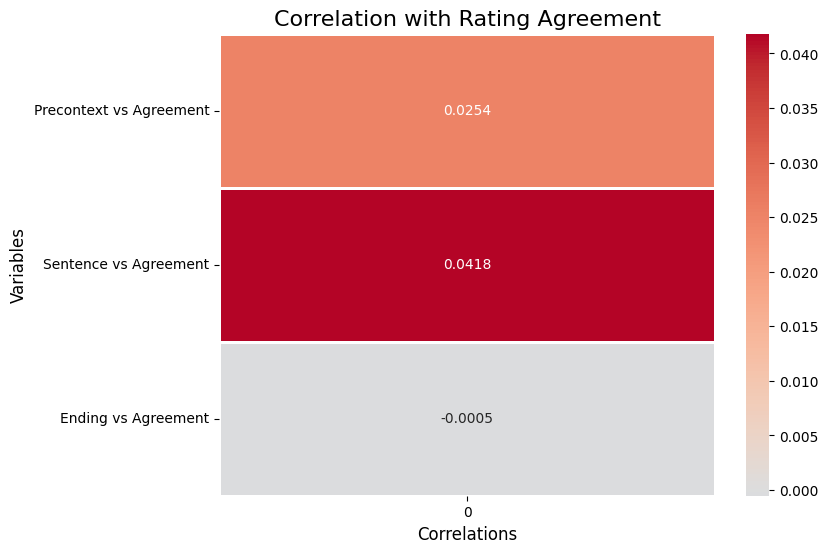


Correlation With Rating Agreement (Std Dev)
Correlation (Precontext length <-> Agreement): 0.0254
Correlation (Sentence length <-> Agreement): 0.0418
Correlation (Ending length <-> Agreement): -0.0005


In [62]:

corr_precontext = context_df["precontext_len"].corr(context_df["agreement"])
corr_sentence = context_df["sentence_len"].corr(context_df["agreement"])
corr_ending = context_df["ending_len"].corr(context_df["agreement"])

# Create a correlation matrix
corr_matrix = pd.DataFrame({
    'Precontext vs Agreement': [corr_precontext],
    'Sentence vs Agreement': [corr_sentence],
    'Ending vs Agreement': [corr_ending]
}).T

# Plotting the correlation heatmap
plt.figure(figsize=(8, 6))
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', center=0, linewidths=1, fmt='.4f', cbar=True)

# Set title and labels
plt.title("Correlation with Rating Agreement", fontsize=16)
plt.ylabel("Variables", fontsize=12)
plt.xlabel("Correlations", fontsize=12)
plt.savefig('plots/context_length_correlation_heatmap.png', format='png')
# Show plot
plt.show()

# Print the correlation values
print("\nCorrelation With Rating Agreement (Std Dev)")
print(f"Correlation (Precontext length <-> Agreement): {corr_precontext:.4f}")
print(f"Correlation (Sentence length <-> Agreement): {corr_sentence:.4f}")
print(f"Correlation (Ending length <-> Agreement): {corr_ending:.4f}")


In [57]:
# Ensure nltk punkt tokenizer is downloaded
try:
    nltk.data.find('tokenizers/punkt')
except LookupError: # Changed DownloadError to LookupError
    nltk.download('punkt')

# Function to find the 0-based word position of the first occurrence of a homonym in a sentence
def find_homonym_position(row):
    target_homonym = row['homonym'].lower()
    sentence_text = row['sentence'].lower()

    # Tokenize the sentence
    tokens = word_tokenize(sentence_text)

    # Process each token: strip punctuation and compare
    for i, token in enumerate(tokens):
        # Remove punctuation from both ends of the token for a clean comparison
        cleaned_token = token.strip(".,!?;:\"'()[]{}")
        if cleaned_token == target_homonym:
            return i # Return the 0-based index of the token

    return np.nan # Homonym not found

# Apply the function to create the new column
all_data_df['homonym_position'] = all_data_df.apply(find_homonym_position, axis=1)

# Drop rows where homonym_position could not be determined (should be few if any)
initial_rows = len(all_data_df)
all_data_df.dropna(subset=['homonym_position'], inplace=True)
if len(all_data_df) < initial_rows:
    print(f"Dropped {initial_rows - len(all_data_df)} rows due to missing homonym position.")





Correlation between Homonym Position and Average Rating: 0.0310 (p=0.0977)
Correlation between Homonym Position and Standard Deviation of Ratings: 0.0096 (p=0.6081)


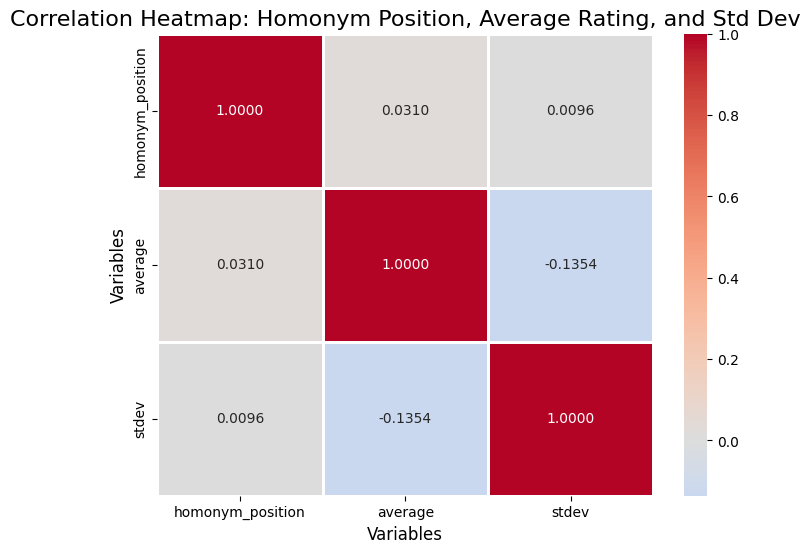


Correlation between Homonym Position and Average Rating: 0.0310 (p=0.0977)
Correlation between Homonym Position and Standard Deviation of Ratings: 0.0096 (p=0.6081)


In [60]:
all_data_df['homonym_position'] = all_data_df['homonym_position'].astype(int)

# Calculate correlations
corr_avg_rating, p_avg_rating = pearsonr(all_data_df['homonym_position'], all_data_df['average'])
corr_stdev_rating, p_stdev_rating = pearsonr(all_data_df['homonym_position'], all_data_df['stdev'])

# Create a correlation matrix for the variables of interest
corr_matrix = all_data_df[['homonym_position', 'average', 'stdev']].corr()

# Plotting the heatmap
plt.figure(figsize=(8, 6))
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', center=0, linewidths=1, fmt='.4f', cbar=True)

# Set title and labels
plt.title("Correlation Heatmap: Homonym Position, Average Rating, and Std Dev", fontsize=16)
plt.xlabel("Variables", fontsize=12)
plt.ylabel("Variables", fontsize=12)
plt.savefig('plots/homonym_position_correlation_heatmap.png', format='png')
# Show the plot
plt.show()


# Print the correlation results
print(f"\nCorrelation between Homonym Position and Average Rating: {corr_avg_rating:.4f} (p={p_avg_rating:.4f})")
print(f"Correlation between Homonym Position and Standard Deviation of Ratings: {corr_stdev_rating:.4f} (p={p_stdev_rating:.4f})")
